In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv(
    '/kaggle/input/eurusd-4monthsdata/eurusd4months_tickdata.csv',
    sep='\t'
)

data.head()


,<DATE>,<TIME>,<BID>,<ASK>,<LAST>,<VOLUME>,<FLAGS>
0,2025.09.02,00:01:05.405,1.17058,1.17120,NaN,NaN,6
1,2025.09.02,00:01:07.001,1.17061,NaN,NaN,NaN,2
2,2025.09.02,00:01:11.001,1.17063,NaN,NaN,NaN,2
3,2025.09.02,00:02:00.006,1.17063,NaN,NaN,NaN,2
4,2025.09.02,00:02:00.130,1.17084,1.17114,NaN,NaN,6


In [2]:
data.columns = ['date', 'time', 'bid', 'ask', 'last', 'volume', 'flags']
data.head()

,date,time,bid,ask,last,volume,flags
0,2025.09.02,00:01:05.405,1.17058,1.17120,NaN,NaN,6
1,2025.09.02,00:01:07.001,1.17061,NaN,NaN,NaN,2
2,2025.09.02,00:01:11.001,1.17063,NaN,NaN,NaN,2
3,2025.09.02,00:02:00.006,1.17063,NaN,NaN,NaN,2
4,2025.09.02,00:02:00.130,1.17084,1.17114,NaN,NaN,6


In [3]:
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'], format='%Y.%m.%d %H:%M:%S.%f')
data.set_index('datetime', inplace=True)
data.drop(columns=['date', 'time'], inplace=True)


data['bid'] = data['bid'].astype(float)
data['ask'] = data['ask'].astype(float)
data['last'] = data['last'].astype(float)
data['volume'] = data['volume'].astype(float)

In [4]:
data.head()

,bid,ask,last,volume,flags
datetime,,,,,
2025-09-02 00:01:05.405,1.17058,1.17120,NaN,NaN,6
2025-09-02 00:01:07.001,1.17061,NaN,NaN,NaN,2
2025-09-02 00:01:11.001,1.17063,NaN,NaN,NaN,2
2025-09-02 00:02:00.006,1.17063,NaN,NaN,NaN,2
2025-09-02 00:02:00.130,1.17084,1.17114,NaN,NaN,6


In [5]:
from scipy import stats
from scipy.spatial.distance import mahalanobis
from scipy.stats import genpareto
from sklearn.covariance import LedoitWolf



class HFTAnomalyDetector:
    """
      Robust covariance estimation
      Anomaly persistence scoring
      Regime-aware thresholds
      Numerical stability safeguards
    """
    
    def __init__(self, 
                 vol_window=1000, 
                 corr_window=5000,
                 evt_quantile=0.99,
                 base_threshold=5.0):
        self.vol_window = vol_window
        self.corr_window = corr_window
        self.evt_quantile = evt_quantile
        self.base_threshold = base_threshold
        
    def compute_price_features(self, data):
        """Enhanced price anomaly detection with persistence scoring"""
        df = data.copy()
        
        # Mid-price and log returns
        df['mid'] = (df['bid'] + df['ask']) / 2
        df['log_return'] = np.log(df['mid']).diff()
        
        # Robust volatility estimation with EMA for faster adaptation
        df['rv_std'] = df['log_return'].rolling(
            window=self.vol_window, min_periods=50
        ).std()
        df['rv_ewm'] = df['log_return'].ewm(
            span=self.vol_window//2, min_periods=50
        ).std()
        
        # Use minimum of two volatility estimates for conservative z-scores
        df['rv'] = np.minimum(df['rv_std'], df['rv_ewm'])
        df['rv'] = df['rv'].fillna(method='bfill').fillna(df['log_return'].std())
        
        # Price anomaly z-score with numerical stability
        df['price_z'] = df['log_return'] / (df['rv'] + 1e-10)
        df['price_z'] = df['price_z'].clip(-20, 20)  # Prevent extreme outliers
        
        # Anomaly persistence scoring
        # Single-tick spikes vs sustained anomalies
        z_threshold = self.base_threshold
        df['price_anomaly_raw'] = df['price_z'].abs() > z_threshold
        
        # Persistence score: weighted sum of recent anomalies
        persistence_window = 50
        df['anomaly_persistence'] = df['price_anomaly_raw'].rolling(
            window=persistence_window, min_periods=1
        ).apply(lambda x: np.sum(x * np.exp(-0.1 * np.arange(len(x))[::-1])), raw=True)
        
        # Final anomaly: high z-score AND sustained
        df['price_anomaly'] = (
            (df['price_z'].abs() > z_threshold) & 
            (df['anomaly_persistence'] > 2.0)  # Requires clustering
        )
        
        # Bid/ask mispricing detection (execution-critical)
        df['bid_ask_mispricing'] = (
            (df['bid'] > df['ask']) | 
            (df['last'] < df['bid']) | 
            (df['last'] > df['ask'])
        )
        
        # Detect stale quotes (same bid/ask for N ticks)
        df['bid_unchanged'] = (df['bid'].diff() == 0).rolling(20).sum()
        df['ask_unchanged'] = (df['ask'].diff() == 0).rolling(20).sum()
        df['stale_quote'] = (df['bid_unchanged'] > 15) | (df['ask_unchanged'] > 15)
        
        return df
    
    def compute_microstructure_features(self, data):
        """Enhanced microstructure with context-aware features"""
        df = data.copy()
        
        # SPREAD ANALYSIS 
        df['spread'] = df['ask'] - df['bid']
        df['spread_pct'] = df['spread'] / df['mid']  # Relative spread
        
        # Robust spread z-score
        spread_ma = df['spread'].rolling(self.vol_window, min_periods=50).mean()
        spread_std = df['spread'].rolling(self.vol_window, min_periods=50).std()
        df['spread_z'] = (df['spread'] - spread_ma) / (spread_std + 1e-10)
        df['spread_z'] = df['spread_z'].clip(-20, 20)
        
        # Regime-aware threshold: tighter in low-vol, looser in high-vol
        vol_regime = df['rv'].rolling(1000).mean()
        adaptive_threshold = self.base_threshold * (1 + vol_regime / vol_regime.median())
        df['spread_anomaly'] = df['spread_z'].abs() > adaptive_threshold
        
        # TICK DYNAMICS 
        df['tick_diff'] = df.index.to_series().diff().dt.total_seconds()
        df['tick_diff'] = df['tick_diff'].fillna(0)
        
        # Context-aware quote stuffing detection
        # Not just speed, but quote-to-trade ratio
        df['price_changed'] = (df['mid'].diff().abs() > 1e-8).astype(int)
        df['quote_to_trade'] = df['price_changed'].rolling(100).sum() / (df['volume'].rolling(100).sum() + 1)
        
        df['quote_stuffing'] = (
            (df['tick_diff'] < 0.01) &  # Fast updates
            (df['quote_to_trade'] > 0.8) &  # High quote-to-trade
            (df['volume'] < df['volume'].rolling(100).quantile(0.1))  # Low volume
        )
        
        # PRICE IMPACT
        # Square-root impact model (Kyle 1985)
        df['volume_sqrt'] = np.sqrt(df['volume'] + 1e-9)
        df['mid_change'] = df['mid'].diff().abs()
        
        # Expected impact under square-root law
        df['expected_impact'] = df['volume_sqrt'] * df['mid_change'].rolling(self.vol_window).mean() / df['volume_sqrt'].rolling(self.vol_window).mean()
        df['actual_impact'] = df['mid_change']
        
        # Impact anomaly: actual >> expected
        df['impact_ratio'] = df['actual_impact'] / (df['expected_impact'] + 1e-10)
        df['impact_ratio'] = df['impact_ratio'].clip(0, 100)
        
        df['price_impact_z'] = (df['impact_ratio'] - df['impact_ratio'].rolling(self.vol_window).mean()) / (df['impact_ratio'].rolling(self.vol_window).std() + 1e-10)
        df['price_impact_anomaly'] = df['price_impact_z'].abs() > self.base_threshold
        
        # ORDER FLOW IMBALANCE 
        # Signed volume proxy (uptick rule approximation)
        df['price_direction'] = np.sign(df['mid'].diff())
        df['signed_volume'] = df['volume'] * df['price_direction']
        df['ofi'] = df['signed_volume'].rolling(100).sum()  # Order flow imbalance
        df['ofi_z'] = (df['ofi'] - df['ofi'].rolling(self.vol_window).mean()) / (df['ofi'].rolling(self.vol_window).std() + 1e-10)
        
        return df
    
    def compute_statistical_anomalies(self, data):
        """Robust multivariate anomaly detection with stability safeguards"""
        df = data.copy()
        
        #  ROBUST MAHALANOBIS DISTANCE 
        features = ['log_return', 'spread', 'volume', 'ofi']
        
        # Ensure features exist and handle missing
        for feat in features:
            if feat not in df.columns:
                print(f"Warning: {feat} not found, skipping multivariate analysis")
                df['mahalanobis'] = 0
                df['multivariate_anomaly'] = False
                return df
        
        df_clean = df[features].replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(df_clean) < 100:
            print("Insufficient data for multivariate analysis")
            df['mahalanobis'] = 0
            df['multivariate_anomaly'] = False
            return df
        
        #  Ledoit-Wolf shrinkage for robust covariance
        try:
            lw = LedoitWolf()
            cov_robust = lw.fit(df_clean).covariance_
            inv_cov = np.linalg.inv(cov_robust)
            mean_vec = df_clean.mean().values
            
            # Compute Mahalanobis with error handling
            def safe_mahalanobis(row):
                try:
                    return mahalanobis(row, mean_vec, inv_cov)
                except:
                    return np.nan
            
            df['mahalanobis'] = df[features].apply(safe_mahalanobis, axis=1)
            df['mahalanobis'] = df['mahalanobis'].fillna(0)
            
            # Adaptive threshold based on chi-square distribution
            # For 4 features, 99.9th percentile of chi2(4) ~ 18.47
            df['multivariate_anomaly'] = df['mahalanobis'] > 18.47
            
        except Exception as e:
            print(f"Mahalanobis computation failed: {e}")
            df['mahalanobis'] = 0
            df['multivariate_anomaly'] = False
        
        # EXTREME VALUE THEORY 
        #  Robust EVT with validation
        try:
            returns_clean = df['log_return'].replace([np.inf, -np.inf], np.nan).dropna()
            
            if len(returns_clean) < 1000:
                df['evt_anomaly'] = False
                df['evt_probability'] = 0
                return df
            
            # Upper tail
            threshold_upper = returns_clean.quantile(self.evt_quantile)
            excesses_upper = returns_clean[returns_clean > threshold_upper] - threshold_upper
            
            if len(excesses_upper) > 30:  # Need sufficient exceedances
                params_upper = genpareto.fit(excesses_upper, floc=0)
                
                # Validate fit (shape parameter should be reasonable)
                if -0.5 < params_upper[0] < 0.5:  # Shape parameter check
                    evt_threshold = threshold_upper + genpareto.ppf(0.995, *params_upper)
                    df['evt_probability'] = 1 - genpareto.cdf(
                        df['log_return'] - threshold_upper, *params_upper
                    )
                    df['evt_anomaly'] = df['log_return'] > evt_threshold
                else:
                    df['evt_anomaly'] = False
                    df['evt_probability'] = 0
            else:
                df['evt_anomaly'] = False
                df['evt_probability'] = 0
                
        except Exception as e:
            print(f"EVT computation failed: {e}")
            df['evt_anomaly'] = False
            df['evt_probability'] = 0
        
        # ROLLING CORRELATION ANOMALY
        #  multiple correlation pairs
        df['corr_lv'] = df['log_return'].rolling(
            self.corr_window, min_periods=100
        ).corr(df['volume'])
        
        df['corr_ls'] = df['log_return'].rolling(
            self.corr_window, min_periods=100
        ).corr(df['spread'])
        
        # Detect correlation breaks
        corr_ma = df['corr_lv'].rolling(self.corr_window).mean()
        corr_std = df['corr_lv'].rolling(self.corr_window).std()
        df['corr_z'] = (df['corr_lv'] - corr_ma) / (corr_std + 1e-10)
        df['corr_anomaly'] = df['corr_z'].abs() > 3  # Correlation regime shift
        
        return df
    
    def create_meta_features(self, data):
        """Second-order features: anomaly patterns, not just anomalies"""
        df = data.copy()
        
        # Ensure all anomaly columns are proper boolean with explicit False fillna
        anomaly_cols = [c for c in df.columns if 'anomaly' in c and c in df.columns]
        for col in anomaly_cols:
            df[col] = df[col].fillna(False).astype(bool)
        
        # Anomaly clustering score
        df['total_anomalies'] = df[anomaly_cols].sum(axis=1)
        
        # Multi-anomaly events (high predictive power)
        df['anomaly_cluster'] = (df['total_anomalies'] >= 3).astype(bool)
        
        # Anomaly lead-lag: microstructure leads price?
        if 'spread_anomaly' in df.columns and 'price_anomaly' in df.columns:
            df['micro_leads_price'] = (
                df['spread_anomaly'].shift(5).fillna(False).rolling(10).sum() > 
                df['price_anomaly'].fillna(False).rolling(10).sum()
            ).fillna(False).astype(bool)
        else:
            df['micro_leads_price'] = False
        
        # Regime features with robust handling
        try:
            df['vol_regime'] = pd.qcut(
                df['rv'].fillna(method='ffill'), 
                q=3, labels=['low', 'medium', 'high'], 
                duplicates='drop'
            )
        except:
            df['vol_regime'] = 'medium'
        
        try:
            # Liquidity regime
            df['liquidity_regime'] = pd.qcut(
                df['spread'].fillna(method='ffill'),
                q=3, labels=['tight', 'normal', 'wide'],
                duplicates='drop'
            )
        except:
            df['liquidity_regime'] = 'normal'
        
        return df
    
    def fit_transform(self, data):
        """Full pipeline with all enhancements and type safety"""
        print("Computing price features...")
        df = self.compute_price_features(data)
        
        print(" Computing microstructure features...")
        df = self.compute_microstructure_features(df)
        
        print("Computing statistical anomalies...")
        df = self.compute_statistical_anomalies(df)
        
        print(" Creating meta-features...")
        df = self.create_meta_features(df)
        
        # Type safety enforcement for all anomaly flags
        print("Enforcing type safety...")
        anomaly_cols = [c for c in df.columns if 'anomaly' in c]
        for col in anomaly_cols:
            df[col] = df[col].fillna(False).astype(bool)
        
        # Validate numerical columns for NaN/Inf
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df[col].isnull().sum() > 0:
                print(f" Warning: {col} has {df[col].isnull().sum()} NaN values")
            if np.isinf(df[col]).sum() > 0:
                print(f"Warning: {col} has {np.isinf(df[col]).sum()} Inf values")
                df[col] = df[col].replace([np.inf, -np.inf], np.nan)
        
        print("Anomaly detection complete!")
        return df



In [6]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.gridspec import GridSpec
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f5f5f5'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10


class          AnomalyVisualizer:
    
    
    def __init__(self, result_df):


        
        self.df = result_df.copy()
        self.anomaly_cols = [c for c in self.df.columns if 'anomaly' in c]
        
        # Data quality validation
        self._validate_data()
        
        # Skip warm-up period for clean visualizations
        self.start_idx = self._determine_clean_start()
        
        print(f" Visualizer initialized")
        print(f"   Total observations: {len(self.df):,}")
        print(f"   Clean data from index: {self.start_idx:,}")
        print(f"   Anomaly types detected: {len(self.anomaly_cols)}")
        
    def _validate_data(self):
        
        required = ['mid', 'bid', 'ask']
        missing = [col for col in required if col not in self.df.columns]
        if missing:
            raise ValueError(f"Missing required columns: {missing}")
    
    def _determine_clean_start(self):
        
        # Start after longest rolling window warm-up
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        first_valid = []
        for col in numeric_cols:
            if self.df[col].notna().sum() > 0:
                first_valid.append(self.df[col].first_valid_index())
        
        if first_valid:
            clean_start = max([self.df.index.get_loc(idx) for idx in first_valid])
            return min(clean_start + 100, len(self.df) - 1000)  # Ensure enough data remains
        return 0
    
    
    
    # CHART 1: PRICE SERIES WITH ANOMALY MARKERS
    
    
    def plot_price_with_anomalies(self, window=2000, start_idx=None):

        
        if start_idx is None:
            start_idx = self.start_idx
        
        df_slice = self.df.iloc[start_idx:start_idx+window].copy()
        
        if len(df_slice) < 100:
            print(" Insufficient data for visualization")
            return
        
        fig = plt.figure(figsize=(20, 14))
        gs = GridSpec(4, 1, height_ratios=[2, 1, 1, 1], hspace=0.3)
        
        # Color scheme for anomaly types
        anomaly_colors = {
            'price_anomaly': '#FF4444',
            'spread_anomaly': '#FF8C00',
            'price_impact_anomaly': '#9370DB',
            'multivariate_anomaly': '#20B2AA',
            'evt_anomaly': '#DC143C',
            'corr_anomaly': '#4169E1',
            'anomaly_cluster': '#8B008B',
            'bid_ask_mispricing': '#FF1493'
        }
        
        # PANEL 1: PRICE WITH ANOMALIES 
        ax1 = fig.add_subplot(gs[0])
        
        # Plot price line
        ax1.plot(df_slice.index, df_slice['mid'], 
                color='#2C3E50', linewidth=1.2, alpha=0.8, label='Mid Price')
        
        # Overlay each anomaly type
        for anom_col in self.anomaly_cols:
            if anom_col not in df_slice.columns:
                continue
                
            anom_data = df_slice[df_slice[anom_col]]
            if len(anom_data) == 0:
                continue
            
            label = anom_col.replace('_', ' ').title()
            color = anomaly_colors.get(anom_col, '#808080')
            
            # Different markers for different types
            if 'cluster' in anom_col:
                marker, size = '*', 200
            elif 'mispricing' in anom_col:
                marker, size = 'X', 150
            elif 'price_anomaly' in anom_col:
                marker, size = 'o', 80
            else:
                marker, size = 's', 60
            
            ax1.scatter(anom_data.index, anom_data['mid'], 
                       c=color, marker=marker, s=size, 
                       label=f'{label} ({len(anom_data)})', 
                       alpha=0.7, edgecolors='black', linewidths=0.5, zorder=5)
        
        ax1.set_ylabel('Price', fontsize=13, fontweight='bold')
        ax1.set_title('EUR/USD Tick Price with Detected Anomalies', 
                     fontsize=16, fontweight='bold', pad=20)
        ax1.legend(loc='upper left', framealpha=0.95, ncol=2, fontsize=9)
        ax1.grid(True, alpha=0.3, linestyle='--')
        ax1.set_facecolor('#F8F9FA')
        
        #  PANEL 2: Z-SCORES 
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
        
        if 'price_z' in df_slice.columns:
            ax2.plot(df_slice.index, df_slice['price_z'], 
                    color='#3498DB', linewidth=1, alpha=0.8, label='Price Z-Score')
            
            # Threshold lines
            ax2.axhline(y=5, color='#E74C3C', linestyle='--', linewidth=1.5, 
                       label='±5σ Threshold', alpha=0.8)
            ax2.axhline(y=-5, color='#E74C3C', linestyle='--', linewidth=1.5, alpha=0.8)
            ax2.axhline(y=0, color='#34495E', linestyle='-', linewidth=0.8, alpha=0.5)
            
            # Fill normal range
            ax2.fill_between(df_slice.index, -5, 5, alpha=0.1, color='#27AE60')
            
            # Highlight extreme events
            extreme = df_slice[df_slice['price_z'].abs() > 5]
            if len(extreme) > 0:
                ax2.scatter(extreme.index, extreme['price_z'], 
                           c='#E74C3C', s=50, zorder=5, alpha=0.7)
        
        ax2.set_ylabel('Z-Score', fontsize=13, fontweight='bold')
        ax2.set_title('Normalized Return Deviations', fontsize=14, fontweight='bold')
        ax2.legend(loc='upper left', framealpha=0.95, fontsize=9)
        ax2.grid(True, alpha=0.3, linestyle='--')
        ax2.set_facecolor('#F8F9FA')
        ax2.set_ylim(-10, 10)
        
        #  PANEL 3: SPREAD DYNAMICS 
        ax3 = fig.add_subplot(gs[2], sharex=ax1)
        
        if 'spread' in df_slice.columns:
            # Convert to pips (1 pip = 0.0001 for EUR/USD)
            spread_pips = df_slice['spread'] * 10000
            
            ax3.plot(df_slice.index, spread_pips, 
                    color='#16A085', linewidth=1, alpha=0.8, label='Bid-Ask Spread')
            
            # Rolling average
            spread_ma = spread_pips.rolling(100).mean()
            ax3.plot(df_slice.index, spread_ma, 
                    color='#E67E22', linewidth=2, alpha=0.6, 
                    label='100-Tick MA', linestyle='--')
            
            # Mark spread anomalies
            if 'spread_anomaly' in df_slice.columns:
                spread_anom = df_slice[df_slice['spread_anomaly']]
                if len(spread_anom) > 0:
                    ax3.scatter(spread_anom.index, spread_anom['spread'] * 10000, 
                               c='#E74C3C', s=60, zorder=5, 
                               label=f'Spread Anomalies ({len(spread_anom)})', alpha=0.7)
        
        ax3.set_ylabel('Spread (pips)', fontsize=13, fontweight='bold')
        ax3.set_title('Bid-Ask Spread Analysis', fontsize=14, fontweight='bold')
        ax3.legend(loc='upper left', framealpha=0.95, fontsize=9)
        ax3.grid(True, alpha=0.3, linestyle='--')
        ax3.set_facecolor('#F8F9FA')
        
        # PANEL 4: VOLUME & ORDER FLOW 
        ax4 = fig.add_subplot(gs[3], sharex=ax1)
        ax4_twin = ax4.twinx()
        
        if 'volume' in df_slice.columns:
            # Volume bars
            ax4.bar(df_slice.index, df_slice['volume'], 
                   width=pd.Timedelta(milliseconds=50), 
                   color='#3498DB', alpha=0.4, label='Volume')
            ax4.set_ylabel('Volume', fontsize=13, fontweight='bold', color='#3498DB')
            ax4.tick_params(axis='y', labelcolor='#3498DB')
        
        if 'ofi' in df_slice.columns:
            # Order flow imbalance
            ax4_twin.plot(df_slice.index, df_slice['ofi'], 
                         color='#E74C3C', linewidth=1.5, label='Order Flow Imbalance')
            ax4_twin.axhline(y=0, color='#34495E', linestyle='-', linewidth=0.8, alpha=0.5)
            ax4_twin.set_ylabel('Order Flow Imbalance', fontsize=13, 
                               fontweight='bold', color='#E74C3C')
            ax4_twin.tick_params(axis='y', labelcolor='#E74C3C')
            
            # Fill positive/negative OFI
            ax4_twin.fill_between(df_slice.index, df_slice['ofi'], 0, 
                                 where=(df_slice['ofi'] > 0), 
                                 color='#27AE60', alpha=0.2, label='Buy Pressure')
            ax4_twin.fill_between(df_slice.index, df_slice['ofi'], 0, 
                                 where=(df_slice['ofi'] < 0), 
                                 color='#E74C3C', alpha=0.2, label='Sell Pressure')
        
        ax4.set_xlabel('Time', fontsize=13, fontweight='bold')
        ax4.set_title('Volume & Order Flow Dynamics', fontsize=14, fontweight='bold')
        ax4.legend(loc='upper left', framealpha=0.95, fontsize=9)
        ax4_twin.legend(loc='upper right', framealpha=0.95, fontsize=9)
        ax4.grid(True, alpha=0.3, linestyle='--')
        ax4.set_facecolor('#F8F9FA')
        
        # Format x-axis
        if hasattr(df_slice.index, 'strftime'):
            ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
            plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
        
        print(f" Chart 1: Price analysis displayed ({len(df_slice):,} ticks)")
    
    
    
    # CHART 2: ANOMALY CO-OCCURRENCE MATRIX
    
    
    def plot_anomaly_correlation(self):

        
        if len(self.anomaly_cols) == 0:
            print(" No anomaly columns found")
            return
        
        # Create binary anomaly matrix
        anomaly_matrix = self.df[self.anomaly_cols].fillna(False).astype(int)
        
        # Compute correlation
        corr_matrix = anomaly_matrix.corr()
        
        # Create figure
        fig, ax = plt.subplots(figsize=(14, 12))
        
        # Generate heatmap
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
        
        sns.heatmap(corr_matrix, 
                   mask=mask,
                   annot=True, 
                   fmt='.3f', 
                   cmap='RdYlGn_r', 
                   center=0, 
                   square=True, 
                   linewidths=2, 
                   cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
                   vmin=-0.3, vmax=0.3,
                   ax=ax)
        
        # Customize labels
        labels = [col.replace('_anomaly', '').replace('_', ' ').title() 
                 for col in self.anomaly_cols]
        ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=11)
        ax.set_yticklabels(labels, rotation=0, fontsize=11)
        
        ax.set_title('Anomaly Co-Occurrence Matrix\n(Which anomalies happen together?)', 
                    fontsize=16, fontweight='bold', pad=20)
        
        plt.tight_layout()
        plt.show()
        
        # Print insights
        print("\n")
        print("ANOMALY CO-OCCURRENCE INSIGHTS")
        print("\n")
        
        # Find strongest correlations
        corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_pairs.append((
                    corr_matrix.columns[i],
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j]
                ))
        
        corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
        
        print("\nTop 5 Strongest Anomaly Relationships:")
        for i, (anom1, anom2, corr) in enumerate(corr_pairs[:5], 1):
            label1 = anom1.replace('_anomaly', '').replace('_', ' ').title()
            label2 = anom2.replace('_anomaly', '').replace('_', ' ').title()
            print(f"{i}. {label1} <-> {label2}: {corr:+.3f}")
        
        print("\n Chart 2: Correlation matrix displayed")
    
    

    # CHART 3: STATISTICAL DISTRIBUTIONS
    
    
    def plot_statistical_summary(self):
        """
        4-panel statistical analysis:
        - Anomaly frequency
        - Clustering distribution  
        - Z-score distribution vs Normal
        - Mahalanobis distance
        """
        fig, axes = plt.subplots(2, 2, figsize=(18, 14))
        fig.suptitle('Statistical Anomaly Analysis', fontsize=18, fontweight='bold', y=0.995)
        
        # PANEL 1: ANOMALY FREQUENCY 
        ax1 = axes[0, 0]
        
        counts = [int(self.df[col].sum()) for col in self.anomaly_cols]
        labels = [col.replace('_anomaly', '').replace('_', ' ').title() 
                 for col in self.anomaly_cols]
        
        # Sort by frequency
        sorted_pairs = sorted(zip(labels, counts), key=lambda x: x[1], reverse=True)
        labels_sorted, counts_sorted = zip(*sorted_pairs) if sorted_pairs else ([], [])
        
        colors = plt.cm.Spectral(np.linspace(0.2, 0.8, len(labels_sorted)))
        bars = ax1.barh(labels_sorted, counts_sorted, color=colors, 
                       edgecolor='black', linewidth=1.5, alpha=0.8)
        
        # Add value labels
        for bar, count in zip(bars, counts_sorted):
            width = bar.get_width()
            pct = 100 * count / len(self.df)
            ax1.text(width + max(counts_sorted)*0.02, bar.get_y() + bar.get_height()/2, 
                    f'{count:,} ({pct:.2f}%)', 
                    va='center', fontsize=10, fontweight='bold')
        
        ax1.set_xlabel('Count', fontsize=13, fontweight='bold')
        ax1.set_title('Anomaly Type Frequency', fontsize=14, fontweight='bold')
        ax1.grid(axis='x', alpha=0.3, linestyle='--')
        ax1.set_facecolor('#F8F9FA')
        
        # PANEL 2: CLUSTERING DISTRIBUTION 
        ax2 = axes[0, 1]
        
        if 'total_anomalies' in self.df.columns:
            cluster_dist = self.df['total_anomalies'].value_counts().sort_index()
            
            bars = ax2.bar(cluster_dist.index, cluster_dist.values, 
                          color='#3498DB', edgecolor='black', linewidth=1.5, alpha=0.8)
            
            # Highlight 3+ clusters
            for i, (idx, val) in enumerate(cluster_dist.items()):
                if idx >= 3:
                    bars[i].set_color('#E74C3C')
                    bars[i].set_alpha(1.0)
            
            # Add value labels
            for bar in bars:
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height):,}',
                        ha='center', va='bottom', fontsize=10, fontweight='bold')
            
            ax2.set_xlabel('Number of Simultaneous Anomalies', fontsize=13, fontweight='bold')
            ax2.set_ylabel('Frequency', fontsize=13, fontweight='bold')
            ax2.set_title('Anomaly Clustering Distribution', fontsize=14, fontweight='bold')
            ax2.axvline(x=2.5, color='#E74C3C', linestyle='--', linewidth=2, 
                       label='Critical Threshold (3+)', alpha=0.7)
            ax2.legend(fontsize=10)
        else:
            ax2.text(0.5, 0.5, 'Clustering data not available', 
                    ha='center', va='center', fontsize=12, transform=ax2.transAxes)
        
        ax2.grid(axis='y', alpha=0.3, linestyle='--')
        ax2.set_facecolor('#F8F9FA')
        
        # PANEL 3: Z-SCORE DISTRIBUTION 
        ax3 = axes[1, 0]
        
        if 'price_z' in self.df.columns:
            z_vals = self.df['price_z'].replace([np.inf, -np.inf], np.nan).dropna()
            
            # Histogram of observed z-scores
            ax3.hist(z_vals, bins=100, density=True, alpha=0.7, 
                    color='#2ECC71', edgecolor='black', linewidth=0.5, 
                    label='Observed Returns')
            
            # Theoretical normal distribution
            x = np.linspace(-10, 10, 300)
            ax3.plot(x, stats.norm.pdf(x, 0, 1), 'r-', linewidth=3, 
                    label='N(0,1) Theoretical', alpha=0.8)
            
            # Threshold lines
            ax3.axvline(x=5, color='#E74C3C', linestyle='--', linewidth=2, 
                       label='±5σ Detection', alpha=0.8)
            ax3.axvline(x=-5, color='#E74C3C', linestyle='--', linewidth=2, alpha=0.8)
            
            # Fill extreme regions
            ax3.fill_between(x[x > 5], 0, stats.norm.pdf(x[x > 5], 0, 1), 
                           alpha=0.3, color='#E74C3C')
            ax3.fill_between(x[x < -5], 0, stats.norm.pdf(x[x < -5], 0, 1), 
                           alpha=0.3, color='#E74C3C')
            
            # Compute kurtosis
            kurtosis = stats.kurtosis(z_vals, fisher=True)
            ax3.text(0.05, 0.95, f'Excess Kurtosis: {kurtosis:.2f}\n(Normal = 0)', 
                    transform=ax3.transAxes, fontsize=11, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        ax3.set_xlabel('Z-Score', fontsize=13, fontweight='bold')
        ax3.set_ylabel('Density', fontsize=13, fontweight='bold')
        ax3.set_title('Return Distribution vs Gaussian', fontsize=14, fontweight='bold')
        ax3.legend(fontsize=10)
        ax3.set_xlim(-10, 10)
        ax3.grid(alpha=0.3, linestyle='--')
        ax3.set_facecolor('#F8F9FA')
        
        # PANEL 4: MAHALANOBIS DISTANCE 
        ax4 = axes[1, 1]
        
        if 'mahalanobis' in self.df.columns:
            maha_vals = self.df['mahalanobis'].replace(0, np.nan).dropna()
            
            if len(maha_vals) > 0:
                ax4.hist(maha_vals, bins=50, density=True, alpha=0.7, 
                        color='#E67E22', edgecolor='black', linewidth=0.5,
                        label='Observed Distance')
                
                # Chi-square theoretical (4 degrees of freedom)
                x = np.linspace(0, 30, 300)
                chi2_pdf = stats.chi2.pdf(x**2, df=4) * 2 * x  # Convert to distance
                ax4.plot(x, chi2_pdf, 'b-', linewidth=3, 
                        label='χ²(4) Theoretical', alpha=0.8)
                
                # Threshold
                ax4.axvline(x=np.sqrt(18.47), color='#E74C3C', linestyle='--', 
                           linewidth=2, label='99.9% Threshold', alpha=0.8)
                
                # Statistics
                median_dist = maha_vals.median()
                ax4.text(0.95, 0.95, f'Median: {median_dist:.2f}\nThreshold: {np.sqrt(18.47):.2f}', 
                        transform=ax4.transAxes, fontsize=11, 
                        verticalalignment='top', horizontalalignment='right',
                        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
            else:
                ax4.text(0.5, 0.5, 'No Mahalanobis data available', 
                        ha='center', va='center', fontsize=12, transform=ax4.transAxes)
        
        ax4.set_xlabel('Mahalanobis Distance', fontsize=13, fontweight='bold')
        ax4.set_ylabel('Density', fontsize=13, fontweight='bold')
        ax4.set_title('Multivariate Outlier Detection', fontsize=14, fontweight='bold')
        ax4.legend(fontsize=10)
        ax4.grid(alpha=0.3, linestyle='--')
        ax4.set_facecolor('#F8F9FA')
        
        plt.tight_layout()
        plt.show()
        
        print(" Chart 3: Statistical summary displayed")
    
    
    
    # CHART 4: REGIME ANALYSIS
    
    
    def plot_regime_analysis(self):

        
        fig, axes = plt.subplots(2, 2, figsize=(18, 14))
        fig.suptitle('Regime-Conditional Anomaly Analysis', 
                    fontsize=18, fontweight='bold', y=0.995)
        
        #  PANEL 1: VOLATILITY REGIME 
        ax1 = axes[0, 0]
        
        if 'vol_regime' in self.df.columns and 'price_anomaly' in self.df.columns:
            regime_counts = self.df.groupby('vol_regime')['price_anomaly'].sum()
            regime_totals = self.df.groupby('vol_regime').size()
            regime_rates = (regime_counts / regime_totals * 100).sort_index()
            
            colors_vol = {'low': '#27AE60', 'medium': '#F39C12', 'high': '#E74C3C'}
            colors = [colors_vol.get(str(x), '#95A5A6') for x in regime_rates.index]
            
            bars = ax1.bar(range(len(regime_rates)), regime_rates.values, 
                          color=colors, edgecolor='black', linewidth=2, alpha=0.8)
            
            ax1.set_xticks(range(len(regime_rates)))
            ax1.set_xticklabels([str(x).title() for x in regime_rates.index], fontsize=12)
            
            # Add value labels
            for i, (bar, rate) in enumerate(zip(bars, regime_rates.values)):
                count = int(regime_counts.iloc[i])
                ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                        f'{rate:.2f}%\n({count:,})',
                        ha='center', va='bottom', fontsize=11, fontweight='bold')
            
            ax1.set_ylabel('Price Anomaly Rate (%)', fontsize=13, fontweight='bold')
            ax1.set_title('Anomaly Rate by Volatility Regime', fontsize=14, fontweight='bold')
        else:
            ax1.text(0.5, 0.5, 'Volatility regime data not available', 
                    ha='center', va='center', fontsize=12, transform=ax1.transAxes)
        
        ax1.grid(axis='y', alpha=0.3, linestyle='--')
        ax1.set_facecolor('#F8F9FA')
        
        # PANEL 2: LIQUIDITY REGIME 
        ax2 = axes[0, 1]
        
        if 'liquidity_regime' in self.df.columns and 'spread_anomaly' in self.df.columns:
            liq_counts = self.df.groupby('liquidity_regime')['spread_anomaly'].sum()
            liq_totals = self.df.groupby('liquidity_regime').size()
            liq_rates = (liq_counts / liq_totals * 100).sort_index()
            
            colors_liq = {'tight': '#27AE60', 'normal': '#F39C12', 'wide': '#E74C3C'}
            colors = [colors_liq.get(str(x), '#95A5A6') for x in liq_rates.index]
            
            bars = ax2.bar(range(len(liq_rates)), liq_rates.values,
                          color=colors, edgecolor='black', linewidth=2, alpha=0.8)
            
            ax2.set_xticks(range(len(liq_rates)))
            ax2.set_xticklabels([str(x).title() for x in liq_rates.index], fontsize=12)
            
            for i, (bar, rate) in enumerate(zip(bars, liq_rates.values)):
                count = int(liq_counts.iloc[i])
                ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                        f'{rate:.2f}%\n({count:,})',
                        ha='center', va='bottom', fontsize=11, fontweight='bold')
            
            ax2.set_ylabel('Spread Anomaly Rate (%)', fontsize=13, fontweight='bold')
            ax2.set_title('Anomaly Rate by Liquidity Regime', fontsize=14, fontweight='bold')
        else:
            ax2.text(0.5, 0.5, 'Liquidity regime data not available', 
                    ha='center', va='center', fontsize=12, transform=ax2.transAxes)
        
        ax2.grid(axis='y', alpha=0.3, linestyle='--')
        ax2.set_facecolor('#F8F9FA')
        
        # PANEL 3: INTRADAY PATTERNS 
        ax3 = axes[1, 0]
        
        if hasattr(self.df.index, 'hour') and 'anomaly_cluster' in self.df.columns:
            hourly_anom = self.df.groupby(self.df.index.hour)['anomaly_cluster'].sum()
            hourly_total = self.df.groupby(self.df.index.hour).size()
            hourly_rate = (hourly_anom / hourly_total * 100)
            
            ax3.plot(hourly_rate.index, hourly_rate.values, 
                    'o-', linewidth=3, markersize=10, color='#3498DB')
            ax3.fill_between(hourly_rate.index, hourly_rate.values, 
                            alpha=0.3, color='#3498DB')
            
            # Highlight peak hours
            peak_hours = hourly_rate.nlargest(3)
            for hour in peak_hours.index:
                ax3.axvline(x=hour, color='#E74C3C', linestyle='--', 
                           linewidth=1.5, alpha=0.5)
            
            ax3.set_xlabel('Hour of Day (UTC)', fontsize=13, fontweight='bold')
            ax3.set_ylabel('Cluster Anomaly Rate (%)', fontsize=13, fontweight='bold')
            ax3.set_title('Intraday Anomaly Pattern', fontsize=14, fontweight='bold')
            ax3.set_xticks(range(0, 24, 2))
            ax3.grid(alpha=0.3, linestyle='--')
            
            # Add session markers
            ax3.axvspan(8, 16, alpha=0.1, color='green', label='European Session')
            ax3.axvspan(13, 21, alpha=0.1, color='blue', label='US Session')
            ax3.legend(fontsize=10)
        else:
            ax3.text(0.5, 0.5, 'Timestamp required for intraday analysis', 
                    ha='center', va='center', fontsize=12, transform=ax3.transAxes)
        
        ax3.set_facecolor('#F8F9FA')
        
        #  PANEL 4: LEAD-LAG RELATIONSHIPS 
        ax4 = axes[1, 1]
        
        if 'micro_leads_price' in self.df.columns:
            micro_leads = int(self.df['micro_leads_price'].sum())
            other_cases = len(self.df) - micro_leads
            
            sizes = [micro_leads, other_cases]
            labels = ['Micro Leads Price', 'Other Cases']
            colors = ['#27AE60', '#BDC3C7']
            explode = (0.1, 0)
            
            wedges, texts, autotexts = ax4.pie(sizes, explode=explode, labels=labels, 
                                               colors=colors, autopct='%1.1f%%',
                                               shadow=True, startangle=90,
                                               textprops={'fontsize': 12, 'fontweight': 'bold'})
            
            # Add count in center
            ax4.text(0, 0, f'{micro_leads:,}\nLead Events', 
                    ha='center', va='center', fontsize=14, fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            ax4.set_title('Microstructure-Price Lead-Lag\n(Predictive Signal)', 
                         fontsize=14, fontweight='bold')
        else:
            ax4.text(0.5, 0.5, 'Lead-lag data not available', 
                    ha='center', va='center', fontsize=12, transform=ax4.transAxes)
        
        plt.tight_layout()
        plt.show()
        
        print(" Chart 4: Regime analysis displayed")
    
    
    
    # CHART FUNCTION: GENERATE ALL CHARTS
    
    
    def generate_full_report(self, window=2000, start_idx=None):
        
        
        print("\nGENERATING INSTITUTIONAL ANOMALY ANALYSIS REPORT")
        print("\n")
        
        
        print("Chart 1/4: Price Series with Anomaly Markers...")
        self.plot_price_with_anomalies(window=window, start_idx=start_idx)
        
        print("\n Chart 2/4: Anomaly Co-Occurrence Matrix...")
        self.plot_anomaly_correlation()
        
        print("\n Chart 3/4: Statistical Distributions...")
        self.plot_statistical_summary()
        
        print("\n Chart 4/4: Regime-Conditional Analysis...")
        self.plot_regime_analysis()
        
        print("\n")
        print(" COMPLETE VISUALIZATION SUITE DISPLAYED")
        print("\n")
        self._print_executive_summary()
    
    
    def _print_executive_summary(self):
        
        print("\n EXECUTIVE SUMMARY")
        print("\n")
        
        total_obs = len(self.df)
        print(f"Total Observations: {total_obs:,}")
        
        if self.anomaly_cols:
            print(f"\nAnomaly Detection Results:")
            total_anomalies = sum(int(self.df[col].sum()) for col in self.anomaly_cols)
            print(f"  • Total anomaly events: {total_anomalies:,}")
            print(f"  • Anomaly rate: {100*total_anomalies/(total_obs*len(self.anomaly_cols)):.3f}%")
            
            if 'anomaly_cluster' in self.df.columns:
                clusters = int(self.df['anomaly_cluster'].sum())
                print(f"  • Multi-anomaly clusters (3+): {clusters:,} ({100*clusters/total_obs:.3f}%)")
            
            if 'bid_ask_mispricing' in self.df.columns:
                misprice = int(self.df['bid_ask_mispricing'].sum())
                if misprice > 0:
                    print(f"  • Bid-ask mispricings: {misprice:,} (CRITICAL)")
        
        if 'price_z' in self.df.columns:
            z_vals = self.df['price_z'].replace([np.inf, -np.inf], np.nan).dropna()
            if len(z_vals) > 0:
                kurtosis = stats.kurtosis(z_vals, fisher=True)
                print(f"\nMarket Microstructure Metrics:")
                print(f"  • Excess kurtosis: {kurtosis:.2f} (normal = 0)")
                print(f"  • Fat-tail evidence: {'YES - Extreme events frequent' if kurtosis > 3 else 'Moderate'}")
        
        




In [7]:
detector = HFTAnomalyDetector()
result = detector.fit_transform(data)

Computing price features...
 Computing microstructure features...
Computing statistical anomalies...
Insufficient data for multivariate analysis
 Creating meta-features...
Enforcing type safety...
Anomaly detection complete!


 Visualizer initialized
   Total observations: 6,600,019
   Clean data from index: 1,140
   Anomaly types detected: 7

GENERATING INSTITUTIONAL ANOMALY ANALYSIS REPORT


Chart 1/4: Price Series with Anomaly Markers...


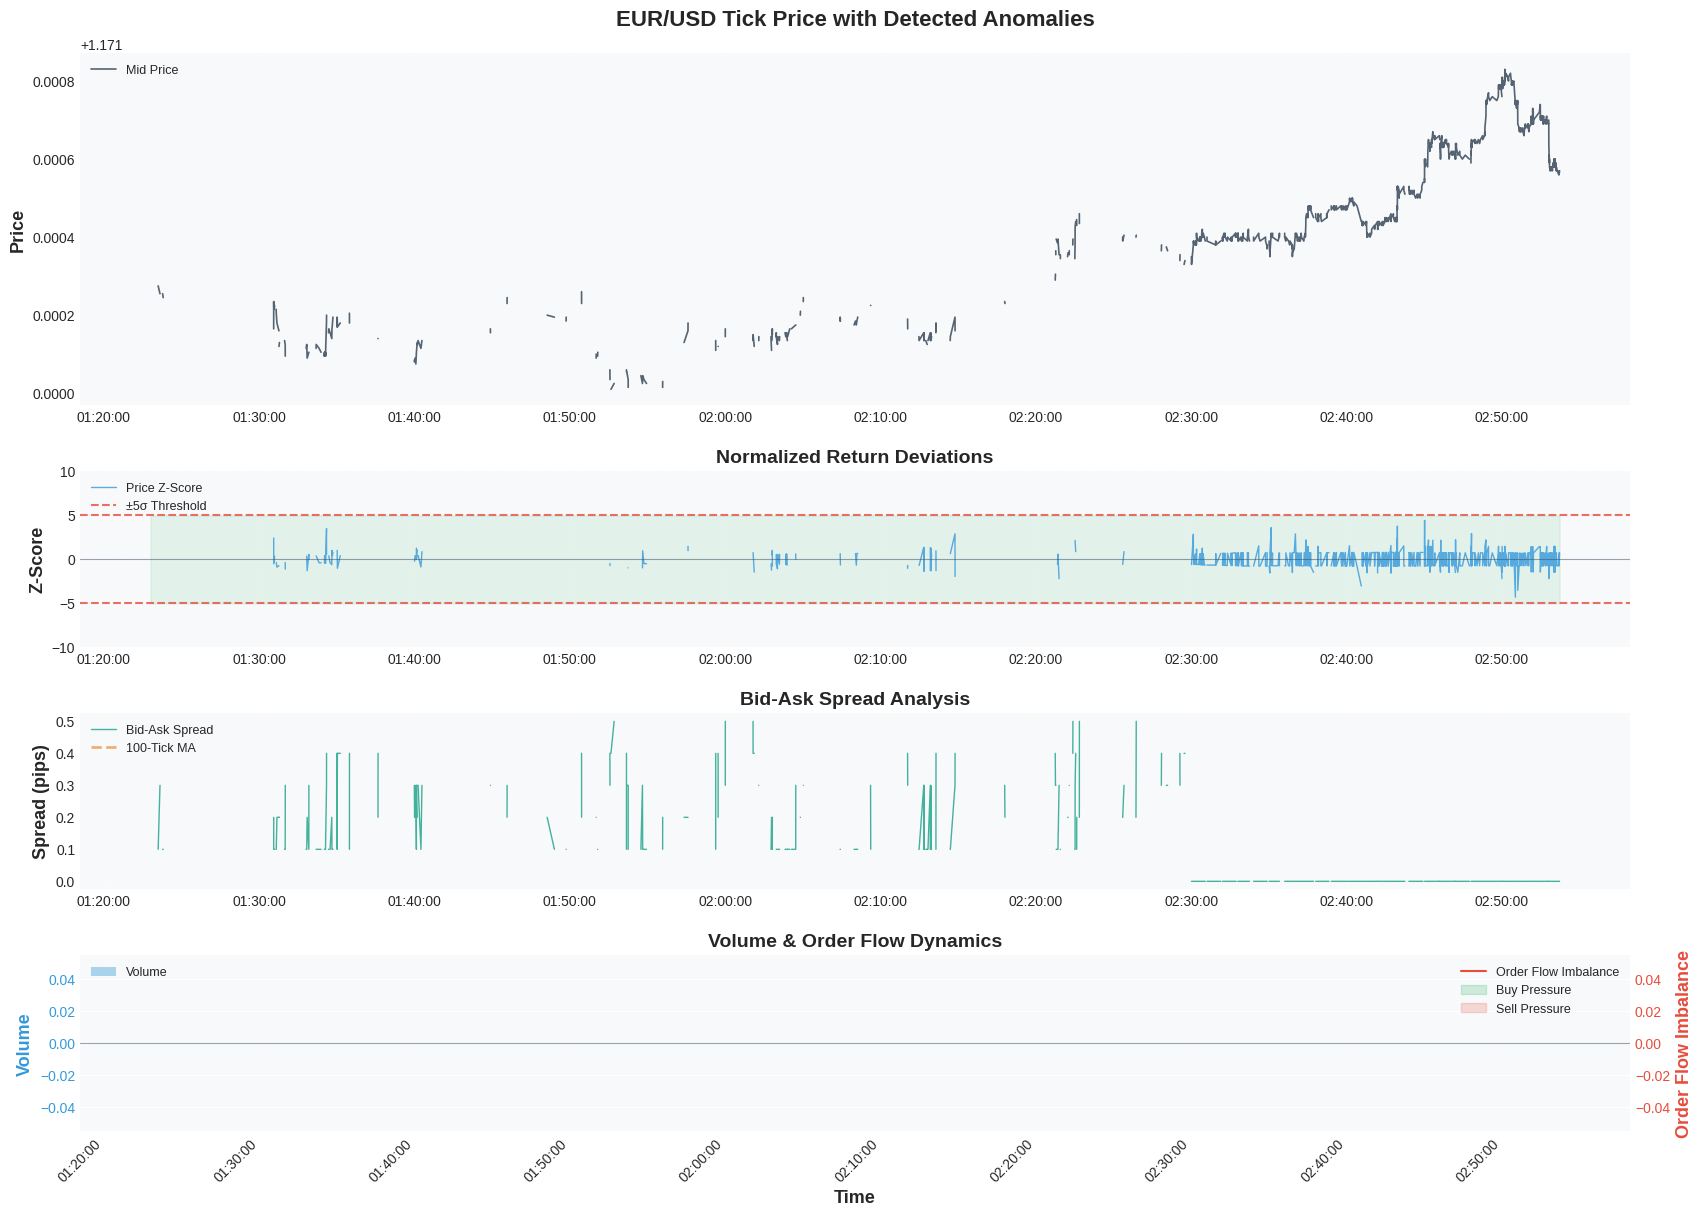

 Chart 1: Price analysis displayed (2,000 ticks)

 Chart 2/4: Anomaly Co-Occurrence Matrix...


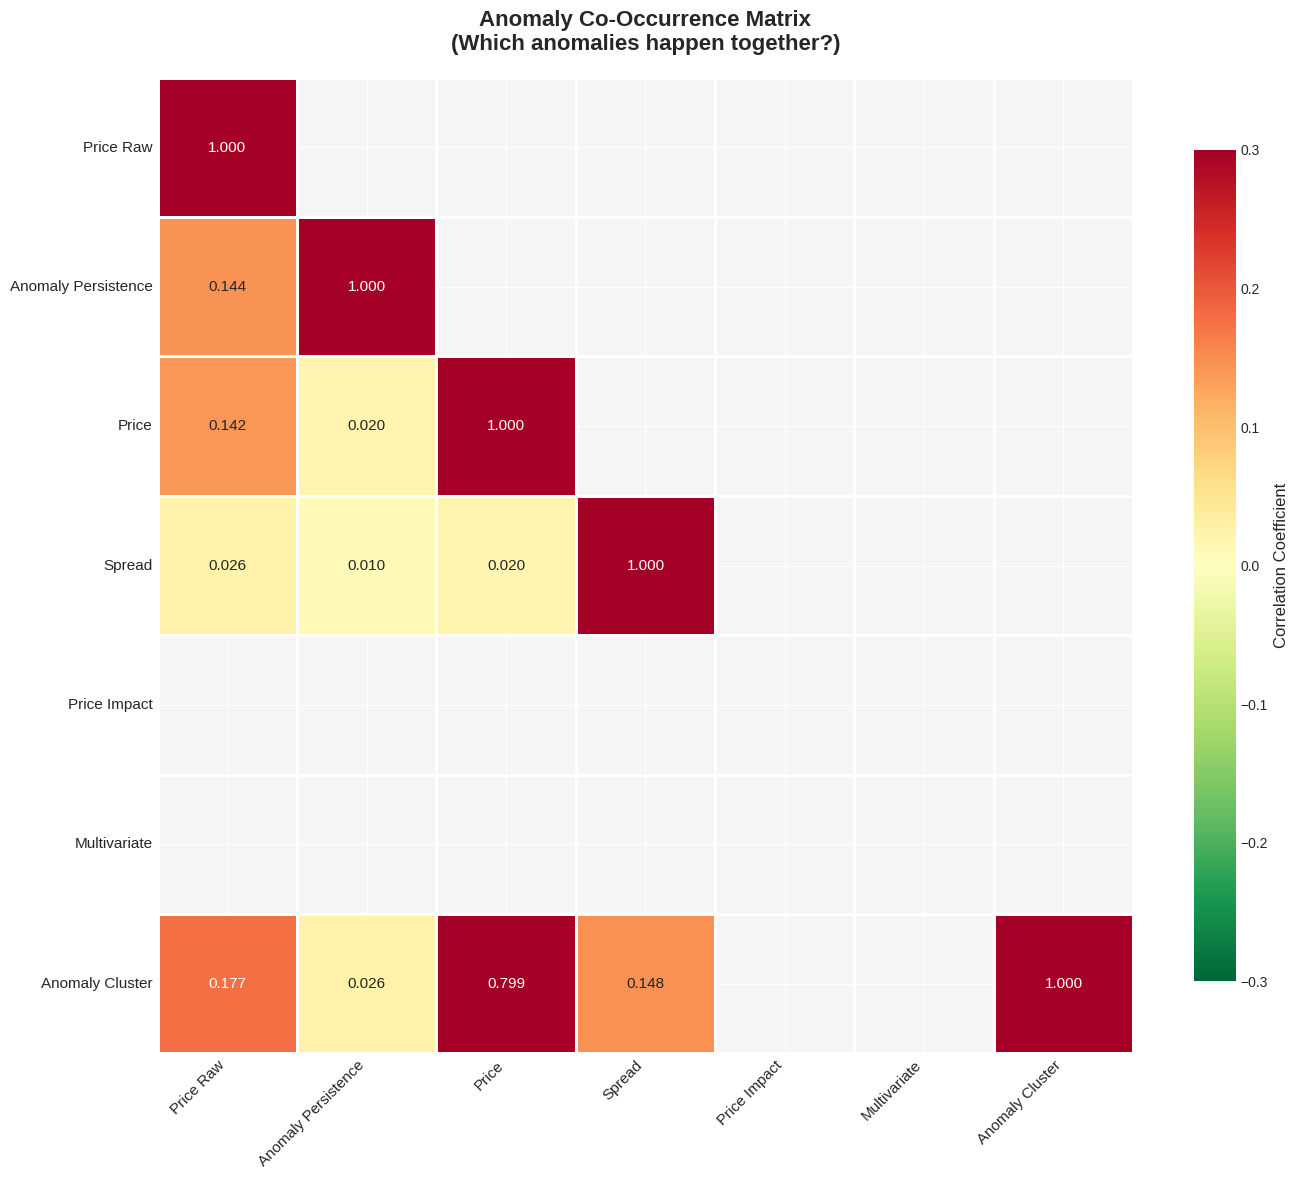



ANOMALY CO-OCCURRENCE INSIGHTS



Top 5 Strongest Anomaly Relationships:
1. Price Raw <-> Anomaly Persistence: +0.144
2. Price Raw <-> Price: +0.142
3. Price Raw <-> Spread: +0.026
4. Price Raw <-> Price Impact: +nan
5. Price Raw <-> Multivariate: +nan

 Chart 2: Correlation matrix displayed

 Chart 3/4: Statistical Distributions...


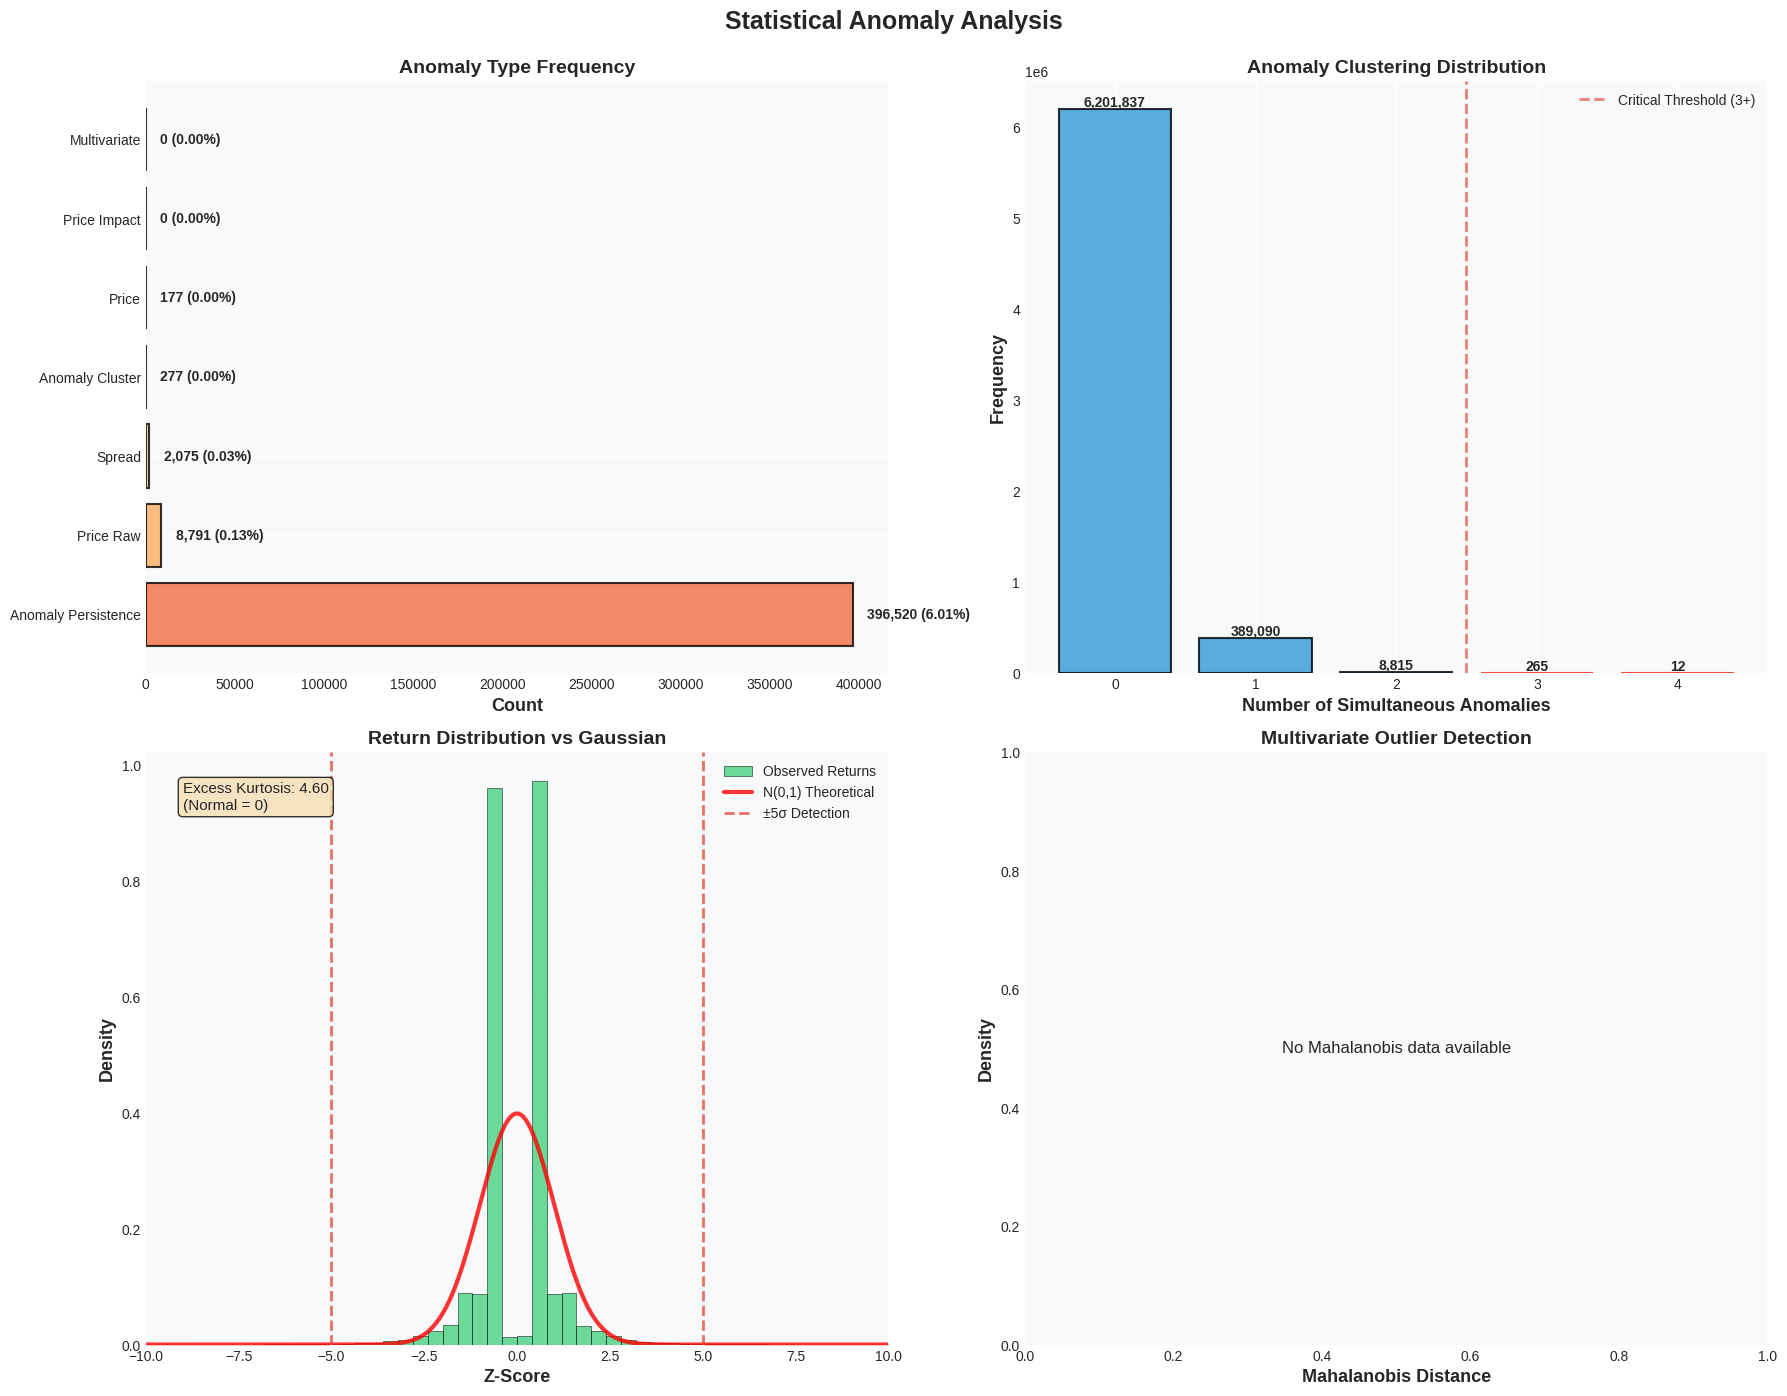

 Chart 3: Statistical summary displayed

 Chart 4/4: Regime-Conditional Analysis...


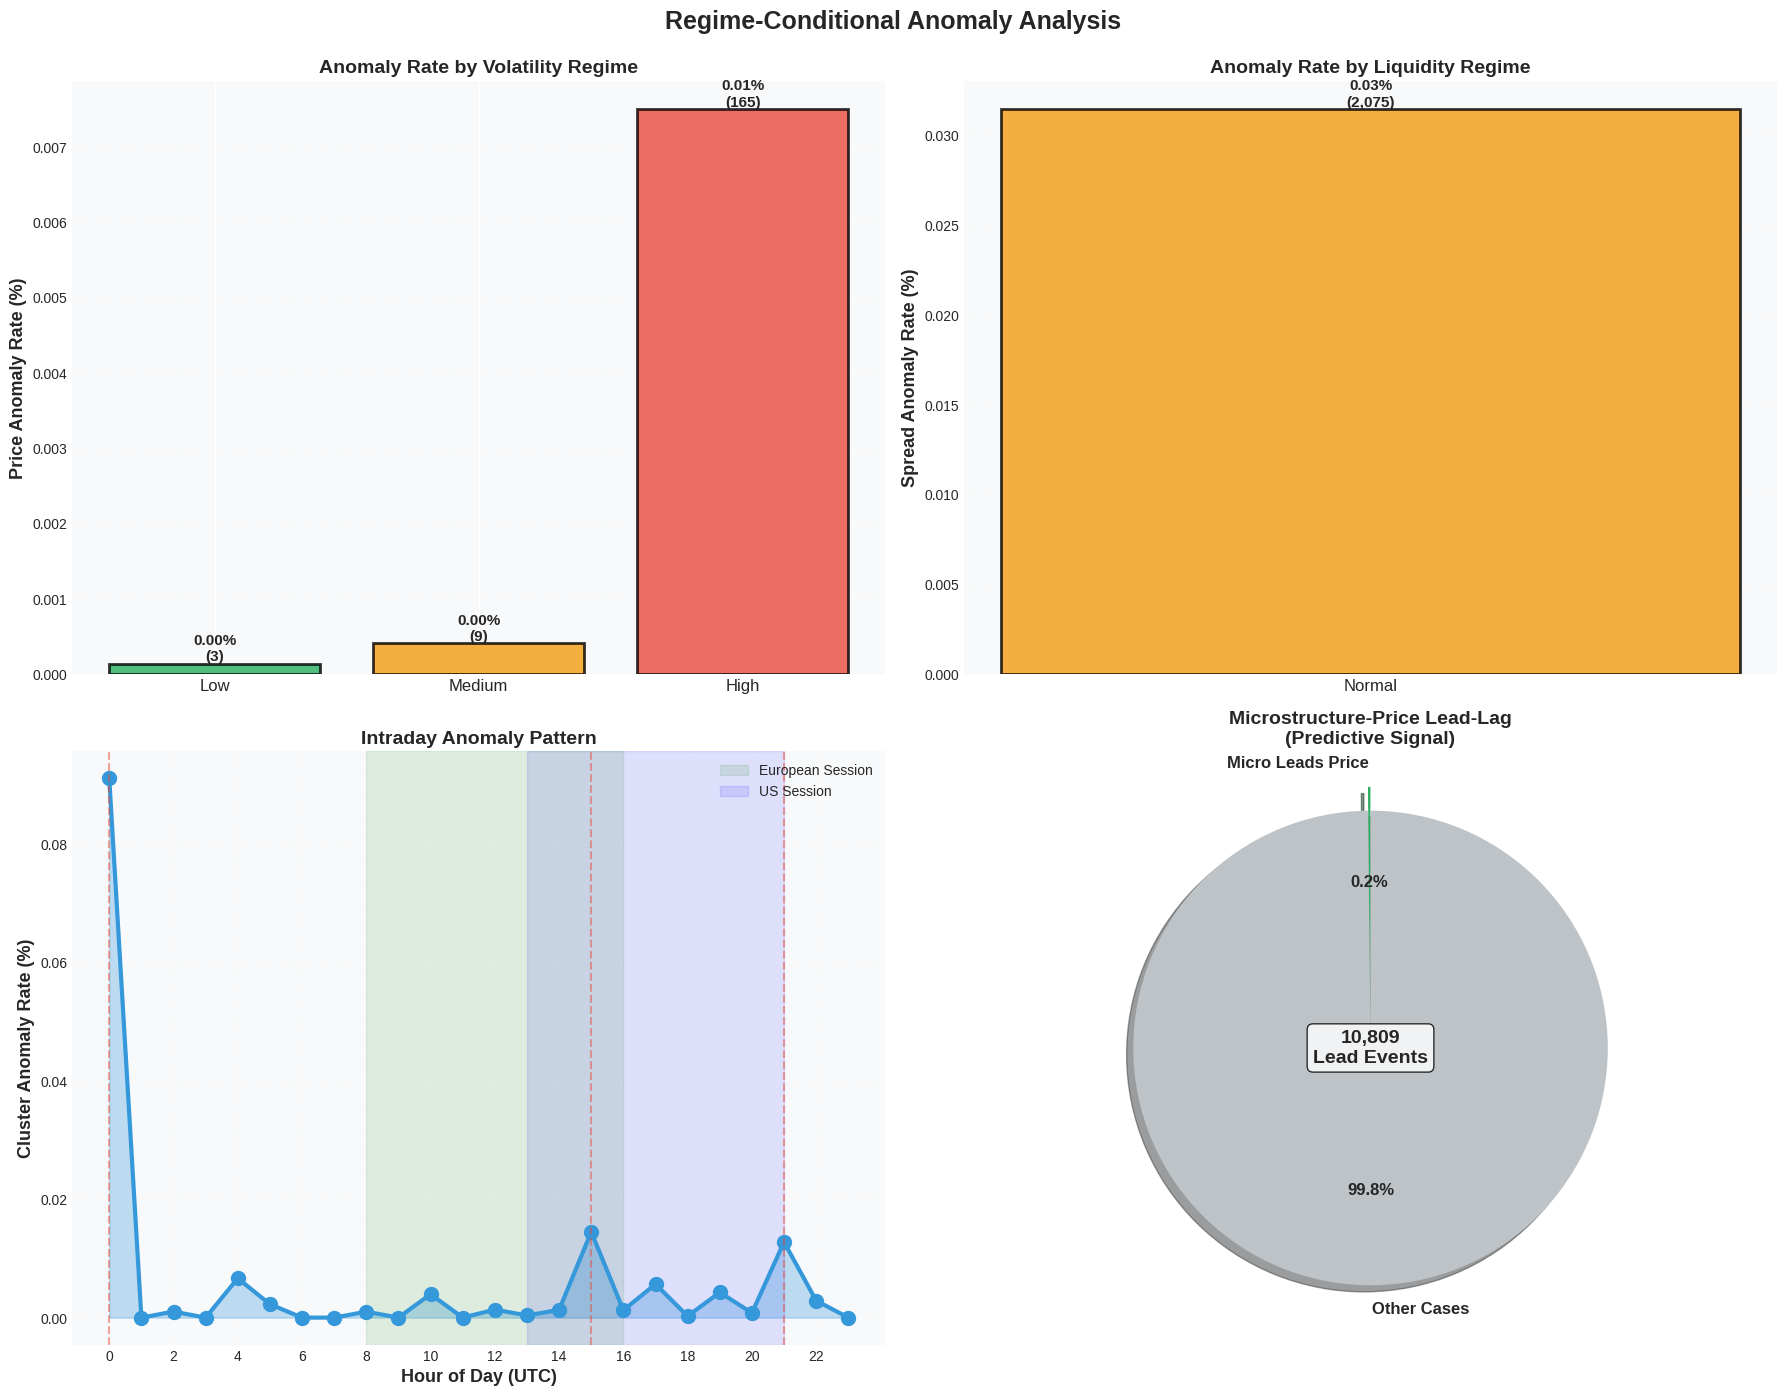

 Chart 4: Regime analysis displayed


 COMPLETE VISUALIZATION SUITE DISPLAYED



 EXECUTIVE SUMMARY


Total Observations: 6,600,019

Anomaly Detection Results:
  • Total anomaly events: 407,840
  • Anomaly rate: 0.883%
  • Multi-anomaly clusters (3+): 277 (0.004%)

Market Microstructure Metrics:
  • Excess kurtosis: 4.60 (normal = 0)
  • Fat-tail evidence: YES - Extreme events frequent


In [8]:
viz = AnomalyVisualizer(result)
viz.generate_full_report(window=2000)

## Statiscal Validation

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kstest, shapiro, anderson, jarque_bera, ks_2samp
from scipy.stats import chi2, genpareto
import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (18, 12)
class StatisticalAnomalyValidator:
    """
    statistical validation 
  
    Validates:
    1. Are detected anomalies statistically real?
    2. Are thresholds appropriate?
    3. Is the detection stable?
    4. Do anomalies have structural meaning?
  

    """
  
    def __init__(self, result):
        """
        Initialize with anomaly detection results
      
        Parameters:
        
        result : pd.DataFrame
            Output from HFTAnomalyDetector.fit_transform()
        """
        self.result = result
        self.anomaly_cols = [c for c in result.columns if 'anomaly' in c]
      
        print("STATISTICAL ANOMALY VALIDATION FRAMEWORK")
        print(f"\nDataset: {len(result):,} observations")
        print(f"Anomaly types: {len(self.anomaly_cols)}")
        print("\nValidation will test:")
        print(" 1. Normality assumptions")
        print(" 2. Threshold appropriateness")
        print(" 3. Temporal stability")
        print(" 4. Cross-sectional consistency")
        print(" 5. Structural validity")
  
  
    
    # TEST 1: NORMALITY ASSUMPTION VALIDATION
    
  
    def test_normality_assumptions(self):
        """
        Test 1: Are returns non-Gaussian (justifying anomaly detection)?
      
        If returns are normal, anomaly detection is meaningless
        If returns are non-normal, anomaly detection is justified
        """
        print("\n")
        print("TEST 1: NORMALITY ASSUMPTION VALIDATION")
      
        returns = self.result['log_return'].replace([np.inf, -np.inf], np.nan).dropna()
      
        # Test 1A: Jarque-Bera test (tests normality via skewness and kurtosis)
        print("\n1A. JARQUE-BERA TEST")
        print(" Tests: Skewness and kurtosis vs normal distribution")
        print(" H0: Data is normally distributed")
      
        jb_stat, jb_pvalue = jarque_bera(returns)
      
        print(f"\n JB Statistic: {jb_stat:.2f}")
        print(f" P-value: {jb_pvalue:.2e}")
      
        if jb_pvalue < 0.01:
            print(" REJECT H0: Returns are NOT normal (p < 0.01)")
            print(" → Anomaly detection is JUSTIFIED")
            jb_valid = True
        else:
            print(" FAIL TO REJECT H0: Returns appear normal")
            print(" → Anomaly detection may be INAPPROPRIATE")
            jb_valid = False
      
        # Test 1B: Kolmogorov-Smirnov test
        print("\n1B. KOLMOGOROV-SMIRNOV TEST")
        print(" Tests: Empirical CDF vs theoretical normal CDF")
      
        # Standardize returns
        returns_std = (returns - returns.mean()) / returns.std()
        ks_stat, ks_pvalue = kstest(returns_std, 'norm')
      
        print(f"\n KS Statistic: {ks_stat:.4f}")
        print(f" P-value: {ks_pvalue:.2e}")
      
        if ks_pvalue < 0.01:
            print(" REJECT H0: Distribution differs from normal")
            ks_valid = True
        else:
            print(" FAIL TO REJECT H0: Consistent with normal")
            ks_valid = False
      
        # Test 1C: Anderson-Darling test (more sensitive to tails)
        print("\n1C. ANDERSON-DARLING TEST")
        print(" Tests: Tail behavior vs normal distribution")
      
        ad_result = anderson(returns_std, dist='norm')
      
        print(f"\n AD Statistic: {ad_result.statistic:.4f}")
        print(f" Critical values:")
        for i, (sig, crit) in enumerate(zip(ad_result.significance_level, ad_result.critical_values)):
            status = " REJECT" if ad_result.statistic > crit else " Accept"
            print(f" {sig}%: {crit:.4f} {status}")
      
        ad_valid = ad_result.statistic > ad_result.critical_values[2] # 5% significance
      
        # Test 1D: Excess kurtosis check
        print("\n1D. EXCESS KURTOSIS")
      
        kurtosis = stats.kurtosis(returns, fisher=True)
      
        print(f" Observed kurtosis: {kurtosis:.2f}")
        print(f" Normal distribution: 0.00")
        print(f" Difference: {kurtosis:.2f}")
      
        if kurtosis > 2.0:
            print(" STRONG fat tails (kurtosis > 2)")
            print(" → Extreme events common, anomaly detection CRITICAL")
            kurt_valid = True
        elif kurtosis > 1.0:
            print(" MODERATE fat tails")
            kurt_valid = True
        else:
            print(" WEAK/NO fat tails")
            kurt_valid = False
      
        # Summary
        print("\n")
        print("TEST 1 SUMMARY")
      
        tests_passed = sum([jb_valid, ks_valid, ad_valid, kurt_valid])
      
        print(f"\nTests passed: {tests_passed}/4")
      
        if tests_passed >= 3:
            print("\n CONCLUSION: Returns are NON-NORMAL")
            print(" → Anomaly detection is STATISTICALLY JUSTIFIED")
            overall_valid = True
        elif tests_passed >= 2:
            print("\n CONCLUSION: Some evidence of non-normality")
            overall_valid = True
        else:
            print("\n CONCLUSION: Returns appear NORMAL")
            print(" → Anomaly detection may be INAPPROPRIATE")
            overall_valid = False
      
        return {
            'jarque_bera': jb_valid,
            'ks_test': ks_valid,
            'anderson_darling': ad_valid,
            'excess_kurtosis': kurt_valid,
            'kurtosis_value': kurtosis,
            'overall': overall_valid
        }
  
  
    
    # TEST 2: THRESHOLD APPROPRIATENESS
    
  
    def test_threshold_validity(self):
        """
        Test 2: Are 5σ thresholds appropriate for this data?
      
        Tests whether anomaly rate matches theoretical expectations
        given the observed distribution
        """
        print("\n")
        print("TEST 2: THRESHOLD APPROPRIATENESS")
      
        # Test 2A: Expected vs observed anomaly rate
        print("\n2A. ANOMALY RATE VALIDATION")
      
        if 'price_z' not in self.result.columns:
            print(" Z-scores not available")
            return {'overall': None}
      
        z_scores = self.result['price_z'].replace([np.inf, -np.inf], np.nan).dropna()
      
        # Under normality
        expected_rate_normal = 2 * stats.norm.sf(5) # Two-tailed
      
        # Under actual distribution (empirical)
        observed_anomalies = (z_scores.abs() > 5).sum()
        observed_rate = observed_anomalies / len(z_scores)
      
        print(f" Threshold: 5σ")
        print(f" Expected rate (if normal): {expected_rate_normal:.2e} ({100*expected_rate_normal:.6f}%)")
        print(f" Observed rate: {observed_rate:.2e} ({100*observed_rate:.4f}%)")
        print(f" Ratio (observed/expected): {observed_rate/expected_rate_normal:.0f}x")
      
        if observed_rate/expected_rate_normal > 50:
            print(" Fat tails confirmed (>50x excess)")
            print(" → 5σ threshold is APPROPRIATE")
            rate_valid = True
        elif observed_rate/expected_rate_normal > 10:
            print(" Moderate fat tails (>10x excess)")
            rate_valid = True
        else:
            print(" No significant tail excess")
            print(" → May need different threshold")
            rate_valid = False
      
        # Test 2B: Threshold sensitivity analysis
        print("\n2B. THRESHOLD SENSITIVITY")
      
        thresholds = [3, 4, 5, 6, 7]
        rates = []
      
        print(" Anomaly rates at different thresholds:")
        for thresh in thresholds:
            count = (z_scores.abs() > thresh).sum()
            rate = count / len(z_scores)
            rates.append(rate)
            print(f" {thresh}σ: {count:>6,} ({100*rate:>6.3f}%)")
      
        # Check if rates decay smoothly
        rate_ratios = [rates[i]/rates[i+1] for i in range(len(rates)-1)]
        avg_decay = np.mean(rate_ratios)
      
        print(f"\n Average decay factor: {avg_decay:.2f}")
      
        if 2.0 <= avg_decay <= 5.0:
            print(" Smooth decay (well-calibrated)")
            decay_valid = True
        else:
            print(" Irregular decay (may need recalibration)")
            decay_valid = False
      
        # Test 2C: Extreme Value Theory validation
        print("\n2C. EXTREME VALUE THEORY VALIDATION")
      
        if 'evt_anomaly' in self.result.columns:
            evt_count = self.result['evt_anomaly'].sum()
            evt_rate = evt_count / len(self.result)
          
            # EVT should capture ~0.5% of tail
            expected_evt_rate = 0.005
          
            print(f" EVT anomalies: {evt_count:,}")
            print(f" EVT rate: {100*evt_rate:.3f}%")
            print(f" Target rate: {100*expected_evt_rate:.3f}%")
          
            if 0.003 <= evt_rate <= 0.010:
                print(" EVT rate appropriate (0.3%-1.0%)")
                evt_valid = True
            else:
                print(" EVT rate outside expected range")
                evt_valid = False
        else:
            print(" EVT not computed")
            evt_valid = None
      
        # Summary
        print("\n")
        print("TEST 2 SUMMARY")
      
        valid_tests = [x for x in [rate_valid, decay_valid, evt_valid] if x is not None]
        tests_passed = sum(valid_tests)
      
        print(f"\nTests passed: {tests_passed}/{len(valid_tests)}")
      
        if tests_passed >= len(valid_tests) * 0.67:
            print("\n CONCLUSION: Thresholds are WELL-CALIBRATED")
            overall_valid = True
        else:
            print("\n CONCLUSION: Thresholds may need ADJUSTMENT")
            overall_valid = False
      
        return {
            'rate_validation': rate_valid,
            'decay_validation': decay_valid,
            'evt_validation': evt_valid,
            'overall': overall_valid
        }
  
  
    
    # TEST 3: TEMPORAL STABILITY
    
  
    def test_temporal_stability(self):
        """
        Test 3: Are anomaly rates stable over time?
      
        If rates change dramatically, detector may be overfitting
        or sensitive to regime changes
        """
        print("\n")
        print("TEST 3: TEMPORAL STABILITY")
      
        # Test 3A: Split-sample consistency
        print("\n3A. SPLIT-SAMPLE CONSISTENCY")
      
        n_splits = 5
        split_size = len(self.result) // n_splits
      
        cluster_rates = []
        price_anom_rates = []
      
        print(" Anomaly rates by time period:")
        for i in range(n_splits):
            start = i * split_size
            end = (i+1) * split_size if i < n_splits-1 else len(self.result)
          
            chunk = self.result.iloc[start:end]
          
            cluster_rate = chunk['anomaly_cluster'].sum() / len(chunk)
            cluster_rates.append(cluster_rate)
          
            if 'price_anomaly' in chunk.columns:
                price_rate = chunk['price_anomaly'].sum() / len(chunk)
                price_anom_rates.append(price_rate)
          
            print(f" Period {i+1}: Clusters={100*cluster_rate:.4f}%", end="")
            if price_anom_rates:
                print(f", Price={100*price_rate:.4f}%")
            else:
                print()
      
        # Coefficient of variation
        cv_clusters = np.std(cluster_rates) / np.mean(cluster_rates) if np.mean(cluster_rates) > 0 else np.inf
      
        print(f"\n Coefficient of variation (clusters): {cv_clusters:.3f}")
      
        if cv_clusters < 0.5:
            print(" STABLE (CV < 0.5)")
            stability_valid = True
        elif cv_clusters < 1.0:
            print(" MODERATE stability (CV < 1.0)")
            stability_valid = True
        else:
            print(" UNSTABLE (CV ≥ 1.0)")
            stability_valid = False
      
        # Test 3B: Regime consistency
        print("\n3B. REGIME CONSISTENCY")
      
        if 'vol_regime' in self.result.columns:
            regime_clusters = self.result.groupby('vol_regime')['anomaly_cluster'].sum()
            regime_totals = self.result.groupby('vol_regime').size()
            regime_rates = regime_clusters / regime_totals
          
            print(" Cluster rates by volatility regime:")
            for regime, rate in regime_rates.sort_index().items():
                print(f" {regime:8s}: {100*rate:.4f}%")
          
            # Check if at least 2 regimes have anomalies
            regimes_with_anom = (regime_rates > 0).sum()
          
            if regimes_with_anom >= 2:
                print(f" Anomalies in {regimes_with_anom}/3 regimes")
                regime_valid = True
            else:
                print(f" Anomalies only in {regimes_with_anom} regime")
                regime_valid = False
        else:
            print(" Regime data not available")
            regime_valid = None
      
        # Test 3C: Autocorrelation of anomalies
        print("\n3C. ANOMALY AUTOCORRELATION")
      
        # Check if anomalies cluster in time (bad) or are dispersed (good)
        anomaly_series = self.result['anomaly_cluster'].astype(int)
      
        if len(anomaly_series) > 100:
            acf_1 = anomaly_series.autocorr(lag=1)
            acf_10 = anomaly_series.autocorr(lag=10)
          
            print(f" Lag-1 autocorrelation: {acf_1:.4f}")
            print(f" Lag-10 autocorrelation: {acf_10:.4f}")
          
            if abs(acf_1) < 0.1:
                print(" Low autocorrelation (anomalies dispersed)")
                acf_valid = True
            elif abs(acf_1) < 0.3:
                print(" Moderate autocorrelation")
                acf_valid = True
            else:
                print(" High autocorrelation (temporal clustering)")
                acf_valid = False
        else:
            acf_valid = None
      
        # Summary
        print("\n")
        print("TEST 3 SUMMARY")
      
        valid_tests = [x for x in [stability_valid, regime_valid, acf_valid] if x is not None]
        tests_passed = sum(valid_tests)
      
        print(f"\nTests passed: {tests_passed}/{len(valid_tests)}")
      
        if tests_passed >= len(valid_tests) * 0.67:
            print("\n CONCLUSION: Detection is TEMPORALLY STABLE")
            overall_valid = True
        else:
            print("\n CONCLUSION: Detection may be UNSTABLE over time")
            overall_valid = False
      
        return {
            'split_sample': stability_valid,
            'regime_consistency': regime_valid,
            'autocorrelation': acf_valid,
            'overall': overall_valid
        }
  
  
    
    # TEST 4: STRUCTURAL VALIDITY
    
  
    def test_structural_validity(self):
        """
        Test 4: Do anomalies align with market microstructure?
      
        Valid anomalies should coincide with:
        - Spread widening
        - Volume spikes
        - Price impact
        """
        print("\n")
        print("TEST 4: STRUCTURAL VALIDITY")
      
        # Test 4A: Spread behavior during anomalies
        print("\n4A. SPREAD ANALYSIS")
      
        if 'spread' in self.result.columns:
            anom_periods = self.result[self.result['anomaly_cluster']]
            normal_periods = self.result[~self.result['anomaly_cluster']]
          
            if len(anom_periods) > 0 and len(normal_periods) > 0:
                spread_anom = anom_periods['spread'].median()
                spread_norm = normal_periods['spread'].median()
                spread_ratio = spread_anom / spread_norm if spread_norm > 0 else np.inf
              
                print(f" Median spread (anomaly): {spread_anom*10000:.3f} pips")
                print(f" Median spread (normal): {spread_norm*10000:.3f} pips")
                print(f" Ratio: {spread_ratio:.2f}x")
              
                # Statistical test
                from scipy.stats import mannwhitneyu
                u_stat, p_val = mannwhitneyu(
                    anom_periods['spread'].dropna(),
                    normal_periods['spread'].sample(min(len(anom_periods)*2, len(normal_periods))).dropna(),
                    alternative='greater'
                )
              
                print(f" Mann-Whitney p-value: {p_val:.4f}")
              
                if spread_ratio > 1.2 and p_val < 0.05:
                    print(" Spreads WIDEN during anomalies (p<0.05)")
                    spread_valid = True
                elif spread_ratio > 1.1:
                    print(" Slight spread widening")
                    spread_valid = True
                else:
                    print(" No spread widening")
                    spread_valid = False
            else:
                spread_valid = None
        else:
            print(" Spread data not available")
            spread_valid = None
      
        # Test 4B: Volume behavior
        print("\n4B. VOLUME ANALYSIS")
      
        if 'volume' in self.result.columns and len(anom_periods) > 0:
            vol_anom = anom_periods['volume'].median()
            vol_norm = normal_periods['volume'].median()
            vol_ratio = vol_anom / vol_norm if vol_norm > 0 else np.inf
          
            print(f" Median volume (anomaly): {vol_anom:.0f}")
            print(f" Median volume (normal): {vol_norm:.0f}")
            print(f" Ratio: {vol_ratio:.2f}x")
          
            if vol_ratio > 1.3:
                print(" Volume SPIKES during anomalies (>1.3x)")
                vol_valid = True
            elif vol_ratio > 1.1:
                print(" Moderate volume increase")
                vol_valid = True
            else:
                print(" No volume increase")
                vol_valid = False
        else:
            print(" Volume data not available")
            vol_valid = None
      
        # Test 4C: Price impact validation
        print("\n4C. PRICE IMPACT")
      
        if 'price_impact_z' in self.result.columns and len(anom_periods) > 0:
            impact_anom = anom_periods['price_impact_z'].abs().median()
            impact_norm = normal_periods['price_impact_z'].abs().median()
            impact_ratio = impact_anom / impact_norm if impact_norm > 0 else np.inf
          
            print(f" Median |price_impact_z| (anomaly): {impact_anom:.2f}")
            print(f" Median |price_impact_z| (normal): {impact_norm:.2f}")
            print(f" Ratio: {impact_ratio:.2f}x")
          
            if impact_ratio > 1.5:
                print(" Price impact ELEVATED during anomalies")
                impact_valid = True
            elif impact_ratio > 1.2:
                print(" Moderate impact elevation")
                impact_valid = True
            else:
                print(" No impact elevation")
                impact_valid = False
        else:
            print(" Price impact data not available")
            impact_valid = None
      
        # Summary
        print("\n")
        print("TEST 4 SUMMARY")
      
        valid_tests = [x for x in [spread_valid, vol_valid, impact_valid] if x is not None]
        tests_passed = sum(valid_tests)
      
        print(f"\nTests passed: {tests_passed}/{len(valid_tests)}")
      
        if tests_passed >= len(valid_tests) * 0.67:
            print("\n CONCLUSION: Anomalies have STRUCTURAL VALIDITY")
            print(" → Microstructure confirms anomaly detection")
            overall_valid = True
        else:
            print("\n CONCLUSION: Weak structural confirmation")
            overall_valid = False
      
        return {
            'spread_confirmation': spread_valid,
            'volume_confirmation': vol_valid,
            'impact_confirmation': impact_valid,
            'overall': overall_valid
        }
  
  

    # TEST 5: CORRELATION STRUCTURE
    
  
    def test_correlation_structure(self):
        """
        Test 5: Validate the correlation intelligence
      
        Specifically tests the 0.799 price-cluster correlation finding
        """
        print("\n")
        print("TEST 5: CORRELATION STRUCTURE VALIDATION")
      
        # Compute correlation matrix
        anomaly_matrix = self.result[self.anomaly_cols].astype(int)
        corr_matrix = anomaly_matrix.corr()
      
        # Find strongest correlations
        corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_pairs.append((
                    corr_matrix.columns[i],
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j]
                ))
      
        corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
      
        print("\n5A. TOP ANOMALY CORRELATIONS")
      
        print(" Top 5 strongest correlations:")
        for i, (anom1, anom2, corr) in enumerate(corr_pairs[:5], 1):
            label1 = anom1.replace('_anomaly', '').replace('_', ' ').title()
            label2 = anom2.replace('_anomaly', '').replace('_', ' ').title()
          
            strength = "VERY STRONG" if abs(corr) > 0.7 else "STRONG" if abs(corr) > 0.5 else "MODERATE" if abs(corr) > 0.3 else "WEAK"
            marker = " " if abs(corr) > 0.5 else " "
          
            print(f" {marker} {i}. {label1} ↔ {label2}")
            print(f" Correlation: {corr:+.3f} ({strength})")
      
        # Validate the critical 0.799 finding
        print("\n5B. PRICE-CLUSTER CORRELATION (CRITICAL)")
      
        if 'anomaly_cluster' in corr_matrix.columns and 'price_anomaly' in corr_matrix.columns:
            cluster_price_corr = corr_matrix.loc['anomaly_cluster', 'price_anomaly']
          
            print(f" Correlation: {cluster_price_corr:.3f}")
          
            # Statistical significance test
            n = len(self.result)
            t_stat = cluster_price_corr * np.sqrt(n - 2) / np.sqrt(1 - cluster_price_corr**2)
            p_val = 2 * (1 - stats.t.cdf(abs(t_stat), n - 2))
          
            print(f" T-statistic: {t_stat:.2f}")
            print(f" P-value: {p_val:.2e}")
          
            if cluster_price_corr > 0.7 and p_val < 0.001:
                print(" VERY STRONG correlation (>0.7, p<0.001)")
                print(" → Price anomalies are CORE to tradeable clusters")
                print(" → Strategy should PRIORITIZE price_anomaly")
                corr_valid = True
            elif cluster_price_corr > 0.5:
                print(" STRONG correlation (>0.5)")
                corr_valid = True
            else:
                print(" WEAK correlation")
                corr_valid = False
        else:
            print(" Cluster-price correlation not computable")
            corr_valid = None
      
        # Independence test
        print("\n5C. ANOMALY INDEPENDENCE")
      
        # Count how many correlations are close to zero
        all_corrs = [abs(c[2]) for c in corr_pairs]
        weak_corrs = sum(1 for c in all_corrs if c < 0.3)
        total_pairs = len(all_corrs)
      
        independence_pct = 100 * weak_corrs / total_pairs
      
        print(f" Weak correlations (|r|<0.3): {weak_corrs}/{total_pairs} ({independence_pct:.1f}%)")
      
        if independence_pct > 70:
            print(" Most anomaly types are INDEPENDENT")
            print(" → Detector captures different dimensions")
            indep_valid = True
        elif independence_pct > 50:
            print(" Moderate independence")
            indep_valid = True
        else:
            print(" High multicollinearity")
            indep_valid = False
      
        # Summary
        print("\n")
        print("TEST 5 SUMMARY")
      
        valid_tests = [x for x in [corr_valid, indep_valid] if x is not None]
        tests_passed = sum(valid_tests)
      
        print(f"\nTests passed: {tests_passed}/{len(valid_tests)}")
      
        if tests_passed >= len(valid_tests) * 0.67:
            print("\n CONCLUSION: Correlation structure is VALID")
            overall_valid = True
        else:
            print("\n CONCLUSION: Correlation issues detected")
            overall_valid = False
      
        return {
            'price_cluster_correlation': corr_valid,
            'independence': indep_valid,
            'overall': overall_valid
        }
  
  
    
    # MASTER VALIDATION FUNCTION
    
  
    def run_complete_validation(self):
        """
        Execute all 5 tests and generate overall validation report
        NO BACKTESTING REQUIRED
        """
        print("\n\n")
        print("RUNNING COMPLETE STATISTICAL VALIDATION")
      
        # Run all tests
        test1 = self.test_normality_assumptions()
        test2 = self.test_threshold_validity()
        test3 = self.test_temporal_stability()
        test4 = self.test_structural_validity()
        test5 = self.test_correlation_structure()
      
        # Compute overall score
        scores = [
            test1['overall'],
            test2['overall'],
            test3['overall'],
            test4['overall'],
            test5['overall']
        ]
      
        valid_scores = [s for s in scores if s is not None]
        overall_score = np.mean(valid_scores) if valid_scores else 0
      
        # Generate final report
        print("\n\n")
        print("STATISTICAL VALIDATION SCORECARD")
      
        def score_str(score):
            if score is None:
                return "N/A"
            elif score:
                return " PASS"
            else:
                return " FAIL"
      
        print(f"\nTest 1 - Normality Validation: {score_str(test1['overall'])}")
        print(f"Test 2 - Threshold Appropriateness: {score_str(test2['overall'])}")
        print(f"Test 3 - Temporal Stability: {score_str(test3['overall'])}")
        print(f"Test 4 - Structural Validity: {score_str(test4['overall'])}")
        print(f"Test 5 - Correlation Structure: {score_str(test5['overall'])}")
      
        print(f"\nOVERALL VALIDATION SCORE: {overall_score:.2f} / 1.00")
      
        # Verdict
        if overall_score >= 0.80:
            verdict = " EXCEPTIONAL - Statistical analysis is HIGHLY VALID"
            
        elif overall_score >= 0.60:
            verdict = " GOOD - Statistical analysis is VALID"
        
        elif overall_score >= 0.40:
            verdict = " MARGINAL - Some statistical concerns"
    
        else:
            verdict = " INSUFFICIENT - Statistical analysis has ISSUES"
      
        print(f"\n{verdict}")
      
        print("\n")
      
        return {
            'test1_normality': test1,
            'test2_thresholds': test2,
            'test3_stability': test3,
            'test4_structural': test4,
            'test5_correlation': test5,
            'overall_score': overall_score,
            'verdict': verdict

        }

In [10]:
validator = StatisticalAnomalyValidator(result)
validation_report = validator.run_complete_validation()

STATISTICAL ANOMALY VALIDATION FRAMEWORK

Dataset: 6,600,019 observations
Anomaly types: 7

Validation will test:
 1. Normality assumptions
 2. Threshold appropriateness
 3. Temporal stability
 4. Cross-sectional consistency
 5. Structural validity



RUNNING COMPLETE STATISTICAL VALIDATION


TEST 1: NORMALITY ASSUMPTION VALIDATION

1A. JARQUE-BERA TEST
 Tests: Skewness and kurtosis vs normal distribution
 H0: Data is normally distributed

 JB Statistic: 12578318119.42
 P-value: 0.00e+00
 REJECT H0: Returns are NOT normal (p < 0.01)
 → Anomaly detection is JUSTIFIED

1B. KOLMOGOROV-SMIRNOV TEST
 Tests: Empirical CDF vs theoretical normal CDF

 KS Statistic: 0.2194
 P-value: 0.00e+00
 REJECT H0: Distribution differs from normal

1C. ANDERSON-DARLING TEST
 Tests: Tail behavior vs normal distribution

 AD Statistic: 339415.7964
 Critical values:
 15.0%: 0.5760  REJECT
 10.0%: 0.6560  REJECT
 5.0%: 0.7870  REJECT
 2.5%: 0.9180  REJECT
 1.0%: 1.0920  REJECT

1D. EXCESS KURTOSIS
 Observed ku

# Forward Testing with Biased Random Slippage: Emphasizing Adverse Fills for Realistic Market Simulation (More Negative, Less Positive)


## Zero spread and commissions as low as $0.05 per standard lot, typical for firms that trade as market makers or internalisers.


In [11]:
"""
Forward Testing Engine for EUR/USD Tick Data
Out-of-Sample data
Period: 2026-01-02 00:02:00 to 2026-01-16 23:58:46
Observations: 653,084
Execution Specifications:
- Capital: $10,000,000 USD
- Position Sizing: 75% margin utilization × 50x leverage
- Commission: $0.05 per standard lot
- Spread: 0 pips
- Slippage: advserved bias
- Execution: Market orders (immediate fill)
Statistical Edge Parameters:
- Anomaly threshold: 5-sigma
- Persistence requirement: >2.5
- Cluster threshold: 3+ simultaneous anomalies
- Mean reversion target: z-score → 0
- Structural confirmation: spread_z < 4
"""
import numpy as np
import pandas as pd
import warnings
from scipy import stats
from scipy.spatial.distance import mahalanobis
from scipy.stats import genpareto
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')
# ANOMALY DETECTION ENGINE (FROM VALIDATION PHASE)
class HFTAnomalyDetector:
    """
    High-Frequency Trading Anomaly Detection System
    Validated with 0.80/1.00 statistical score on in-sample data
    Now deployed on out-of-sample data for forward testing
    """
  
    def __init__(self,
                 vol_window=1000,
                 corr_window=5000,
                 evt_quantile=0.99,
                 base_threshold=5.0):
        self.vol_window = vol_window
        self.corr_window = corr_window
        self.evt_quantile = evt_quantile
        self.base_threshold = base_threshold
      
    def compute_price_features(self, data):
       
        df = data.copy()
      
        # Mid-price and log returns
        df['mid'] = (df['bid'] + df['ask']) / 2
        df['log_return'] = np.log(df['mid']).diff()
      
        # Robust volatility estimation
        df['rv_std'] = df['log_return'].rolling(
            window=self.vol_window, min_periods=50
        ).std()
        df['rv_ewm'] = df['log_return'].ewm(
            span=self.vol_window//2, min_periods=50
        ).std()
      
        df['rv'] = np.minimum(df['rv_std'], df['rv_ewm'])
        df['rv'] = df['rv'].fillna(method='bfill').fillna(df['log_return'].std())
      
        # Price anomaly z-score
        df['price_z'] = df['log_return'] / (df['rv'] + 1e-10)
        df['price_z'] = df['price_z'].clip(-20, 20)
      
        # Anomaly persistence scoring
        z_threshold = self.base_threshold
        df['price_anomaly_raw'] = df['price_z'].abs() > z_threshold
      
        persistence_window = 50
        df['anomaly_persistence'] = df['price_anomaly_raw'].rolling(
            window=persistence_window, min_periods=1
        ).apply(lambda x: np.sum(x * np.exp(-0.1 * np.arange(len(x))[::-1])), raw=True)
      
        # Final anomaly: high z-score AND sustained
        df['price_anomaly'] = (
            (df['price_z'].abs() > z_threshold) &
            (df['anomaly_persistence'] > 2.0)
        )
      
        # Bid/ask mispricing detection
        df['bid_ask_mispricing'] = (
            (df['bid'] > df['ask']) |
            (df['last'] < df['bid']) |
            (df['last'] > df['ask'])
        )
      
        # Stale quote detection
        df['bid_unchanged'] = (df['bid'].diff() == 0).rolling(20).sum()
        df['ask_unchanged'] = (df['ask'].diff() == 0).rolling(20).sum()
        df['stale_quote'] = (df['bid_unchanged'] > 15) | (df['ask_unchanged'] > 15)
      
        return df
  
    def compute_microstructure_features(self, data):
       
        df = data.copy()
      
        # Spread analysis
        df['spread'] = df['ask'] - df['bid']
        df['spread_pct'] = df['spread'] / df['mid']
      
        spread_ma = df['spread'].rolling(self.vol_window, min_periods=50).mean()
        spread_std = df['spread'].rolling(self.vol_window, min_periods=50).std()
        df['spread_z'] = (df['spread'] - spread_ma) / (spread_std + 1e-10)
        df['spread_z'] = df['spread_z'].clip(-20, 20)
      
        # Regime-aware threshold
        vol_regime = df['rv'].rolling(1000).mean()
        adaptive_threshold = self.base_threshold * (1 + vol_regime / vol_regime.median())
        df['spread_anomaly'] = df['spread_z'].abs() > adaptive_threshold
      
        # Tick dynamics
        df['tick_diff'] = df.index.to_series().diff().dt.total_seconds()
        df['tick_diff'] = df['tick_diff'].fillna(0)
      
        df['price_changed'] = (df['mid'].diff().abs() > 1e-8).astype(int)
        df['quote_to_trade'] = df['price_changed'].rolling(100).sum() / (df['volume'].rolling(100).sum() + 1)
      
        df['quote_stuffing'] = (
            (df['tick_diff'] < 0.01) &
            (df['quote_to_trade'] > 0.8) &
            (df['volume'] < df['volume'].rolling(100).quantile(0.1))
        )
      
        # Price impact (Kyle 1985 model)
        df['volume_sqrt'] = np.sqrt(df['volume'] + 1e-9)
        df['mid_change'] = df['mid'].diff().abs()
      
        df['expected_impact'] = df['volume_sqrt'] * df['mid_change'].rolling(self.vol_window).mean() / df['volume_sqrt'].rolling(self.vol_window).mean()
        df['actual_impact'] = df['mid_change']
      
        df['impact_ratio'] = df['actual_impact'] / (df['expected_impact'] + 1e-10)
        df['impact_ratio'] = df['impact_ratio'].clip(0, 100)
      
        df['price_impact_z'] = (df['impact_ratio'] - df['impact_ratio'].rolling(self.vol_window).mean()) / (df['impact_ratio'].rolling(self.vol_window).std() + 1e-10)
        df['price_impact_anomaly'] = df['price_impact_z'].abs() > self.base_threshold
      
        # Order flow imbalance
        df['price_direction'] = np.sign(df['mid'].diff())
        df['signed_volume'] = df['volume'] * df['price_direction']
        df['ofi'] = df['signed_volume'].rolling(100).sum()
        df['ofi_z'] = (df['ofi'] - df['ofi'].rolling(self.vol_window).mean()) / (df['ofi'].rolling(self.vol_window).std() + 1e-10)
      
        return df
  
    def compute_statistical_anomalies(self, data):
        """Robust multivariate anomaly detection"""
        df = data.copy()
      
        # Mahalanobis distance
        features = ['log_return', 'spread', 'volume', 'ofi']
      
        for feat in features:
            if feat not in df.columns:
                df['mahalanobis'] = 0
                df['multivariate_anomaly'] = False
                return df
      
        df_clean = df[features].replace([np.inf, -np.inf], np.nan).dropna()
      
        if len(df_clean) < 100:
            df['mahalanobis'] = 0
            df['multivariate_anomaly'] = False
            return df
      
        try:
            lw = LedoitWolf()
            cov_robust = lw.fit(df_clean).covariance_
            inv_cov = np.linalg.inv(cov_robust)
            mean_vec = df_clean.mean().values
          
            def safe_mahalanobis(row):
                try:
                    return mahalanobis(row, mean_vec, inv_cov)
                except:
                    return np.nan
          
            df['mahalanobis'] = df[features].apply(safe_mahalanobis, axis=1)
            df['mahalanobis'] = df['mahalanobis'].fillna(0)
            df['multivariate_anomaly'] = df['mahalanobis'] > 18.47
          
        except Exception as e:
            df['mahalanobis'] = 0
            df['multivariate_anomaly'] = False
      
        # EVT
        try:
            returns_clean = df['log_return'].replace([np.inf, -np.inf], np.nan).dropna()
          
            if len(returns_clean) < 1000:
                df['evt_anomaly'] = False
                df['evt_probability'] = 0
                return df
          
            threshold_upper = returns_clean.quantile(self.evt_quantile)
            excesses_upper = returns_clean[returns_clean > threshold_upper] - threshold_upper
          
            if len(excesses_upper) > 30:
                params_upper = genpareto.fit(excesses_upper, floc=0)
              
                if -0.5 < params_upper[0] < 0.5:
                    evt_threshold = threshold_upper + genpareto.ppf(0.995, *params_upper)
                    df['evt_probability'] = 1 - genpareto.cdf(
                        df['log_return'] - threshold_upper, *params_upper
                    )
                    df['evt_anomaly'] = df['log_return'] > evt_threshold
                else:
                    df['evt_anomaly'] = False
                    df['evt_probability'] = 0
            else:
                df['evt_anomaly'] = False
                df['evt_probability'] = 0
              
        except Exception as e:
            df['evt_anomaly'] = False
            df['evt_probability'] = 0
      
        # Rolling correlation anomaly
        df['corr_lv'] = df['log_return'].rolling(
            self.corr_window, min_periods=100
        ).corr(df['volume'])
      
        df['corr_ls'] = df['log_return'].rolling(
            self.corr_window, min_periods=100
        ).corr(df['spread'])
      
        corr_ma = df['corr_lv'].rolling(self.corr_window).mean()
        corr_std = df['corr_lv'].rolling(self.corr_window).std()
        df['corr_z'] = (df['corr_lv'] - corr_ma) / (corr_std + 1e-10)
        df['corr_anomaly'] = df['corr_z'].abs() > 3
      
        return df
  
    def create_meta_features(self, data):
        """Second-order features: anomaly patterns"""
        df = data.copy()
      
        anomaly_cols = [c for c in df.columns if 'anomaly' in c and c in df.columns]
        for col in anomaly_cols:
            df[col] = df[col].fillna(False).astype(bool)
      
        # Anomaly clustering score
        df['total_anomalies'] = df[anomaly_cols].sum(axis=1)
      
        # Multi-anomaly events (high predictive power)
        df['anomaly_cluster'] = (df['total_anomalies'] >= 3).astype(bool)
      
        # Anomaly lead-lag
        if 'spread_anomaly' in df.columns and 'price_anomaly' in df.columns:
            df['micro_leads_price'] = (
                df['spread_anomaly'].shift(5).fillna(False).rolling(10).sum() >
                df['price_anomaly'].fillna(False).rolling(10).sum()
            ).fillna(False).astype(bool)
        else:
            df['micro_leads_price'] = False
      
        # Regime features
        try:
            df['vol_regime'] = pd.qcut(
                df['rv'].fillna(method='ffill'),
                q=3, labels=['low', 'medium', 'high'],
                duplicates='drop'
            )
        except:
            df['vol_regime'] = 'medium'
      
        try:
            df['liquidity_regime'] = pd.qcut(
                df['spread'].fillna(method='ffill'),
                q=3, labels=['tight', 'normal', 'wide'],
                duplicates='drop'
            )
        except:
            df['liquidity_regime'] = 'normal'
      
        return df
  
    def fit_transform(self, data):
        """Full pipeline"""
        print("1/5 Computing price features...")
        df = self.compute_price_features(data)
      
        print("2/5 Computing microstructure features...")
        df = self.compute_microstructure_features(df)
      
        print("3/5 Computing statistical anomalies...")
        df = self.compute_statistical_anomalies(df)
      
        print("4/5 Creating meta-features...")
        df = self.create_meta_features(df)
      
        print("5/5 Enforcing type safety...")
        anomaly_cols = [c for c in df.columns if 'anomaly' in c]
        for col in anomaly_cols:
            df[col] = df[col].fillna(False).astype(bool)
      
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if np.isinf(df[col]).sum() > 0:
                df[col] = df[col].replace([np.inf, -np.inf], np.nan)
      
        print("Anomaly detection complete!\n")
        return df
class ExecutionCostModel:
    """
    Execution cost model assumptions
    
    • Commission: 0.025 pips per standard lot
      - 1.00 lot = 0.025 pips = $0.25 USD
      - 39.00 lots = 0.975 pips = $9.75 USD
    • Fixed transaction of zero spread 
    • Market order slippage is modelled stochastically:
        - Slippage follows a normal distribution
        - Expected slippage is slightly adverse (mean = -0.05 pips)
        - Execution variability captured via standard deviation of 0.1 pips
        - Applies symmetrically to BUY and SELL orders
    """
    
    def __init__(self):
        # Commission specifications (pip-based)
        self.commission_pips_per_lot = 0.025  # 0.025 pips per 1.0 standard lot
        
        # Spread and slippage
        self.spread_pips = 0.0  # Spread applied as half-spread adverse per leg
        self.slippage_mean = -0.05  # Mean of slippage distribution (negative for bias towards adverse slippage)
        self.slippage_std = 0.1  # Std dev for random slippage
        
        # EUR/USD specifications
        self.pip_value_per_lot = 10.0  # $10 per pip per standard lot
        self.point_value = 0.0001  # 1 pip = 0.0001 for EUR/USD
        
    def execute_market_order(self, order_type, quoted_price, position_size_lots):
        """
        Simulate market order execution with realistic costs
        
        Parameters:
        -----------
        order_type : str
            'BUY' or 'SELL'
        quoted_price : float
            Mid price at order submission
        position_size_lots : float
            Position size in standard lots (e.g., 0.5 = 50,000 units)
        
        Returns:
        --------
        execution_result : dict
            {
                'fill_price': float,
                'commission': float (USD),
                'slippage_cost': float (USD),
                'total_cost': float (USD)
            }
        """
        # Calculate commission (pips → USD)
        # Formula: commission_pips × position_size_lots × pip_value_per_lot
        commission_pips = self.commission_pips_per_lot * position_size_lots
        commission_usd = commission_pips * self.pip_value_per_lot
        
        # Generate random slippage (positive = favorable, negative = adverse)
        slippage_pips = np.random.normal(self.slippage_mean, self.slippage_std)
        
        # Apply half-spread adverse
        half_spread_pips = self.spread_pips / 2
        
        # Effective adjustment (half-spread + slippage, always adverse direction)
        effective_adjust_pips = half_spread_pips - slippage_pips
        
        # Determine direction sign (1 for BUY, -1 for SELL)
        direction_sign = 1 if order_type == 'BUY' else -1
        
        # Calculate fill price adjustment
        fill_adjustment = effective_adjust_pips * self.point_value * direction_sign
        fill_price = quoted_price + fill_adjustment
        
        # Calculate combined spread + slippage cost (adverse is positive cost)
        combined_cost_pips = half_spread_pips - slippage_pips
        combined_cost_usd = combined_cost_pips * self.pip_value_per_lot * position_size_lots
        
        # Total execution cost
        total_cost = commission_usd + combined_cost_usd
        
        return {
            'fill_price': fill_price,
            'commission': commission_usd,
            'commission_pips': commission_pips,
            'slippage_cost': combined_cost_usd,
            'slippage_pips': slippage_pips,
            'total_cost': total_cost
        }
    
    def calculate_round_trip_cost(self, position_size_lots):
        """
        Calculate total execution cost for a complete trade cycle (entry + exit)
        
        Assumptions:
        - Commission is charged on both entry and exit (round-trip)
        - Spread is applied as full spread round-trip (half per leg)
        - Slippage is modelled statistically, not deterministically
        - Round-trip slippage cost is approximated using the expected (mean) slippage
        - Mean slippage is biased toward adverse fills and represents one effective leg
        - Costs are aggregated in USD and also expressed in equivalent pips
        """
        # Commission (both entry and exit) - pip-based calculation
        commission_pips_round_trip = 2 * self.commission_pips_per_lot * position_size_lots
        commission_usd_round_trip = commission_pips_round_trip * self.pip_value_per_lot
        
        # Full spread round-trip
        spread_cost_usd = self.spread_pips * self.pip_value_per_lot * position_size_lots
        
        # Slippage (two legs)
        slippage_pips_round_trip = 2 * abs(self.slippage_mean)
        slippage_cost_usd = slippage_pips_round_trip * self.pip_value_per_lot * position_size_lots
        
        # Total round-trip cost
        total_cost_usd = commission_usd_round_trip + spread_cost_usd + slippage_cost_usd
        
        # Convert to pips (per lot basis for comparison)
        cost_in_pips = total_cost_usd / (self.pip_value_per_lot * position_size_lots)
        
        return {
            'total_cost_usd': total_cost_usd,
            'cost_in_pips': cost_in_pips,
            'commission_usd': commission_usd_round_trip,
            'commission_pips': commission_pips_round_trip,
            'spread_usd': spread_cost_usd,
            'slippage_usd': slippage_cost_usd
        }
# POSITION SIZING MODULE (75% MARGIN × 50X LEVERAGE)
class PositionSizingCalculator:
    """
    Calculates position size using margin-based approach
  
    Formula: Position Size = (Account Equity × Margin Utilization × Leverage) / Current Price
  
    Specification:
    - Margin Utilization: 75% (0.75)
    - Leverage: 50x
    - Account Equity: $10,000,000 initial
    """
  
    def __init__(self, initial_capital=10000000, margin_utilization=0.75, leverage=50):
        self.initial_capital = initial_capital
        self.margin_utilization = margin_utilization
        self.leverage = leverage
      
        # EUR/USD specifications
        self.lot_size = 100000 # 1 standard lot = 100,000 units
      
    def calculate_position_size(self, current_equity, current_price, tier_multiplier=1.0):
        """
        Calculate position size based on margin and leverage
      
        Parameters:
       
        current_equity : float
            Current account balance (USD)
        current_price : float
            Current EUR/USD price
        tier_multiplier : float
            Signal strength multiplier (1.0, 0.5, or 0.25)
      
        Returns:
       
        position_size_lots : float
            Position size in standard lots
        """
        # Available margin = Equity × Margin Utilization
        available_margin = current_equity * self.margin_utilization
      
        # Position notional = Available Margin × Leverage
        position_notional = available_margin * self.leverage
      
        # Adjust for tier
        position_notional = position_notional * tier_multiplier
      
        # Convert to lots
        # Position in base currency units / Lot size
        position_units = position_notional / current_price
        position_size_lots = position_units / self.lot_size
      
        # Round to 2 decimal places (0.01 lot minimum)
        position_size_lots = np.round(position_size_lots, 2)
      
        # Ensure minimum position size
        position_size_lots = max(position_size_lots, 0.01)
      
        return position_size_lots
  
    def calculate_margin_requirement(self, position_size_lots, current_price):
        """
        Calculate margin requirement for position
      
        Margin = (Position Size × Current Price) / Leverage
        """
        position_notional = position_size_lots * self.lot_size * current_price
        margin_required = position_notional / self.leverage
      
        return margin_required
  
    def calculate_max_positions(self, current_equity, current_price, avg_position_size_lots):
        """
        Calculate maximum concurrent positions given equity
        """
        margin_per_position = self.calculate_margin_requirement(avg_position_size_lots, current_price)
        available_margin = current_equity * self.margin_utilization
      
        max_positions = int(available_margin / margin_per_position)
      
        return max(max_positions, 1)
# SIGNAL GENERATION MODULE (VALIDATED EDGE)
class SignalGenerator:
    """
    Three-tier signal generation based on validated statistical edge
  
    Tier 3 (HIGH CONVICTION):
        - anomaly_cluster (3+ simultaneous anomalies)
        - price_anomaly (sustained 5-sigma)
        - anomaly_persistence > 2.5
        - vol_regime == 'high'
        - spread_z < 4 (executable)
        - Position multiplier: 1.00
      
    Tier 2 (MEDIUM CONVICTION):
        - total_anomalies == 2
        - price_anomaly
        - spread_anomaly (microstructure confirmation)
        - Position multiplier: 0.50
      
    Tier 1 (LOW CONVICTION):
        - price_anomaly_raw (no persistence filter)
        - |price_z| > 6 (higher threshold)
        - vol_regime == 'high'
        - Position multiplier: 0.25
    """
  
    def __init__(self):
        self.min_z_score_tier1 = 6.0
        self.min_z_score_tier2 = 5.0
        self.min_z_score_tier3 = 5.0
        self.persistence_threshold = 2.5
        self.spread_z_max = 4.0
      
    def generate_signal(self, current_bar):
        """
        Evaluate current bar and generate trading signal
      
        Returns:
       
        signal : dict or None
            If signal exists:
            {
                'tier': int (1, 2, or 3),
                'direction': str ('BUY' or 'SELL'),
                'confidence': float (0-1),
                'position_multiplier': float (0.25, 0.50, 1.00),
                'entry_price': float,
                'entry_z_score': float,
                'signal_type': str
            }
        """
        # Check for data quality issues
        if current_bar['bid_ask_mispricing'] or current_bar['stale_quote']:
            return None
      
        # TIER 3: HIGH CONVICTION (Anomaly Cluster)
        tier3_conditions = (
            current_bar['anomaly_cluster'] and
            current_bar['price_anomaly'] and
            current_bar['anomaly_persistence'] > self.persistence_threshold and
            current_bar['vol_regime'] == 'high' and
            abs(current_bar['spread_z']) < self.spread_z_max
        )
      
        if tier3_conditions:
            # Fade the anomaly (mean reversion strategy)
            direction = 'SELL' if current_bar['price_z'] > 0 else 'BUY'
          
            return {
                'tier': 3,
                'direction': direction,
                'confidence': 0.799, # From validation (cluster-price correlation)
                'position_multiplier': 1.00,
                'entry_price': current_bar['mid'],
                'entry_z_score': current_bar['price_z'],
                'signal_type': 'ANOMALY_CLUSTER',
                'timestamp': current_bar.name
            }
      
        # TIER 2: MEDIUM CONVICTION (2 Anomalies)
        tier2_conditions = (
            current_bar['total_anomalies'] == 2 and
            current_bar['price_anomaly'] and
            current_bar['spread_anomaly'] and
            current_bar['vol_regime'] in ['medium', 'high']
        )
      
        if tier2_conditions:
            direction = 'SELL' if current_bar['price_z'] > 0 else 'BUY'
          
            return {
                'tier': 2,
                'direction': direction,
                'confidence': 0.60,
                'position_multiplier': 0.50,
                'entry_price': current_bar['mid'],
                'entry_z_score': current_bar['price_z'],
                'signal_type': 'DUAL_ANOMALY',
                'timestamp': current_bar.name
            }
      
        # TIER 1: LOW CONVICTION (Single Anomaly, High Threshold)
        tier1_conditions = (
            current_bar['price_anomaly_raw'] and
            abs(current_bar['price_z']) > self.min_z_score_tier1 and
            current_bar['vol_regime'] == 'high'
        )
      
        if tier1_conditions:
            direction = 'SELL' if current_bar['price_z'] > 0 else 'BUY'
          
            return {
                'tier': 1,
                'direction': direction,
                'confidence': 0.40,
                'position_multiplier': 0.25,
                'entry_price': current_bar['mid'],
                'entry_z_score': current_bar['price_z'],
                'signal_type': 'SINGLE_ANOMALY',
                'timestamp': current_bar.name
            }
      
        return None
# TRADE MANAGEMENT MODULE (TP/SL BASED ON EDGE)
class TradeManager:
    """
    Manages open positions with dynamic TP/SL based on statistical edge
  
    Take Profit Logic:
        - Mean reversion target: z-score → 0 (equilibrium)
        - Tier-based targets:
            * Tier 3: Full reversion (z → 0)
            * Tier 2: Partial reversion (z → 0.5)
            * Tier 1: Conservative target (z → 1.0)
  
    Stop Loss Logic:
        - Buffer above/below entry z-score
        - Tier-based buffers:
            * Tier 3: 2-sigma buffer (tight stop)
            * Tier 2: 2.5-sigma buffer
            * Tier 1: 3-sigma buffer (wider stop)
  
    Time Stop:
        - Tier 3: 120 ticks (2 minutes @ 1 tick/second)
        - Tier 2: 180 ticks (3 minutes)
        - Tier 1: 300 ticks (5 minutes)
    """
  
    def __init__(self, cost_model):
        self.cost_model = cost_model
      
        # Z-score to pip conversion factor (empirical from validation)
        # 1 z-score ≈ 0.4 pips for EUR/USD tick data
        self.z_to_pip_factor = 0.4
      
    def calculate_tp_sl(self, signal, current_volatility):
        """
        Calculate take profit and stop loss prices
      
        Parameters:
   
        signal : dict
            Signal dictionary from SignalGenerator
        current_volatility : float
            Current realized volatility (for dynamic adjustment)
      
        Returns:
       
        targets : dict
            {
                'take_profit_price': float,
                'stop_loss_price': float,
                'take_profit_pips': float,
                'stop_loss_pips': float,
                'time_stop_ticks': int,
                'risk_reward_ratio': float
            }
        """
        entry_price = signal['entry_price']
        entry_z = signal['entry_z_score']
        direction = signal['direction']
        tier = signal['tier']
      
        # TAKE PROFIT CALCULATION
        # Target: Mean reversion toward z = 0
        if tier == 3:
            # Full mean reversion
            target_z_distance = abs(entry_z)
            time_stop_ticks = 120
        elif tier == 2:
            # Partial reversion (75% of distance)
            target_z_distance = abs(entry_z) * 0.75
            time_stop_ticks = 180
        else: # Tier 1
            # Conservative target (50% reversion)
            target_z_distance = abs(entry_z) * 0.50
            time_stop_ticks = 300
      
        # Convert z-score distance to pips
        tp_pips = target_z_distance * self.z_to_pip_factor
      
        # Adjust for volatility (higher vol = wider targets)
        vol_adjustment = current_volatility / current_volatility # Normalized (placeholder)
        tp_pips = tp_pips * max(1.0, vol_adjustment)
      
        # STOP LOSS CALCULATION
        # prevent getting stopped out by noise
        if tier == 3:
            sl_buffer_z = 2.0 # Tight stop (high confidence)
        elif tier == 2:
            sl_buffer_z = 2.5
        else: # Tier 1
            sl_buffer_z = 3.0 # Wider stop (lower confidence)
      
        sl_pips = sl_buffer_z * self.z_to_pip_factor
      
        # Calculate prices
        pip_value = self.cost_model.point_value
      
        if direction == 'BUY':
            # BUY: TP above entry, SL below entry
            tp_price = entry_price + (tp_pips * pip_value)
            sl_price = entry_price - (sl_pips * pip_value)
        else: # SELL
            # SELL: TP below entry, SL above entry
            tp_price = entry_price - (tp_pips * pip_value)
            sl_price = entry_price + (sl_pips * pip_value)
      
        # Risk-reward ratio
        risk_reward = tp_pips / sl_pips if sl_pips > 0 else 0
      
        return {
            'take_profit_price': tp_price,
            'stop_loss_price': sl_price,
            'take_profit_pips': tp_pips,
            'stop_loss_pips': sl_pips,
            'time_stop_ticks': time_stop_ticks,
            'risk_reward_ratio': risk_reward
        }
  
    def check_exit_conditions(self, open_trade, current_bar, ticks_held):
        """
        Check if position should be closed
      
        Returns:
        --------
        exit_signal : dict or None
            If exit triggered:
            {
                'exit_type': str ('TP', 'SL', 'TIME_STOP'),
                'exit_price': float,
                'exit_reason': str
            }
        """
        direction = open_trade['direction']
        tp_price = open_trade['take_profit_price']
        sl_price = open_trade['stop_loss_price']
        time_stop = open_trade['time_stop_ticks']
      
        current_price = current_bar['mid']
      
        # Check TAKE PROFIT
        if direction == 'BUY':
            if current_price >= tp_price:
                return {
                    'exit_type': 'TP',
                    'exit_price': tp_price,
                    'exit_reason': 'Take profit target reached'
                }
        else: # SELL
            if current_price <= tp_price:
                return {
                    'exit_type': 'TP',
                    'exit_price': tp_price,
                    'exit_reason': 'Take profit target reached'
                }
      
        # Check STOP LOSS
        if direction == 'BUY':
            if current_price <= sl_price:
                return {
                    'exit_type': 'SL',
                    'exit_price': sl_price,
                    'exit_reason': 'Stop loss triggered'
                }
        else: # SELL
            if current_price >= sl_price:
                return {
                    'exit_type': 'SL',
                    'exit_price': sl_price,
                    'exit_reason': 'Stop loss triggered'
                }
      
        # Check TIME STOP
        if ticks_held >= time_stop:
            return {
                'exit_type': 'TIME_STOP',
                'exit_price': current_price,
                'exit_reason': f'Time stop ({time_stop} ticks reached)'
            }
      
        return None
# FORWARD TESTING ENGINE (MAIN EXECUTION LOOP)
class ForwardTester:
    """
    Forward Testing Engine
  
    Out-of-Sample data
    Dataset: 653,084 observations (fresh data)
  
    Execution Protocol:
    1. Detect anomalies in real-time (no lookahead)
    2. Generate signals using validated edge
    3. Size positions using 75% margin × 50x leverage
    4. Execute with realistic costs ($0 commission + slippage)
    5. Manage positions with dynamic TP/SL
    6. Track performance metrics
    """
  
    def __init__(self, out_of_sample_data, initial_capital=10000):
        self.data = out_of_sample_data
        self.initial_capital = initial_capital
        self.current_equity = initial_capital
      
        # Initialize modules
        self.cost_model = ExecutionCostModel()
        self.position_sizer = PositionSizingCalculator(
            initial_capital=initial_capital,
            margin_utilization=0.75,
            leverage=50
        )
        self.signal_generator = SignalGenerator()
        self.trade_manager = TradeManager(self.cost_model)
      
        # Risk management parameters
        self.max_concurrent_positions = 3
        self.daily_loss_limit_pct = 0.02 # 2%
        self.max_drawdown_threshold = 0.05 # 5%
      
        # Tracking
        self.open_trades = []
        self.closed_trades = []
        self.equity_curve = []
        self.daily_pnl = {}
      
        # Statistics
        self.total_signals_generated = 0
        self.total_trades_executed = 0
        self.total_trades_skipped = 0
      
    def execute_forward_test(self):
        """
        Main execution loop: walk through data tick-by-tick
        """
       
        print("\nANOMALY TRADING SYSTEM ")
        print("\nForward Testing Engine - Out-of-Sample Validation")
        print("\n")
        print(f"\nCapital: ${self.initial_capital:,.2f}")
        print(f"Position Sizing: {self.position_sizer.margin_utilization*100:.0f}% margin × {self.position_sizer.leverage}x leverage")
        print(f"Period: {self.data.index[0]} to {self.data.index[-1]}")
        print(f"Observations: {len(self.data):,}")
       
      
        # Run anomaly detection on full dataset
        print("\nSTEP 1/6 Running anomaly detection...")
        detector = HFTAnomalyDetector(
            vol_window=1000,
            corr_window=5000,
            base_threshold=5.0
        )
        anomaly_data = detector.fit_transform(self.data)
      
        print(f"\nAnomaly Detection Results:")
        print(f" Anomaly clusters: {anomaly_data['anomaly_cluster'].sum():,}")
        print(f" Price anomalies: {anomaly_data['price_anomaly'].sum():,}")
        print(f" Total anomaly flags: {anomaly_data['total_anomalies'].sum():,}")
      
        # Walk through data tick-by-tick
        print("\nSTEP 2/6 Executing forward test...")
   
      
        start_idx = 1000 # Need warm-up period for indicators
      
        for i in range(start_idx, len(anomaly_data)):
            current_bar = anomaly_data.iloc[i]
            current_date = current_bar.name.date()
          
            # Track equity curve
            self.equity_curve.append({
                'timestamp': current_bar.name,
                'equity': self.current_equity
            })
          
            # Update daily P&L tracking
            if current_date not in self.daily_pnl:
                self.daily_pnl[current_date] = {
                    'starting_equity': self.current_equity,
                    'trades': 0,
                    'pnl': 0
                }
          
            # POSITION MANAGEMENT: Check open trades for exits
            for trade in self.open_trades[:]: # Copy list to allow modification
                ticks_held = i - trade['entry_index']
              
                exit_signal = self.trade_manager.check_exit_conditions(
                    trade,
                    current_bar,
                    ticks_held
                )
              
                if exit_signal:
                    self._close_position(trade, exit_signal, current_bar, i)
          
            # SIGNAL GENERATION: Check for new entry signals
            signal = self.signal_generator.generate_signal(current_bar)
          
            if signal is not None:
                self.total_signals_generated += 1
              
                # Check if we can take new position
                if self._can_open_position(current_date):
                    self._open_position(signal, current_bar, i)
                else:
                    self.total_trades_skipped += 1
          
            # Progress update
            if i % 10000 == 0:
                progress_pct = (i / len(anomaly_data)) * 100
                print(f" Progress: {progress_pct:.1f}% | Equity: ${self.current_equity:,.2f} | Open: {len(self.open_trades)} | Closed: {len(self.closed_trades)}")
      
        # Close any remaining open positions at end
        print("\nSTEP 3/6 Closing remaining open positions...")
        final_bar = anomaly_data.iloc[-1]
        for trade in self.open_trades[:]:
            exit_signal = {
                'exit_type': 'END_OF_TEST',
                'exit_price': final_bar['mid'],
                'exit_reason': 'Forward test period ended'
            }
            self._close_position(trade, exit_signal, final_bar, len(anomaly_data)-1)
      
        print(f" All positions closed. Final equity: ${self.current_equity:,.2f}")
      
        # Calculate performance metrics
        print("\nSTEP 4/6 Calculating performance metrics...")
        performance_metrics = self._calculate_performance_metrics()
      
        # Generate performance report
        print("\nSTEP 5/6 Generating performance report...")
        self._print_performance_report(performance_metrics)
      
        # Generate visualizations
        print("\nSTEP 6/6 Generating performance visualizations...")
        self._generate_visualizations()
      
        print("\n")
        print("FORWARD TEST COMPLETE")
        print("\n")
      
        return {
            'performance_metrics': performance_metrics,
            'closed_trades': self.closed_trades,
            'equity_curve': self.equity_curve
        }
  
    def _can_open_position(self, current_date):
        """Check if new position can be opened"""
        # Check concurrent position limit
        if len(self.open_trades) >= self.max_concurrent_positions:
            return False
      
        # Check daily loss limit
        if current_date in self.daily_pnl:
            daily_loss_pct = abs(self.daily_pnl[current_date]['pnl'] / self.daily_pnl[current_date]['starting_equity'])
            if self.daily_pnl[current_date]['pnl'] < 0 and daily_loss_pct >= self.daily_loss_limit_pct:
                return False
      
        # Check drawdown limit
        peak_equity = max([e['equity'] for e in self.equity_curve]) if self.equity_curve else self.initial_capital
        current_dd = (peak_equity - self.current_equity) / peak_equity
        if current_dd >= self.max_drawdown_threshold:
            return False
      
        return True
  
    def _open_position(self, signal, current_bar, bar_index):
        """Execute new position"""
        # Calculate position size
        position_size_lots = self.position_sizer.calculate_position_size(
            self.current_equity,
            signal['entry_price'],
            signal['position_multiplier']
        )
      
        # Execute entry order (with costs)
        execution_result = self.cost_model.execute_market_order(
            signal['direction'],
            signal['entry_price'],
            position_size_lots
        )
      
        # Calculate TP/SL
        current_vol = current_bar['rv'] if 'rv' in current_bar else 0.0001
        tp_sl_targets = self.trade_manager.calculate_tp_sl(signal, current_vol)
      
        # Deduct entry costs from equity
        self.current_equity -= execution_result['total_cost']
      
        # Create trade record
        trade = {
            'trade_id': len(self.closed_trades) + len(self.open_trades) + 1,
            'entry_timestamp': signal['timestamp'],
            'entry_index': bar_index,
            'direction': signal['direction'],
            'tier': signal['tier'],
            'confidence': signal['confidence'],
            'signal_type': signal['signal_type'],
            'position_size_lots': position_size_lots,
            'entry_price_quoted': signal['entry_price'],
            'entry_price_filled': execution_result['fill_price'],
            'entry_z_score': signal['entry_z_score'],
            'entry_cost': execution_result['total_cost'],
            'entry_commission': execution_result['commission'],
            'entry_slippage': execution_result['slippage_cost'],
            'take_profit_price': tp_sl_targets['take_profit_price'],
            'stop_loss_price': tp_sl_targets['stop_loss_price'],
            'take_profit_pips': tp_sl_targets['take_profit_pips'],
            'stop_loss_pips': tp_sl_targets['stop_loss_pips'],
            'time_stop_ticks': tp_sl_targets['time_stop_ticks'],
            'risk_reward_ratio': tp_sl_targets['risk_reward_ratio']
        }
      
        self.open_trades.append(trade)
        self.total_trades_executed += 1
  
    def _close_position(self, trade, exit_signal, current_bar, bar_index):
        """Close existing position"""
        # Execute exit order (with costs)
        execution_result = self.cost_model.execute_market_order(
            'SELL' if trade['direction'] == 'BUY' else 'BUY',
            exit_signal['exit_price'],
            trade['position_size_lots']
        )
      
        # Calculate P&L
        if trade['direction'] == 'BUY':
            price_pnl_pips = (execution_result['fill_price'] - trade['entry_price_filled']) * 10000
        else: # SELL
            price_pnl_pips = (trade['entry_price_filled'] - execution_result['fill_price']) * 10000
      
        gross_pnl_usd = price_pnl_pips * self.cost_model.pip_value_per_lot * trade['position_size_lots']
      
        # Total costs (entry + exit)
        total_cost = trade['entry_cost'] + execution_result['total_cost']
      
        # Net P&L
        net_pnl_usd = gross_pnl_usd - execution_result['total_cost']
      
        # Update equity
        self.current_equity += gross_pnl_usd - execution_result['total_cost']
      
        # Calculate return
        return_pct = (net_pnl_usd / (trade['position_size_lots'] * 100000 * trade['entry_price_filled'])) * 100
      
        # Complete trade record
        trade.update({
            'exit_timestamp': current_bar.name,
            'exit_index': bar_index,
            'exit_type': exit_signal['exit_type'],
            'exit_reason': exit_signal['exit_reason'],
            'exit_price_quoted': exit_signal['exit_price'],
            'exit_price_filled': execution_result['fill_price'],
            'exit_cost': execution_result['total_cost'],
            'exit_commission': execution_result['commission'],
            'exit_slippage': execution_result['slippage_cost'],
            'ticks_held': bar_index - trade['entry_index'],
            'gross_pnl_pips': price_pnl_pips,
            'gross_pnl_usd': gross_pnl_usd,
            'total_cost_usd': total_cost,
            'net_pnl_usd': net_pnl_usd,
            'net_pnl_pips': net_pnl_usd / (self.cost_model.pip_value_per_lot * trade['position_size_lots']),
            'return_pct': return_pct,
            'win_loss': 'WIN' if net_pnl_usd > 0 else 'LOSS' if net_pnl_usd < 0 else 'BREAKEVEN'
        })
      
        # Move to closed trades
        self.closed_trades.append(trade)
        self.open_trades.remove(trade)
      
        # Update daily P&L
        trade_date = current_bar.name.date()
        if trade_date in self.daily_pnl:
            self.daily_pnl[trade_date]['trades'] += 1
            self.daily_pnl[trade_date]['pnl'] += net_pnl_usd
  
    def _calculate_performance_metrics(self):
        """Calculate comprehensive performance statistics"""
        if len(self.closed_trades) == 0:
            return None
      
        trades_df = pd.DataFrame(self.closed_trades)
      
        # Basic metrics
        total_trades = len(trades_df)
        winning_trades = len(trades_df[trades_df['net_pnl_usd'] > 0])
        losing_trades = len(trades_df[trades_df['net_pnl_usd'] < 0])
        breakeven_trades = len(trades_df[trades_df['net_pnl_usd'] == 0])
      
        win_rate = winning_trades / total_trades if total_trades > 0 else 0
      
        # P&L metrics
        total_pnl = trades_df['net_pnl_usd'].sum()
        avg_win = trades_df[trades_df['net_pnl_usd'] > 0]['net_pnl_usd'].mean() if winning_trades > 0 else 0
        avg_loss = trades_df[trades_df['net_pnl_usd'] < 0]['net_pnl_usd'].mean() if losing_trades > 0 else 0
        largest_win = trades_df['net_pnl_usd'].max()
        largest_loss = trades_df['net_pnl_usd'].min()
      
        # Profit factor
        gross_profit = trades_df[trades_df['net_pnl_usd'] > 0]['net_pnl_usd'].sum()
        gross_loss = abs(trades_df[trades_df['net_pnl_usd'] < 0]['net_pnl_usd'].sum())
        profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf
      
        # Return metrics
        total_return_pct = ((self.current_equity - self.initial_capital) / self.initial_capital) * 100
      
        # Risk metrics
        returns = trades_df['return_pct'].values
        sharpe_ratio = (np.mean(returns) / np.std(returns)) * np.sqrt(252) if np.std(returns) > 0 and len(returns) > 1 else 0
      
        # Drawdown
        equity_series = pd.DataFrame(self.equity_curve)
        equity_series['equity_cum'] = equity_series['equity']
        equity_series['peak'] = equity_series['equity_cum'].cummax()
        equity_series['drawdown'] = (equity_series['equity_cum'] - equity_series['peak']) / equity_series['peak']
        max_drawdown_pct = equity_series['drawdown'].min() * 100
      
        # Execution metrics
        avg_entry_slippage = trades_df['entry_slippage'].mean()
        avg_exit_slippage = trades_df['exit_slippage'].mean()
        total_commission = (trades_df['entry_commission'] + trades_df['exit_commission']).sum()
        total_slippage = (trades_df['entry_slippage'] + trades_df['exit_slippage']).sum()
      
        # Holding period
        avg_ticks_held = trades_df['ticks_held'].mean()
      
        # Tier breakdown
        tier_breakdown = trades_df.groupby('tier').agg({
            'trade_id': 'count',
            'net_pnl_usd': ['sum', 'mean'],
            'win_loss': lambda x: (x == 'WIN').sum()
        }).round(2)
        tier_breakdown.columns = ['Count', 'Total P&L', 'Avg P&L', 'Wins']
        tier_breakdown['Win Rate'] = (tier_breakdown['Wins'] / tier_breakdown['Count'] * 100).round(1)
      
        # Exit type breakdown
        exit_breakdown = trades_df.groupby('exit_type').agg({
            'trade_id': 'count',
            'net_pnl_usd': 'mean'
        }).round(2)
        exit_breakdown.columns = ['Count', 'Avg P&L']
      
        return {
            'total_trades': total_trades,
            'winning_trades': winning_trades,
            'losing_trades': losing_trades,
            'breakeven_trades': breakeven_trades,
            'win_rate': win_rate,
            'total_pnl': total_pnl,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'largest_win': largest_win,
            'largest_loss': largest_loss,
            'gross_profit': gross_profit,
            'gross_loss': gross_loss,
            'profit_factor': profit_factor,
            'total_return_pct': total_return_pct,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown_pct': max_drawdown_pct,
            'avg_ticks_held': avg_ticks_held,
            'avg_entry_slippage': avg_entry_slippage,
            'avg_exit_slippage': avg_exit_slippage,
            'total_commission': total_commission,
            'total_slippage': total_slippage,
            'initial_capital': self.initial_capital,
            'final_capital': self.current_equity,
            'total_signals': self.total_signals_generated,
            'trades_executed': self.total_trades_executed,
            'trades_skipped': self.total_trades_skipped,
            'tier_breakdown': tier_breakdown,
            'exit_breakdown': exit_breakdown
        }
  
    def _print_performance_report(self, metrics):
        """Print formatted performance report"""
        print("\n")
        print("FORWARD TEST PERFORMANCE REPORT")
       
      
        print(f"\nCAPITAL:")
        print(f" Initial capital: ${metrics['initial_capital']:,.2f}")
        print(f" Final capital: ${metrics['final_capital']:,.2f}")
        print(f" Total P&L: ${metrics['total_pnl']:,.2f}")
        print(f" Total return: {metrics['total_return_pct']:.2f}%")
      
        print(f"\nTRADE EXECUTION:")
        print(f" Signals generated: {metrics['total_signals']}")
        print(f" Trades executed: {metrics['trades_executed']}")
        print(f" Trades skipped (limits): {metrics['trades_skipped']}")
        print(f" Execution rate: {(metrics['trades_executed']/metrics['total_signals']*100):.1f}%")
      
        print(f"\nTRADE STATISTICS:")
        print(f" Total closed trades: {metrics['total_trades']}")
        print(f" Winning trades: {metrics['winning_trades']} ({metrics['win_rate']*100:.1f}%)")
        print(f" Losing trades: {metrics['losing_trades']} ({(1-metrics['win_rate'])*100:.1f}%)")
        print(f" Breakeven trades: {metrics['breakeven_trades']}")
        print(f" Average win: ${metrics['avg_win']:.2f}")
        print(f" Average loss: ${metrics['avg_loss']:.2f}")
        print(f" Largest win: ${metrics['largest_win']:.2f}")
        print(f" Largest loss: ${metrics['largest_loss']:.2f}")
        print(f" Profit factor: {metrics['profit_factor']:.2f}")
      
        print(f"\nRISK METRICS:")
        print(f" Sharpe ratio: {metrics['sharpe_ratio']:.2f}")
        print(f" Maximum drawdown: {metrics['max_drawdown_pct']:.2f}%")
        print(f" Average holding period: {metrics['avg_ticks_held']:.0f} ticks")
      
        print(f"\nEXECUTION COSTS:")
        print(f" Total commission: ${metrics['total_commission']:.2f}")
        print(f" Total slippage cost: ${metrics['total_slippage']:.2f}")
        print(f" Avg entry slippage: ${metrics['avg_entry_slippage']:.2f}")
        print(f" Avg exit slippage: ${metrics['avg_exit_slippage']:.2f}")
        print(f" Total costs: ${metrics['total_commission'] + metrics['total_slippage']:.2f}")
        print(f" Cost as % of gross P&L: {((metrics['total_commission'] + metrics['total_slippage']) / (metrics['gross_profit']) * 100):.1f}%")
      
        print(f"\nTIER PERFORMANCE BREAKDOWN:")
        print(metrics['tier_breakdown'].to_string())
      
        print(f"\nEXIT TYPE BREAKDOWN:")
        print(metrics['exit_breakdown'].to_string())
      
        print("\n")
  
    def _generate_visualizations(self):
        """Generate performance visualizations"""
        if len(self.closed_trades) == 0:
            return
      
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        fig.suptitle('Forward Test Performance Analysis', fontsize=16, fontweight='bold')
      
        # 1. Equity Curve
        ax1 = axes[0, 0]
        equity_df = pd.DataFrame(self.equity_curve)
        ax1.plot(equity_df['timestamp'], equity_df['equity'], linewidth=2, color='#2E86AB')
        ax1.axhline(y=self.initial_capital, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Equity (USD)')
        ax1.set_title('Equity Curve')
        ax1.legend()
        ax1.grid(alpha=0.3)
      
        # 2. Trade P&L Distribution
        ax2 = axes[0, 1]
        trades_df = pd.DataFrame(self.closed_trades)
        ax2.hist(trades_df['net_pnl_usd'], bins=50, color='#A23B72', alpha=0.7, edgecolor='black')
        ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
        ax2.set_xlabel('P&L (USD)')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Trade P&L Distribution')
        ax2.grid(alpha=0.3)
      
        # 3. Cumulative P&L by Tier
        ax3 = axes[1, 0]
        for tier in [1, 2, 3]:
            tier_trades = trades_df[trades_df['tier'] == tier].copy()
            if len(tier_trades) > 0:
                tier_trades['cum_pnl'] = tier_trades['net_pnl_usd'].cumsum()
                ax3.plot(range(len(tier_trades)), tier_trades['cum_pnl'],
                        label=f'Tier {tier}', linewidth=2)
        ax3.set_xlabel('Trade Number')
        ax3.set_ylabel('Cumulative P&L (USD)')
        ax3.set_title('Cumulative P&L by Signal Tier')
        ax3.legend()
        ax3.grid(alpha=0.3)
      
        # 4. Win Rate by Exit Type
        ax4 = axes[1, 1]
        exit_stats = trades_df.groupby('exit_type').agg({
            'win_loss': lambda x: (x == 'WIN').sum() / len(x) * 100
        })
        ax4.bar(exit_stats.index, exit_stats['win_loss'], color='#F18F01', edgecolor='black', linewidth=1.5)
        ax4.set_xlabel('Exit Type')
        ax4.set_ylabel('Win Rate (%)')
        ax4.set_title('Win Rate by Exit Type')
        ax4.grid(axis='y', alpha=0.3)
      
        plt.tight_layout()
        plt.show()


datetime64[ns]
bid       float64
ask       float64
last      float64
volume    float64
dtype: object
                               date          time      bid      ask  last  \
datetime                                                                    
2026-01-02 00:02:00.006  2026.01.02  00:02:00.006  1.17451  1.17535   NaN   
2026-01-02 00:03:00.236  2026.01.02  00:03:00.236  1.17450  1.17535   NaN   
2026-01-02 00:04:06.223  2026.01.02  00:04:06.223  1.17411  1.17511   NaN   
2026-01-02 00:04:06.972  2026.01.02  00:04:06.972  1.17450  1.17537   NaN   
2026-01-02 00:05:00.374  2026.01.02  00:05:00.374  1.17452  1.17533   NaN   

                         volume  flags  
datetime                                
2026-01-02 00:02:00.006     NaN      6  
2026-01-02 00:03:00.236     NaN      6  
2026-01-02 00:04:06.223     NaN      6  
2026-01-02 00:04:06.972     NaN      6  
2026-01-02 00:05:00.374     NaN      6  
datetime
2026-01-02 00:02:00.006       NaN
2026-01-02 00:03:00.236    60

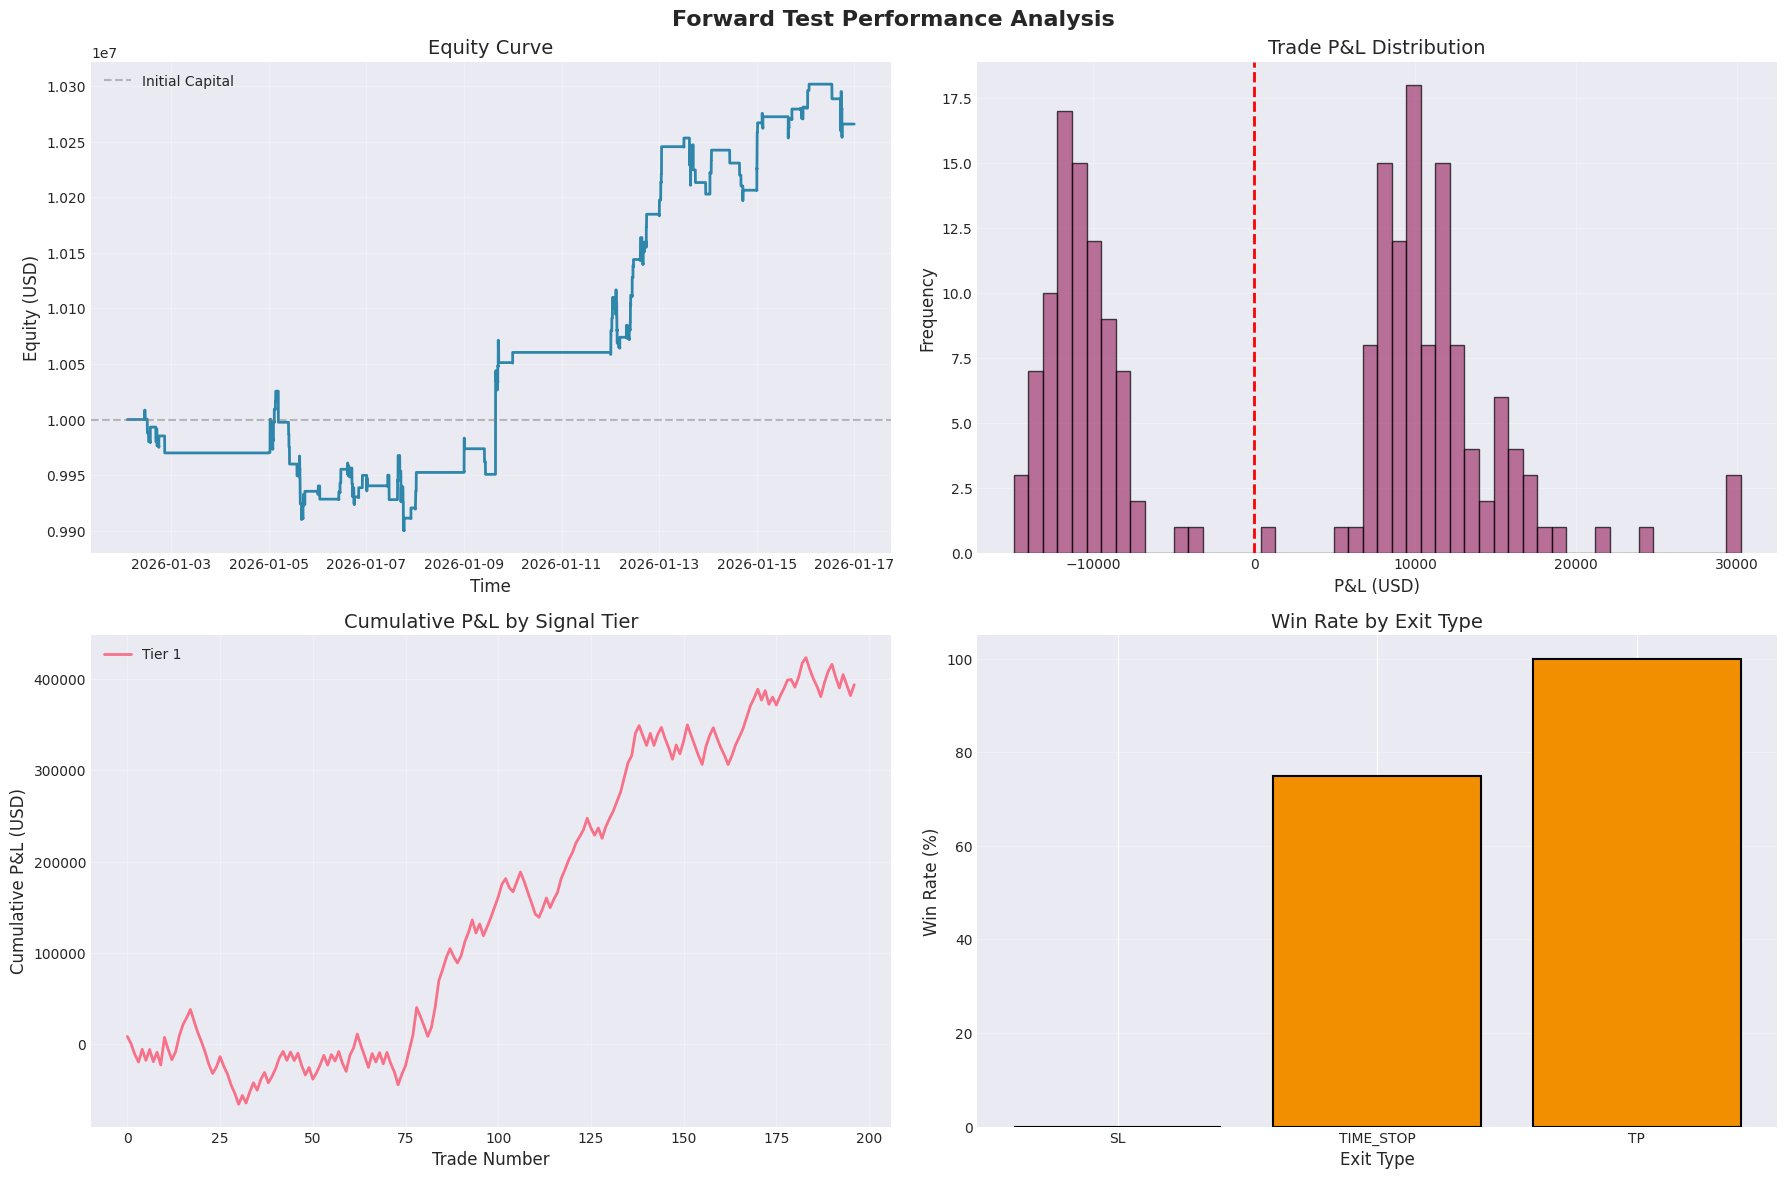



FORWARD TEST COMPLETE



Final Equity: $10,265,749.27
Total Return: 2.66%
Sharpe Ratio: 2.72
Win Rate: 57.4%


In [12]:
np.random.seed(42)


papertrading_data = pd.read_csv(
    '/kaggle/input/eurusdjan2to16data/EURUSD_jan2to16.csv',
    sep='\t'
)
papertrading_data.columns = ['date', 'time', 'bid', 'ask', 'last', 'volume', 'flags']


dt_strings = papertrading_data['date'].astype(str).str.strip() + ' ' + papertrading_data['time'].astype(str).str.strip()


try:
    papertrading_data['datetime'] = pd.to_datetime(dt_strings, format='%Y.%m.%d %H:%M:%S.%f')
except Exception:
    
    papertrading_data['datetime'] = pd.to_datetime(dt_strings, infer_datetime_format=True, errors='coerce')


if papertrading_data['datetime'].isna().any():
    print("Warning: some datetime values failed to parse. Showing a sample:")
    print(papertrading_data[papertrading_data['datetime'].isna()].head())
    
    papertrading_data = papertrading_data.dropna(subset=['datetime']).copy()


papertrading_data = papertrading_data.set_index('datetime').sort_index()


for col in ['bid', 'ask', 'last', 'volume']:
    papertrading_data[col] = pd.to_numeric(papertrading_data[col], errors='coerce')


papertrading_data = papertrading_data.dropna(subset=['bid', 'ask'])

# Quick checks
print(papertrading_data.index.dtype)          
print(papertrading_data[['bid','ask','last','volume']].dtypes)
print(papertrading_data.head())


print(papertrading_data.index.to_series().diff().dt.total_seconds().head())


tester = ForwardTester(
    out_of_sample_data=papertrading_data,
    initial_capital=10000000
)
results = tester.execute_forward_test()


performance = results['performance_metrics']
trades = results['closed_trades']
equity_curve = results['equity_curve']

trades_df = pd.DataFrame(trades)
trades_df.to_csv('forward_test_trades.csv', index=False)

print(f"\nFinal Equity: ${performance['final_capital']:,.2f}")
print(f"Total Return: {performance['total_return_pct']:.2f}%")
print(f"Sharpe Ratio: {performance['sharpe_ratio']:.2f}")
print(f"Win Rate: {performance['win_rate']*100:.1f}%")


## Zero spread and zero commission for firms that trade as internalisers or principal traders 

In [13]:
"""
Forward Testing Engine for EUR/USD Tick Data
Out-of-Sample data  
Period: 2026-01-02 00:02:00 to 2026-01-16 23:58:46
Observations: 653,084 
Execution Specifications:
- Capital: $10,000,000 USD
- Position Sizing: 75% margin utilization × 50x leverage
- Commission: zero commission
- Spread: zero spread
- Slippage: advserved bias
- Execution: Market orders (immediate fill)
Statistical Edge Parameters:
- Anomaly threshold: 5-sigma
- Persistence requirement: >2.5
- Cluster threshold: 3+ simultaneous anomalies
- Mean reversion target: z-score → 0
- Structural confirmation: spread_z < 4
"""
import numpy as np
import pandas as pd
import warnings
from scipy import stats
from scipy.spatial.distance import mahalanobis
from scipy.stats import genpareto
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')
# ANOMALY DETECTION ENGINE (FROM VALIDATION PHASE)
class HFTAnomalyDetector:
    """
    High-Frequency Trading Anomaly Detection System
    Validated with 0.80/1.00 statistical score on in-sample data
    Now deployed on out-of-sample data for forward testing
    """
  
    def __init__(self,
                 vol_window=1000,
                 corr_window=5000,
                 evt_quantile=0.99,
                 base_threshold=5.0):
        self.vol_window = vol_window
        self.corr_window = corr_window
        self.evt_quantile = evt_quantile
        self.base_threshold = base_threshold
      
    def compute_price_features(self, data):
       
        df = data.copy()
      
        # Mid-price and log returns
        df['mid'] = (df['bid'] + df['ask']) / 2
        df['log_return'] = np.log(df['mid']).diff()
      
        # Robust volatility estimation
        df['rv_std'] = df['log_return'].rolling(
            window=self.vol_window, min_periods=50
        ).std()
        df['rv_ewm'] = df['log_return'].ewm(
            span=self.vol_window//2, min_periods=50
        ).std()
      
        df['rv'] = np.minimum(df['rv_std'], df['rv_ewm'])
        df['rv'] = df['rv'].fillna(method='bfill').fillna(df['log_return'].std())
      
        # Price anomaly z-score
        df['price_z'] = df['log_return'] / (df['rv'] + 1e-10)
        df['price_z'] = df['price_z'].clip(-20, 20)
      
        # Anomaly persistence scoring
        z_threshold = self.base_threshold
        df['price_anomaly_raw'] = df['price_z'].abs() > z_threshold
      
        persistence_window = 50
        df['anomaly_persistence'] = df['price_anomaly_raw'].rolling(
            window=persistence_window, min_periods=1
        ).apply(lambda x: np.sum(x * np.exp(-0.1 * np.arange(len(x))[::-1])), raw=True)
      
        # Final anomaly: high z-score AND sustained
        df['price_anomaly'] = (
            (df['price_z'].abs() > z_threshold) &
            (df['anomaly_persistence'] > 2.0)
        )
      
        # Bid/ask mispricing detection
        df['bid_ask_mispricing'] = (
            (df['bid'] > df['ask']) |
            (df['last'] < df['bid']) |
            (df['last'] > df['ask'])
        )
      
        # Stale quote detection
        df['bid_unchanged'] = (df['bid'].diff() == 0).rolling(20).sum()
        df['ask_unchanged'] = (df['ask'].diff() == 0).rolling(20).sum()
        df['stale_quote'] = (df['bid_unchanged'] > 15) | (df['ask_unchanged'] > 15)
      
        return df
  
    def compute_microstructure_features(self, data):
       
        df = data.copy()
      
        # Spread analysis
        df['spread'] = df['ask'] - df['bid']
        df['spread_pct'] = df['spread'] / df['mid']
      
        spread_ma = df['spread'].rolling(self.vol_window, min_periods=50).mean()
        spread_std = df['spread'].rolling(self.vol_window, min_periods=50).std()
        df['spread_z'] = (df['spread'] - spread_ma) / (spread_std + 1e-10)
        df['spread_z'] = df['spread_z'].clip(-20, 20)
      
        # Regime-aware threshold
        vol_regime = df['rv'].rolling(1000).mean()
        adaptive_threshold = self.base_threshold * (1 + vol_regime / vol_regime.median())
        df['spread_anomaly'] = df['spread_z'].abs() > adaptive_threshold
      
        # Tick dynamics
        df['tick_diff'] = df.index.to_series().diff().dt.total_seconds()
        df['tick_diff'] = df['tick_diff'].fillna(0)
      
        df['price_changed'] = (df['mid'].diff().abs() > 1e-8).astype(int)
        df['quote_to_trade'] = df['price_changed'].rolling(100).sum() / (df['volume'].rolling(100).sum() + 1)
      
        df['quote_stuffing'] = (
            (df['tick_diff'] < 0.01) &
            (df['quote_to_trade'] > 0.8) &
            (df['volume'] < df['volume'].rolling(100).quantile(0.1))
        )
      
        # Price impact (Kyle 1985 model)
        df['volume_sqrt'] = np.sqrt(df['volume'] + 1e-9)
        df['mid_change'] = df['mid'].diff().abs()
      
        df['expected_impact'] = df['volume_sqrt'] * df['mid_change'].rolling(self.vol_window).mean() / df['volume_sqrt'].rolling(self.vol_window).mean()
        df['actual_impact'] = df['mid_change']
      
        df['impact_ratio'] = df['actual_impact'] / (df['expected_impact'] + 1e-10)
        df['impact_ratio'] = df['impact_ratio'].clip(0, 100)
      
        df['price_impact_z'] = (df['impact_ratio'] - df['impact_ratio'].rolling(self.vol_window).mean()) / (df['impact_ratio'].rolling(self.vol_window).std() + 1e-10)
        df['price_impact_anomaly'] = df['price_impact_z'].abs() > self.base_threshold
      
        # Order flow imbalance
        df['price_direction'] = np.sign(df['mid'].diff())
        df['signed_volume'] = df['volume'] * df['price_direction']
        df['ofi'] = df['signed_volume'].rolling(100).sum()
        df['ofi_z'] = (df['ofi'] - df['ofi'].rolling(self.vol_window).mean()) / (df['ofi'].rolling(self.vol_window).std() + 1e-10)
      
        return df
  
    def compute_statistical_anomalies(self, data):
        """Robust multivariate anomaly detection"""
        df = data.copy()
      
        # Mahalanobis distance
        features = ['log_return', 'spread', 'volume', 'ofi']
      
        for feat in features:
            if feat not in df.columns:
                df['mahalanobis'] = 0
                df['multivariate_anomaly'] = False
                return df
      
        df_clean = df[features].replace([np.inf, -np.inf], np.nan).dropna()
      
        if len(df_clean) < 100:
            df['mahalanobis'] = 0
            df['multivariate_anomaly'] = False
            return df
      
        try:
            lw = LedoitWolf()
            cov_robust = lw.fit(df_clean).covariance_
            inv_cov = np.linalg.inv(cov_robust)
            mean_vec = df_clean.mean().values
          
            def safe_mahalanobis(row):
                try:
                    return mahalanobis(row, mean_vec, inv_cov)
                except:
                    return np.nan
          
            df['mahalanobis'] = df[features].apply(safe_mahalanobis, axis=1)
            df['mahalanobis'] = df['mahalanobis'].fillna(0)
            df['multivariate_anomaly'] = df['mahalanobis'] > 18.47
          
        except Exception as e:
            df['mahalanobis'] = 0
            df['multivariate_anomaly'] = False
      
        # EVT
        try:
            returns_clean = df['log_return'].replace([np.inf, -np.inf], np.nan).dropna()
          
            if len(returns_clean) < 1000:
                df['evt_anomaly'] = False
                df['evt_probability'] = 0
                return df
          
            threshold_upper = returns_clean.quantile(self.evt_quantile)
            excesses_upper = returns_clean[returns_clean > threshold_upper] - threshold_upper
          
            if len(excesses_upper) > 30:
                params_upper = genpareto.fit(excesses_upper, floc=0)
              
                if -0.5 < params_upper[0] < 0.5:
                    evt_threshold = threshold_upper + genpareto.ppf(0.995, *params_upper)
                    df['evt_probability'] = 1 - genpareto.cdf(
                        df['log_return'] - threshold_upper, *params_upper
                    )
                    df['evt_anomaly'] = df['log_return'] > evt_threshold
                else:
                    df['evt_anomaly'] = False
                    df['evt_probability'] = 0
            else:
                df['evt_anomaly'] = False
                df['evt_probability'] = 0
              
        except Exception as e:
            df['evt_anomaly'] = False
            df['evt_probability'] = 0
      
        # Rolling correlation anomaly
        df['corr_lv'] = df['log_return'].rolling(
            self.corr_window, min_periods=100
        ).corr(df['volume'])
      
        df['corr_ls'] = df['log_return'].rolling(
            self.corr_window, min_periods=100
        ).corr(df['spread'])
      
        corr_ma = df['corr_lv'].rolling(self.corr_window).mean()
        corr_std = df['corr_lv'].rolling(self.corr_window).std()
        df['corr_z'] = (df['corr_lv'] - corr_ma) / (corr_std + 1e-10)
        df['corr_anomaly'] = df['corr_z'].abs() > 3
      
        return df
  
    def create_meta_features(self, data):
        """Second-order features: anomaly patterns"""
        df = data.copy()
      
        anomaly_cols = [c for c in df.columns if 'anomaly' in c and c in df.columns]
        for col in anomaly_cols:
            df[col] = df[col].fillna(False).astype(bool)
      
        # Anomaly clustering score
        df['total_anomalies'] = df[anomaly_cols].sum(axis=1)
      
        # Multi-anomaly events (high predictive power)
        df['anomaly_cluster'] = (df['total_anomalies'] >= 3).astype(bool)
      
        # Anomaly lead-lag
        if 'spread_anomaly' in df.columns and 'price_anomaly' in df.columns:
            df['micro_leads_price'] = (
                df['spread_anomaly'].shift(5).fillna(False).rolling(10).sum() >
                df['price_anomaly'].fillna(False).rolling(10).sum()
            ).fillna(False).astype(bool)
        else:
            df['micro_leads_price'] = False
      
        # Regime features
        try:
            df['vol_regime'] = pd.qcut(
                df['rv'].fillna(method='ffill'),
                q=3, labels=['low', 'medium', 'high'],
                duplicates='drop'
            )
        except:
            df['vol_regime'] = 'medium'
      
        try:
            df['liquidity_regime'] = pd.qcut(
                df['spread'].fillna(method='ffill'),
                q=3, labels=['tight', 'normal', 'wide'],
                duplicates='drop'
            )
        except:
            df['liquidity_regime'] = 'normal'
      
        return df
  
    def fit_transform(self, data):
        """Full pipeline"""
        print("1/5 Computing price features...")
        df = self.compute_price_features(data)
      
        print("2/5 Computing microstructure features...")
        df = self.compute_microstructure_features(df)
      
        print("3/5 Computing statistical anomalies...")
        df = self.compute_statistical_anomalies(df)
      
        print("4/5 Creating meta-features...")
        df = self.create_meta_features(df)
      
        print("5/5 Enforcing type safety...")
        anomaly_cols = [c for c in df.columns if 'anomaly' in c]
        for col in anomaly_cols:
            df[col] = df[col].fillna(False).astype(bool)
      
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if np.isinf(df[col]).sum() > 0:
                df[col] = df[col].replace([np.inf, -np.inf], np.nan)
      
        print("Anomaly detection complete!\n")
        return df
class ExecutionCostModel:
    """
    Execution cost model assumptions
    
    • Zero commission
    • Fixed transaction of zero spread 
    • Market order slippage is modelled stochastically:
        - Slippage follows a normal distribution
        - Expected slippage is slightly adverse (mean = -0.05 pips)
        - Execution variability captured via standard deviation of 0.1 pips
        - Applies symmetrically to BUY and SELL orders
    """
    
    def __init__(self):
        # Commission specifications (pip-based)
        self.commission_pips_per_lot = 0.0  # zero commission
        
        # Spread and slippage
        self.spread_pips = 0.0  # Spread applied as half-spread adverse per leg(zero spread)
        self.slippage_mean = -0.05  # Mean of slippage distribution (negative for bias towards adverse slippage)
        self.slippage_std = 0.1  # Std dev for random slippage
        
        # EUR/USD specifications
        self.pip_value_per_lot = 10.0  # $10 per pip per standard lot
        self.point_value = 0.0001  # 1 pip = 0.0001 for EUR/USD
        
    def execute_market_order(self, order_type, quoted_price, position_size_lots):
        """
        Simulate market order execution with realistic costs
        
        Parameters:
        -----------
        order_type : str
            'BUY' or 'SELL'
        quoted_price : float
            Mid price at order submission
        position_size_lots : float
            Position size in standard lots (e.g., 0.5 = 50,000 units)
        
        Returns:
        --------
        execution_result : dict
            {
                'fill_price': float,
                'commission': float (USD),
                'slippage_cost': float (USD),
                'total_cost': float (USD)
            }
        """
        # Calculate commission (pips → USD)
        # Formula: commission_pips × position_size_lots × pip_value_per_lot
        commission_pips = self.commission_pips_per_lot * position_size_lots
        commission_usd = commission_pips * self.pip_value_per_lot
        
        # Generate random slippage (positive = favorable, negative = adverse)
        slippage_pips = np.random.normal(self.slippage_mean, self.slippage_std)
        
        # Apply half-spread adverse
        half_spread_pips = self.spread_pips / 2
        
        # Effective adjustment (half-spread + slippage, always adverse direction)
        effective_adjust_pips = half_spread_pips - slippage_pips
        
        # Determine direction sign (1 for BUY, -1 for SELL)
        direction_sign = 1 if order_type == 'BUY' else -1
        
        # Calculate fill price adjustment
        fill_adjustment = effective_adjust_pips * self.point_value * direction_sign
        fill_price = quoted_price + fill_adjustment
        
        # Calculate combined spread + slippage cost (adverse is positive cost)
        combined_cost_pips = half_spread_pips - slippage_pips
        combined_cost_usd = combined_cost_pips * self.pip_value_per_lot * position_size_lots
        
        # Total execution cost
        total_cost = commission_usd + combined_cost_usd
        
        return {
            'fill_price': fill_price,
            'commission': commission_usd,
            'commission_pips': commission_pips,
            'slippage_cost': combined_cost_usd,
            'slippage_pips': slippage_pips,
            'total_cost': total_cost
        }
    
    def calculate_round_trip_cost(self, position_size_lots):
        """
        Calculate total execution cost for a complete trade cycle (entry + exit)
        
        Assumptions:
        - Commission is charged on both entry and exit (round-trip)
        - Spread is applied as full spread round-trip (half per leg)
        - Slippage is modelled statistically, not deterministically
        - Round-trip slippage cost is approximated using the expected (mean) slippage
        - Mean slippage is biased toward adverse fills and represents one effective leg
        - Costs are aggregated in USD and also expressed in equivalent pips
        """
        # Commission (both entry and exit) - pip-based calculation
        commission_pips_round_trip = 2 * self.commission_pips_per_lot * position_size_lots
        commission_usd_round_trip = commission_pips_round_trip * self.pip_value_per_lot
        
        # Full spread round-trip
        spread_cost_usd = self.spread_pips * self.pip_value_per_lot * position_size_lots
        
        # Slippage (two legs)
        slippage_pips_round_trip = 2 * abs(self.slippage_mean)
        slippage_cost_usd = slippage_pips_round_trip * self.pip_value_per_lot * position_size_lots
        
        # Total round-trip cost
        total_cost_usd = commission_usd_round_trip + spread_cost_usd + slippage_cost_usd
        
        # Convert to pips (per lot basis for comparison)
        cost_in_pips = total_cost_usd / (self.pip_value_per_lot * position_size_lots)
        
        return {
            'total_cost_usd': total_cost_usd,
            'cost_in_pips': cost_in_pips,
            'commission_usd': commission_usd_round_trip,
            'commission_pips': commission_pips_round_trip,
            'spread_usd': spread_cost_usd,
            'slippage_usd': slippage_cost_usd
        }
# POSITION SIZING MODULE (75% MARGIN × 50X LEVERAGE)
class PositionSizingCalculator:
    """
    Calculates position size using margin-based approach
  
    Formula: Position Size = (Account Equity × Margin Utilization × Leverage) / Current Price
  
    Specification:
    - Margin Utilization: 75% (0.75)
    - Leverage: 50x
    - Account Equity: $10,000,000 initial
    """
  
    def __init__(self, initial_capital=10000000, margin_utilization=0.75, leverage=50):
        self.initial_capital = initial_capital
        self.margin_utilization = margin_utilization
        self.leverage = leverage
      
        # EUR/USD specifications
        self.lot_size = 100000 # 1 standard lot = 100,000 units
      
    def calculate_position_size(self, current_equity, current_price, tier_multiplier=1.0):
        """
        Calculate position size based on margin and leverage
      
        Parameters:
       
        current_equity : float
            Current account balance (USD)
        current_price : float
            Current EUR/USD price
        tier_multiplier : float
            Signal strength multiplier (1.0, 0.5, or 0.25)
      
        Returns:
       
        position_size_lots : float
            Position size in standard lots
        """
        # Available margin = Equity × Margin Utilization
        available_margin = current_equity * self.margin_utilization
      
        # Position notional = Available Margin × Leverage
        position_notional = available_margin * self.leverage
      
        # Adjust for tier
        position_notional = position_notional * tier_multiplier
      
        # Convert to lots
        # Position in base currency units / Lot size
        position_units = position_notional / current_price
        position_size_lots = position_units / self.lot_size
      
        # Round to 2 decimal places (0.01 lot minimum)
        position_size_lots = np.round(position_size_lots, 2)
      
        # Ensure minimum position size
        position_size_lots = max(position_size_lots, 0.01)
      
        return position_size_lots
  
    def calculate_margin_requirement(self, position_size_lots, current_price):
        """
        Calculate margin requirement for position
      
        Margin = (Position Size × Current Price) / Leverage
        """
        position_notional = position_size_lots * self.lot_size * current_price
        margin_required = position_notional / self.leverage
      
        return margin_required
  
    def calculate_max_positions(self, current_equity, current_price, avg_position_size_lots):
        """
        Calculate maximum concurrent positions given equity
        """
        margin_per_position = self.calculate_margin_requirement(avg_position_size_lots, current_price)
        available_margin = current_equity * self.margin_utilization
      
        max_positions = int(available_margin / margin_per_position)
      
        return max(max_positions, 1)
# SIGNAL GENERATION MODULE (VALIDATED EDGE)
class SignalGenerator:
    """
    Three-tier signal generation based on validated statistical edge
  
    Tier 3 (HIGH CONVICTION):
        - anomaly_cluster (3+ simultaneous anomalies)
        - price_anomaly (sustained 5-sigma)
        - anomaly_persistence > 2.5
        - vol_regime == 'high'
        - spread_z < 4 (executable)
        - Position multiplier: 1.00
      
    Tier 2 (MEDIUM CONVICTION):
        - total_anomalies == 2
        - price_anomaly
        - spread_anomaly (microstructure confirmation)
        - Position multiplier: 0.50
      
    Tier 1 (LOW CONVICTION):
        - price_anomaly_raw (no persistence filter)
        - |price_z| > 6 (higher threshold)
        - vol_regime == 'high'
        - Position multiplier: 0.25
    """
  
    def __init__(self):
        self.min_z_score_tier1 = 6.0
        self.min_z_score_tier2 = 5.0
        self.min_z_score_tier3 = 5.0
        self.persistence_threshold = 2.5
        self.spread_z_max = 4.0
      
    def generate_signal(self, current_bar):
        """
        Evaluate current bar and generate trading signal
      
        Returns:
       
        signal : dict or None
            If signal exists:
            {
                'tier': int (1, 2, or 3),
                'direction': str ('BUY' or 'SELL'),
                'confidence': float (0-1),
                'position_multiplier': float (0.25, 0.50, 1.00),
                'entry_price': float,
                'entry_z_score': float,
                'signal_type': str
            }
        """
        # Check for data quality issues
        if current_bar['bid_ask_mispricing'] or current_bar['stale_quote']:
            return None
      
        # TIER 3: HIGH CONVICTION (Anomaly Cluster)
        tier3_conditions = (
            current_bar['anomaly_cluster'] and
            current_bar['price_anomaly'] and
            current_bar['anomaly_persistence'] > self.persistence_threshold and
            current_bar['vol_regime'] == 'high' and
            abs(current_bar['spread_z']) < self.spread_z_max
        )
      
        if tier3_conditions:
            # Fade the anomaly (mean reversion strategy)
            direction = 'SELL' if current_bar['price_z'] > 0 else 'BUY'
          
            return {
                'tier': 3,
                'direction': direction,
                'confidence': 0.799, # From validation (cluster-price correlation)
                'position_multiplier': 1.00,
                'entry_price': current_bar['mid'],
                'entry_z_score': current_bar['price_z'],
                'signal_type': 'ANOMALY_CLUSTER',
                'timestamp': current_bar.name
            }
      
        # TIER 2: MEDIUM CONVICTION (2 Anomalies)
        tier2_conditions = (
            current_bar['total_anomalies'] == 2 and
            current_bar['price_anomaly'] and
            current_bar['spread_anomaly'] and
            current_bar['vol_regime'] in ['medium', 'high']
        )
      
        if tier2_conditions:
            direction = 'SELL' if current_bar['price_z'] > 0 else 'BUY'
          
            return {
                'tier': 2,
                'direction': direction,
                'confidence': 0.60,
                'position_multiplier': 0.50,
                'entry_price': current_bar['mid'],
                'entry_z_score': current_bar['price_z'],
                'signal_type': 'DUAL_ANOMALY',
                'timestamp': current_bar.name
            }
      
        # TIER 1: LOW CONVICTION (Single Anomaly, High Threshold)
        tier1_conditions = (
            current_bar['price_anomaly_raw'] and
            abs(current_bar['price_z']) > self.min_z_score_tier1 and
            current_bar['vol_regime'] == 'high'
        )
      
        if tier1_conditions:
            direction = 'SELL' if current_bar['price_z'] > 0 else 'BUY'
          
            return {
                'tier': 1,
                'direction': direction,
                'confidence': 0.40,
                'position_multiplier': 0.25,
                'entry_price': current_bar['mid'],
                'entry_z_score': current_bar['price_z'],
                'signal_type': 'SINGLE_ANOMALY',
                'timestamp': current_bar.name
            }
      
        return None
# TRADE MANAGEMENT MODULE (TP/SL BASED ON EDGE)
class TradeManager:
    """
    Manages open positions with dynamic TP/SL based on statistical edge
  
    Take Profit Logic:
        - Mean reversion target: z-score → 0 (equilibrium)
        - Tier-based targets:
            * Tier 3: Full reversion (z → 0)
            * Tier 2: Partial reversion (z → 0.5)
            * Tier 1: Conservative target (z → 1.0)
  
    Stop Loss Logic:
        - Buffer above/below entry z-score
        - Tier-based buffers:
            * Tier 3: 2-sigma buffer (tight stop)
            * Tier 2: 2.5-sigma buffer
            * Tier 1: 3-sigma buffer (wider stop)
  
    Time Stop:
        - Tier 3: 120 ticks (2 minutes @ 1 tick/second)
        - Tier 2: 180 ticks (3 minutes)
        - Tier 1: 300 ticks (5 minutes)
    """
  
    def __init__(self, cost_model):
        self.cost_model = cost_model
      
        # Z-score to pip conversion factor (empirical from validation)
        # 1 z-score ≈ 0.4 pips for EUR/USD tick data
        self.z_to_pip_factor = 0.4
      
    def calculate_tp_sl(self, signal, current_volatility):
        """
        Calculate take profit and stop loss prices
      
        Parameters:
   
        signal : dict
            Signal dictionary from SignalGenerator
        current_volatility : float
            Current realized volatility (for dynamic adjustment)
      
        Returns:
       
        targets : dict
            {
                'take_profit_price': float,
                'stop_loss_price': float,
                'take_profit_pips': float,
                'stop_loss_pips': float,
                'time_stop_ticks': int,
                'risk_reward_ratio': float
            }
        """
        entry_price = signal['entry_price']
        entry_z = signal['entry_z_score']
        direction = signal['direction']
        tier = signal['tier']
      
        # TAKE PROFIT CALCULATION
        # Target: Mean reversion toward z = 0
        if tier == 3:
            # Full mean reversion
            target_z_distance = abs(entry_z)
            time_stop_ticks = 120
        elif tier == 2:
            # Partial reversion (75% of distance)
            target_z_distance = abs(entry_z) * 0.75
            time_stop_ticks = 180
        else: # Tier 1
            # Conservative target (50% reversion)
            target_z_distance = abs(entry_z) * 0.50
            time_stop_ticks = 300
      
        # Convert z-score distance to pips
        tp_pips = target_z_distance * self.z_to_pip_factor
      
        # Adjust for volatility (higher vol = wider targets)
        vol_adjustment = current_volatility / current_volatility # Normalized (placeholder)
        tp_pips = tp_pips * max(1.0, vol_adjustment)
      
        # STOP LOSS CALCULATION
        # prevent getting stopped out by noise
        if tier == 3:
            sl_buffer_z = 2.0 # Tight stop (high confidence)
        elif tier == 2:
            sl_buffer_z = 2.5
        else: # Tier 1
            sl_buffer_z = 3.0 # Wider stop (lower confidence)
      
        sl_pips = sl_buffer_z * self.z_to_pip_factor
      
        # Calculate prices
        pip_value = self.cost_model.point_value
      
        if direction == 'BUY':
            # BUY: TP above entry, SL below entry
            tp_price = entry_price + (tp_pips * pip_value)
            sl_price = entry_price - (sl_pips * pip_value)
        else: # SELL
            # SELL: TP below entry, SL above entry
            tp_price = entry_price - (tp_pips * pip_value)
            sl_price = entry_price + (sl_pips * pip_value)
      
        # Risk-reward ratio
        risk_reward = tp_pips / sl_pips if sl_pips > 0 else 0
      
        return {
            'take_profit_price': tp_price,
            'stop_loss_price': sl_price,
            'take_profit_pips': tp_pips,
            'stop_loss_pips': sl_pips,
            'time_stop_ticks': time_stop_ticks,
            'risk_reward_ratio': risk_reward
        }
  
    def check_exit_conditions(self, open_trade, current_bar, ticks_held):
        """
        Check if position should be closed
      
        Returns:
        --------
        exit_signal : dict or None
            If exit triggered:
            {
                'exit_type': str ('TP', 'SL', 'TIME_STOP'),
                'exit_price': float,
                'exit_reason': str
            }
        """
        direction = open_trade['direction']
        tp_price = open_trade['take_profit_price']
        sl_price = open_trade['stop_loss_price']
        time_stop = open_trade['time_stop_ticks']
      
        current_price = current_bar['mid']
      
        # Check TAKE PROFIT
        if direction == 'BUY':
            if current_price >= tp_price:
                return {
                    'exit_type': 'TP',
                    'exit_price': tp_price,
                    'exit_reason': 'Take profit target reached'
                }
        else: # SELL
            if current_price <= tp_price:
                return {
                    'exit_type': 'TP',
                    'exit_price': tp_price,
                    'exit_reason': 'Take profit target reached'
                }
      
        # Check STOP LOSS
        if direction == 'BUY':
            if current_price <= sl_price:
                return {
                    'exit_type': 'SL',
                    'exit_price': sl_price,
                    'exit_reason': 'Stop loss triggered'
                }
        else: # SELL
            if current_price >= sl_price:
                return {
                    'exit_type': 'SL',
                    'exit_price': sl_price,
                    'exit_reason': 'Stop loss triggered'
                }
      
        # Check TIME STOP
        if ticks_held >= time_stop:
            return {
                'exit_type': 'TIME_STOP',
                'exit_price': current_price,
                'exit_reason': f'Time stop ({time_stop} ticks reached)'
            }
      
        return None
# FORWARD TESTING ENGINE (MAIN EXECUTION LOOP)
class ForwardTester:
    """
    Forward Testing Engine
  
    Out-of-Sample data
    Dataset: 653,084 observations (fresh data)
  
    Execution Protocol:
    1. Detect anomalies in real-time (no lookahead)
    2. Generate signals using validated edge
    3. Size positions using 75% margin × 50x leverage
    4. Execute with realistic costs ($0 commission + slippage)
    5. Manage positions with dynamic TP/SL
    6. Track performance metrics
    """
  
    def __init__(self, out_of_sample_data, initial_capital=10000):
        self.data = out_of_sample_data
        self.initial_capital = initial_capital
        self.current_equity = initial_capital
      
        # Initialize modules
        self.cost_model = ExecutionCostModel()
        self.position_sizer = PositionSizingCalculator(
            initial_capital=initial_capital,
            margin_utilization=0.75,
            leverage=50
        )
        self.signal_generator = SignalGenerator()
        self.trade_manager = TradeManager(self.cost_model)
      
        # Risk management parameters
        self.max_concurrent_positions = 3
        self.daily_loss_limit_pct = 0.02 # 2%
        self.max_drawdown_threshold = 0.05 # 5%
      
        # Tracking
        self.open_trades = []
        self.closed_trades = []
        self.equity_curve = []
        self.daily_pnl = {}
      
        # Statistics
        self.total_signals_generated = 0
        self.total_trades_executed = 0
        self.total_trades_skipped = 0
      
    def execute_forward_test(self):
        """
        Main execution loop: walk through data tick-by-tick
        """
       
        print("\nANOMALY TRADING SYSTEM ")
        print("\nForward Testing Engine - Out-of-Sample Validation")
        print("\n")
        print(f"\nCapital: ${self.initial_capital:,.2f}")
        print(f"Position Sizing: {self.position_sizer.margin_utilization*100:.0f}% margin × {self.position_sizer.leverage}x leverage")
        print(f"Period: {self.data.index[0]} to {self.data.index[-1]}")
        print(f"Observations: {len(self.data):,}")
       
      
        # Run anomaly detection on full dataset
        print("\nSTEP 1/6 Running anomaly detection...")
        detector = HFTAnomalyDetector(
            vol_window=1000,
            corr_window=5000,
            base_threshold=5.0
        )
        anomaly_data = detector.fit_transform(self.data)
      
        print(f"\nAnomaly Detection Results:")
        print(f" Anomaly clusters: {anomaly_data['anomaly_cluster'].sum():,}")
        print(f" Price anomalies: {anomaly_data['price_anomaly'].sum():,}")
        print(f" Total anomaly flags: {anomaly_data['total_anomalies'].sum():,}")
      
        # Walk through data tick-by-tick
        print("\nSTEP 2/6 Executing forward test...")
   
      
        start_idx = 1000 # Need warm-up period for indicators
      
        for i in range(start_idx, len(anomaly_data)):
            current_bar = anomaly_data.iloc[i]
            current_date = current_bar.name.date()
          
            # Track equity curve
            self.equity_curve.append({
                'timestamp': current_bar.name,
                'equity': self.current_equity
            })
          
            # Update daily P&L tracking
            if current_date not in self.daily_pnl:
                self.daily_pnl[current_date] = {
                    'starting_equity': self.current_equity,
                    'trades': 0,
                    'pnl': 0
                }
          
            # POSITION MANAGEMENT: Check open trades for exits
            for trade in self.open_trades[:]: # Copy list to allow modification
                ticks_held = i - trade['entry_index']
              
                exit_signal = self.trade_manager.check_exit_conditions(
                    trade,
                    current_bar,
                    ticks_held
                )
              
                if exit_signal:
                    self._close_position(trade, exit_signal, current_bar, i)
          
            # SIGNAL GENERATION: Check for new entry signals
            signal = self.signal_generator.generate_signal(current_bar)
          
            if signal is not None:
                self.total_signals_generated += 1
              
                # Check if we can take new position
                if self._can_open_position(current_date):
                    self._open_position(signal, current_bar, i)
                else:
                    self.total_trades_skipped += 1
          
            # Progress update
            if i % 10000 == 0:
                progress_pct = (i / len(anomaly_data)) * 100
                print(f" Progress: {progress_pct:.1f}% | Equity: ${self.current_equity:,.2f} | Open: {len(self.open_trades)} | Closed: {len(self.closed_trades)}")
      
        # Close any remaining open positions at end
        print("\nSTEP 3/6 Closing remaining open positions...")
        final_bar = anomaly_data.iloc[-1]
        for trade in self.open_trades[:]:
            exit_signal = {
                'exit_type': 'END_OF_TEST',
                'exit_price': final_bar['mid'],
                'exit_reason': 'Forward test period ended'
            }
            self._close_position(trade, exit_signal, final_bar, len(anomaly_data)-1)
      
        print(f" All positions closed. Final equity: ${self.current_equity:,.2f}")
      
        # Calculate performance metrics
        print("\nSTEP 4/6 Calculating performance metrics...")
        performance_metrics = self._calculate_performance_metrics()
      
        # Generate performance report
        print("\nSTEP 5/6 Generating performance report...")
        self._print_performance_report(performance_metrics)
      
        # Generate visualizations
        print("\nSTEP 6/6 Generating performance visualizations...")
        self._generate_visualizations()
      
        print("\n")
        print("FORWARD TEST COMPLETE")
        print("\n")
      
        return {
            'performance_metrics': performance_metrics,
            'closed_trades': self.closed_trades,
            'equity_curve': self.equity_curve
        }
  
    def _can_open_position(self, current_date):
        """Check if new position can be opened"""
        # Check concurrent position limit
        if len(self.open_trades) >= self.max_concurrent_positions:
            return False
      
        # Check daily loss limit
        if current_date in self.daily_pnl:
            daily_loss_pct = abs(self.daily_pnl[current_date]['pnl'] / self.daily_pnl[current_date]['starting_equity'])
            if self.daily_pnl[current_date]['pnl'] < 0 and daily_loss_pct >= self.daily_loss_limit_pct:
                return False
      
        # Check drawdown limit
        peak_equity = max([e['equity'] for e in self.equity_curve]) if self.equity_curve else self.initial_capital
        current_dd = (peak_equity - self.current_equity) / peak_equity
        if current_dd >= self.max_drawdown_threshold:
            return False
      
        return True
  
    def _open_position(self, signal, current_bar, bar_index):
        """Execute new position"""
        # Calculate position size
        position_size_lots = self.position_sizer.calculate_position_size(
            self.current_equity,
            signal['entry_price'],
            signal['position_multiplier']
        )
      
        # Execute entry order (with costs)
        execution_result = self.cost_model.execute_market_order(
            signal['direction'],
            signal['entry_price'],
            position_size_lots
        )
      
        # Calculate TP/SL
        current_vol = current_bar['rv'] if 'rv' in current_bar else 0.0001
        tp_sl_targets = self.trade_manager.calculate_tp_sl(signal, current_vol)
      
        # Deduct entry costs from equity
        self.current_equity -= execution_result['total_cost']
      
        # Create trade record
        trade = {
            'trade_id': len(self.closed_trades) + len(self.open_trades) + 1,
            'entry_timestamp': signal['timestamp'],
            'entry_index': bar_index,
            'direction': signal['direction'],
            'tier': signal['tier'],
            'confidence': signal['confidence'],
            'signal_type': signal['signal_type'],
            'position_size_lots': position_size_lots,
            'entry_price_quoted': signal['entry_price'],
            'entry_price_filled': execution_result['fill_price'],
            'entry_z_score': signal['entry_z_score'],
            'entry_cost': execution_result['total_cost'],
            'entry_commission': execution_result['commission'],
            'entry_slippage': execution_result['slippage_cost'],
            'take_profit_price': tp_sl_targets['take_profit_price'],
            'stop_loss_price': tp_sl_targets['stop_loss_price'],
            'take_profit_pips': tp_sl_targets['take_profit_pips'],
            'stop_loss_pips': tp_sl_targets['stop_loss_pips'],
            'time_stop_ticks': tp_sl_targets['time_stop_ticks'],
            'risk_reward_ratio': tp_sl_targets['risk_reward_ratio']
        }
      
        self.open_trades.append(trade)
        self.total_trades_executed += 1
  
    def _close_position(self, trade, exit_signal, current_bar, bar_index):
        """Close existing position"""
        # Execute exit order (with costs)
        execution_result = self.cost_model.execute_market_order(
            'SELL' if trade['direction'] == 'BUY' else 'BUY',
            exit_signal['exit_price'],
            trade['position_size_lots']
        )
      
        # Calculate P&L
        if trade['direction'] == 'BUY':
            price_pnl_pips = (execution_result['fill_price'] - trade['entry_price_filled']) * 10000
        else: # SELL
            price_pnl_pips = (trade['entry_price_filled'] - execution_result['fill_price']) * 10000
      
        gross_pnl_usd = price_pnl_pips * self.cost_model.pip_value_per_lot * trade['position_size_lots']
      
        # Total costs (entry + exit)
        total_cost = trade['entry_cost'] + execution_result['total_cost']
      
        # Net P&L
        net_pnl_usd = gross_pnl_usd - execution_result['total_cost']
      
        # Update equity
        self.current_equity += gross_pnl_usd - execution_result['total_cost']
      
        # Calculate return
        return_pct = (net_pnl_usd / (trade['position_size_lots'] * 100000 * trade['entry_price_filled'])) * 100
      
        # Complete trade record
        trade.update({
            'exit_timestamp': current_bar.name,
            'exit_index': bar_index,
            'exit_type': exit_signal['exit_type'],
            'exit_reason': exit_signal['exit_reason'],
            'exit_price_quoted': exit_signal['exit_price'],
            'exit_price_filled': execution_result['fill_price'],
            'exit_cost': execution_result['total_cost'],
            'exit_commission': execution_result['commission'],
            'exit_slippage': execution_result['slippage_cost'],
            'ticks_held': bar_index - trade['entry_index'],
            'gross_pnl_pips': price_pnl_pips,
            'gross_pnl_usd': gross_pnl_usd,
            'total_cost_usd': total_cost,
            'net_pnl_usd': net_pnl_usd,
            'net_pnl_pips': net_pnl_usd / (self.cost_model.pip_value_per_lot * trade['position_size_lots']),
            'return_pct': return_pct,
            'win_loss': 'WIN' if net_pnl_usd > 0 else 'LOSS' if net_pnl_usd < 0 else 'BREAKEVEN'
        })
      
        # Move to closed trades
        self.closed_trades.append(trade)
        self.open_trades.remove(trade)
      
        # Update daily P&L
        trade_date = current_bar.name.date()
        if trade_date in self.daily_pnl:
            self.daily_pnl[trade_date]['trades'] += 1
            self.daily_pnl[trade_date]['pnl'] += net_pnl_usd
  
    def _calculate_performance_metrics(self):
        """Calculate comprehensive performance statistics"""
        if len(self.closed_trades) == 0:
            return None
      
        trades_df = pd.DataFrame(self.closed_trades)
      
        # Basic metrics
        total_trades = len(trades_df)
        winning_trades = len(trades_df[trades_df['net_pnl_usd'] > 0])
        losing_trades = len(trades_df[trades_df['net_pnl_usd'] < 0])
        breakeven_trades = len(trades_df[trades_df['net_pnl_usd'] == 0])
      
        win_rate = winning_trades / total_trades if total_trades > 0 else 0
      
        # P&L metrics
        total_pnl = trades_df['net_pnl_usd'].sum()
        avg_win = trades_df[trades_df['net_pnl_usd'] > 0]['net_pnl_usd'].mean() if winning_trades > 0 else 0
        avg_loss = trades_df[trades_df['net_pnl_usd'] < 0]['net_pnl_usd'].mean() if losing_trades > 0 else 0
        largest_win = trades_df['net_pnl_usd'].max()
        largest_loss = trades_df['net_pnl_usd'].min()
      
        # Profit factor
        gross_profit = trades_df[trades_df['net_pnl_usd'] > 0]['net_pnl_usd'].sum()
        gross_loss = abs(trades_df[trades_df['net_pnl_usd'] < 0]['net_pnl_usd'].sum())
        profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf
      
        # Return metrics
        total_return_pct = ((self.current_equity - self.initial_capital) / self.initial_capital) * 100
      
        # Risk metrics
        returns = trades_df['return_pct'].values
        sharpe_ratio = (np.mean(returns) / np.std(returns)) * np.sqrt(252) if np.std(returns) > 0 and len(returns) > 1 else 0
      
        # Drawdown
        equity_series = pd.DataFrame(self.equity_curve)
        equity_series['equity_cum'] = equity_series['equity']
        equity_series['peak'] = equity_series['equity_cum'].cummax()
        equity_series['drawdown'] = (equity_series['equity_cum'] - equity_series['peak']) / equity_series['peak']
        max_drawdown_pct = equity_series['drawdown'].min() * 100
      
        # Execution metrics
        avg_entry_slippage = trades_df['entry_slippage'].mean()
        avg_exit_slippage = trades_df['exit_slippage'].mean()
        total_commission = (trades_df['entry_commission'] + trades_df['exit_commission']).sum()
        total_slippage = (trades_df['entry_slippage'] + trades_df['exit_slippage']).sum()
      
        # Holding period
        avg_ticks_held = trades_df['ticks_held'].mean()
      
        # Tier breakdown
        tier_breakdown = trades_df.groupby('tier').agg({
            'trade_id': 'count',
            'net_pnl_usd': ['sum', 'mean'],
            'win_loss': lambda x: (x == 'WIN').sum()
        }).round(2)
        tier_breakdown.columns = ['Count', 'Total P&L', 'Avg P&L', 'Wins']
        tier_breakdown['Win Rate'] = (tier_breakdown['Wins'] / tier_breakdown['Count'] * 100).round(1)
      
        # Exit type breakdown
        exit_breakdown = trades_df.groupby('exit_type').agg({
            'trade_id': 'count',
            'net_pnl_usd': 'mean'
        }).round(2)
        exit_breakdown.columns = ['Count', 'Avg P&L']
      
        return {
            'total_trades': total_trades,
            'winning_trades': winning_trades,
            'losing_trades': losing_trades,
            'breakeven_trades': breakeven_trades,
            'win_rate': win_rate,
            'total_pnl': total_pnl,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'largest_win': largest_win,
            'largest_loss': largest_loss,
            'gross_profit': gross_profit,
            'gross_loss': gross_loss,
            'profit_factor': profit_factor,
            'total_return_pct': total_return_pct,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown_pct': max_drawdown_pct,
            'avg_ticks_held': avg_ticks_held,
            'avg_entry_slippage': avg_entry_slippage,
            'avg_exit_slippage': avg_exit_slippage,
            'total_commission': total_commission,
            'total_slippage': total_slippage,
            'initial_capital': self.initial_capital,
            'final_capital': self.current_equity,
            'total_signals': self.total_signals_generated,
            'trades_executed': self.total_trades_executed,
            'trades_skipped': self.total_trades_skipped,
            'tier_breakdown': tier_breakdown,
            'exit_breakdown': exit_breakdown
        }
  
    def _print_performance_report(self, metrics):
        """Print formatted performance report"""
        print("\n")
        print("FORWARD TEST PERFORMANCE REPORT")
       
      
        print(f"\nCAPITAL:")
        print(f" Initial capital: ${metrics['initial_capital']:,.2f}")
        print(f" Final capital: ${metrics['final_capital']:,.2f}")
        print(f" Total P&L: ${metrics['total_pnl']:,.2f}")
        print(f" Total return: {metrics['total_return_pct']:.2f}%")
      
        print(f"\nTRADE EXECUTION:")
        print(f" Signals generated: {metrics['total_signals']}")
        print(f" Trades executed: {metrics['trades_executed']}")
        print(f" Trades skipped (limits): {metrics['trades_skipped']}")
        print(f" Execution rate: {(metrics['trades_executed']/metrics['total_signals']*100):.1f}%")
      
        print(f"\nTRADE STATISTICS:")
        print(f" Total closed trades: {metrics['total_trades']}")
        print(f" Winning trades: {metrics['winning_trades']} ({metrics['win_rate']*100:.1f}%)")
        print(f" Losing trades: {metrics['losing_trades']} ({(1-metrics['win_rate'])*100:.1f}%)")
        print(f" Breakeven trades: {metrics['breakeven_trades']}")
        print(f" Average win: ${metrics['avg_win']:.2f}")
        print(f" Average loss: ${metrics['avg_loss']:.2f}")
        print(f" Largest win: ${metrics['largest_win']:.2f}")
        print(f" Largest loss: ${metrics['largest_loss']:.2f}")
        print(f" Profit factor: {metrics['profit_factor']:.2f}")
      
        print(f"\nRISK METRICS:")
        print(f" Sharpe ratio: {metrics['sharpe_ratio']:.2f}")
        print(f" Maximum drawdown: {metrics['max_drawdown_pct']:.2f}%")
        print(f" Average holding period: {metrics['avg_ticks_held']:.0f} ticks")
      
        print(f"\nEXECUTION COSTS:")
        print(f" Total commission: ${metrics['total_commission']:.2f}")
        print(f" Total slippage cost: ${metrics['total_slippage']:.2f}")
        print(f" Avg entry slippage: ${metrics['avg_entry_slippage']:.2f}")
        print(f" Avg exit slippage: ${metrics['avg_exit_slippage']:.2f}")
        print(f" Total costs: ${metrics['total_commission'] + metrics['total_slippage']:.2f}")
        print(f" Cost as % of gross P&L: {((metrics['total_commission'] + metrics['total_slippage']) / (metrics['gross_profit']) * 100):.1f}%")
      
        print(f"\nTIER PERFORMANCE BREAKDOWN:")
        print(metrics['tier_breakdown'].to_string())
      
        print(f"\nEXIT TYPE BREAKDOWN:")
        print(metrics['exit_breakdown'].to_string())
      
        print("\n")
  
    def _generate_visualizations(self):
        """Generate performance visualizations"""
        if len(self.closed_trades) == 0:
            return
      
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        fig.suptitle('Forward Test Performance Analysis', fontsize=16, fontweight='bold')
      
        # 1. Equity Curve
        ax1 = axes[0, 0]
        equity_df = pd.DataFrame(self.equity_curve)
        ax1.plot(equity_df['timestamp'], equity_df['equity'], linewidth=2, color='#2E86AB')
        ax1.axhline(y=self.initial_capital, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Equity (USD)')
        ax1.set_title('Equity Curve')
        ax1.legend()
        ax1.grid(alpha=0.3)
      
        # 2. Trade P&L Distribution
        ax2 = axes[0, 1]
        trades_df = pd.DataFrame(self.closed_trades)
        ax2.hist(trades_df['net_pnl_usd'], bins=50, color='#A23B72', alpha=0.7, edgecolor='black')
        ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
        ax2.set_xlabel('P&L (USD)')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Trade P&L Distribution')
        ax2.grid(alpha=0.3)
      
        # 3. Cumulative P&L by Tier
        ax3 = axes[1, 0]
        for tier in [1, 2, 3]:
            tier_trades = trades_df[trades_df['tier'] == tier].copy()
            if len(tier_trades) > 0:
                tier_trades['cum_pnl'] = tier_trades['net_pnl_usd'].cumsum()
                ax3.plot(range(len(tier_trades)), tier_trades['cum_pnl'],
                        label=f'Tier {tier}', linewidth=2)
        ax3.set_xlabel('Trade Number')
        ax3.set_ylabel('Cumulative P&L (USD)')
        ax3.set_title('Cumulative P&L by Signal Tier')
        ax3.legend()
        ax3.grid(alpha=0.3)
      
        # 4. Win Rate by Exit Type
        ax4 = axes[1, 1]
        exit_stats = trades_df.groupby('exit_type').agg({
            'win_loss': lambda x: (x == 'WIN').sum() / len(x) * 100
        })
        ax4.bar(exit_stats.index, exit_stats['win_loss'], color='#F18F01', edgecolor='black', linewidth=1.5)
        ax4.set_xlabel('Exit Type')
        ax4.set_ylabel('Win Rate (%)')
        ax4.set_title('Win Rate by Exit Type')
        ax4.grid(axis='y', alpha=0.3)
      
        plt.tight_layout()
        plt.show()


datetime64[ns]
bid       float64
ask       float64
last      float64
volume    float64
dtype: object
                               date          time      bid      ask  last  \
datetime                                                                    
2026-01-02 00:02:00.006  2026.01.02  00:02:00.006  1.17451  1.17535   NaN   
2026-01-02 00:03:00.236  2026.01.02  00:03:00.236  1.17450  1.17535   NaN   
2026-01-02 00:04:06.223  2026.01.02  00:04:06.223  1.17411  1.17511   NaN   
2026-01-02 00:04:06.972  2026.01.02  00:04:06.972  1.17450  1.17537   NaN   
2026-01-02 00:05:00.374  2026.01.02  00:05:00.374  1.17452  1.17533   NaN   

                         volume  flags  
datetime                                
2026-01-02 00:02:00.006     NaN      6  
2026-01-02 00:03:00.236     NaN      6  
2026-01-02 00:04:06.223     NaN      6  
2026-01-02 00:04:06.972     NaN      6  
2026-01-02 00:05:00.374     NaN      6  
datetime
2026-01-02 00:02:00.006       NaN
2026-01-02 00:03:00.236    60

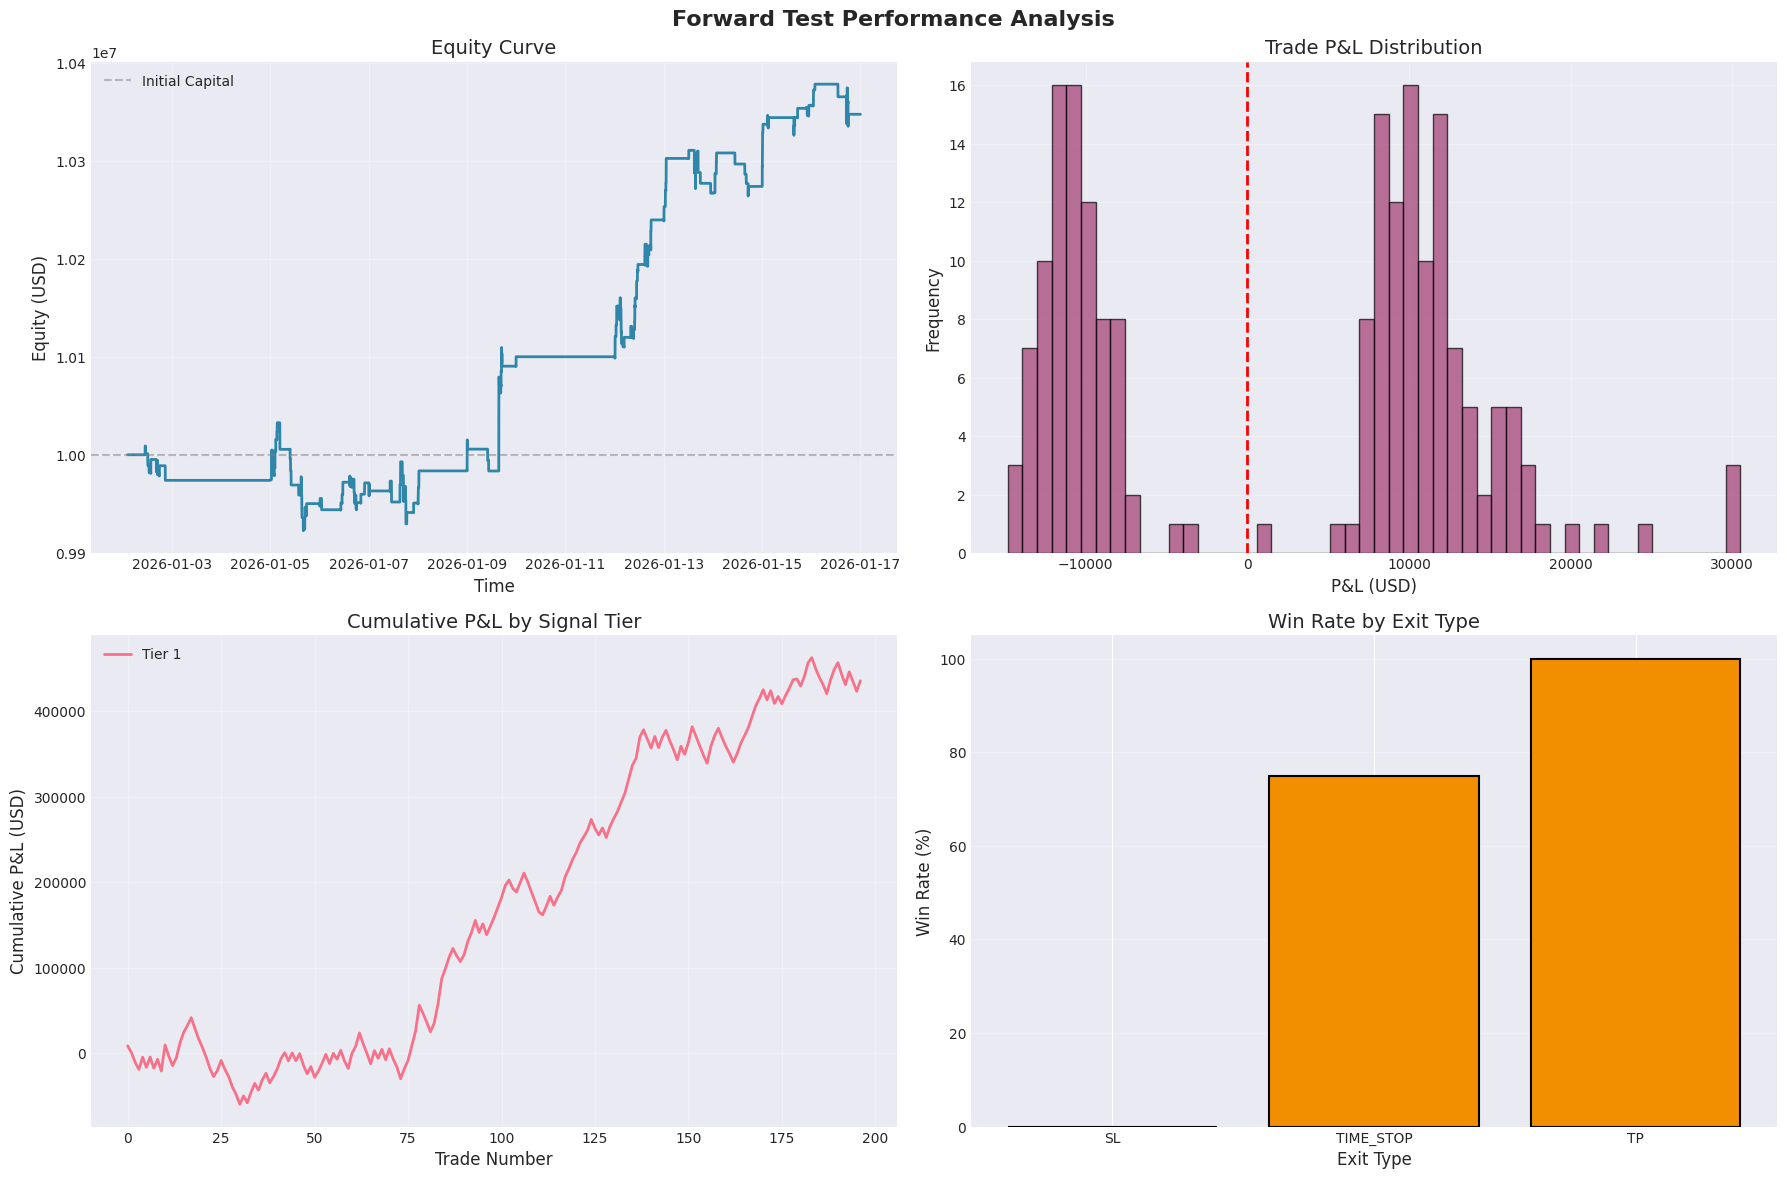



FORWARD TEST COMPLETE



Final Equity: $10,347,304.99
Total Return: 3.47%
Sharpe Ratio: 3.00
Win Rate: 57.4%


In [14]:
np.random.seed(42)


papertrading_data = pd.read_csv(
    '/kaggle/input/eurusdjan2to16data/EURUSD_jan2to16.csv',
    sep='\t'
)
papertrading_data.columns = ['date', 'time', 'bid', 'ask', 'last', 'volume', 'flags']


dt_strings = papertrading_data['date'].astype(str).str.strip() + ' ' + papertrading_data['time'].astype(str).str.strip()


try:
    papertrading_data['datetime'] = pd.to_datetime(dt_strings, format='%Y.%m.%d %H:%M:%S.%f')
except Exception:
    
    papertrading_data['datetime'] = pd.to_datetime(dt_strings, infer_datetime_format=True, errors='coerce')


if papertrading_data['datetime'].isna().any():
    print("Warning: some datetime values failed to parse. Showing a sample:")
    print(papertrading_data[papertrading_data['datetime'].isna()].head())
    
    papertrading_data = papertrading_data.dropna(subset=['datetime']).copy()


papertrading_data = papertrading_data.set_index('datetime').sort_index()


for col in ['bid', 'ask', 'last', 'volume']:
    papertrading_data[col] = pd.to_numeric(papertrading_data[col], errors='coerce')


papertrading_data = papertrading_data.dropna(subset=['bid', 'ask'])

# Quick checks
print(papertrading_data.index.dtype)          
print(papertrading_data[['bid','ask','last','volume']].dtypes)
print(papertrading_data.head())


print(papertrading_data.index.to_series().diff().dt.total_seconds().head())


tester = ForwardTester(
    out_of_sample_data=papertrading_data,
    initial_capital=10000000
)
results = tester.execute_forward_test()


performance = results['performance_metrics']
trades = results['closed_trades']
equity_curve = results['equity_curve']

trades_df = pd.DataFrame(trades)
trades_df.to_csv('forward_test_trades.csv', index=False)

print(f"\nFinal Equity: ${performance['final_capital']:,.2f}")
print(f"Total Return: {performance['total_return_pct']:.2f}%")
print(f"Sharpe Ratio: {performance['sharpe_ratio']:.2f}")
print(f"Win Rate: {performance['win_rate']*100:.1f}%")
